In [1]:
import random
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PlotConfig,
    save_factory,
    COLORMAPS,
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck, drop, merge
from aging.behavior.bio_age_model import fit_model, masked_xval
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from toolz import sliding_window
from collections import defaultdict

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, ParameterGrid

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "fig4-longv1-bambi", tight_layout=False)

In [16]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)

    percentile_.__name__ = "q_{:0.02f}".format(n)
    return percentile_


def compute_classifier(df, seed=0):
    pipe = make_pipeline(
        StandardScaler(),
        SVC(kernel="linear", class_weight="balanced"),
    )

    preds = cross_val_predict(
        pipe,
        df[["beh_age"]],
        df["classes"],
        cv=StratifiedKFold(n_splits=6, shuffle=True, random_state=seed),
    )
    return accuracy_score(df["classes"], preds), preds


def minimizer(corrs):
    return corrs['Death'].iloc[-11:].mean()

## Load the death predictor data

In [4]:
death_df = pd.read_csv('/home/wg41/code/ontogeny/notebooks/exploration/win/death-predictor/death-predictor-data.csv').ffill()
death_df['Death'] = pd.to_datetime(death_df['Death'])

death_map = death_df.set_index('id')[['Death']].drop('04_02')
death_map['death_rank'] = death_map['Death'].rank()

In [5]:
def bin_age(df, bins):
    return pd.cut(df.reset_index()['age'], bins, labels=False)


def compute_correlations(df, bins, death_map, group_size=3):
    df = df.reset_index()
    corrs = []
    for i in range(group_size):
        for bin, _df in df.groupby((bins + i) // group_size, observed=True):

            avgs = _df.groupby('mouse')[['beh_age', 'date', 'age']].mean()

            joined = avgs.join(death_map)
            _corr = joined.corr(method='spearman').loc[['beh_age'], ['Death']]
            # _corr = joined.corr(method='pearson').loc[['beh_age'], ['Death']]

            # joined['bar'] = joined['beh_age'].rank()
            # _corr = joined.corr(method='pearson').loc[['bar'], ['death_rank']]

            _corr.index = pd.Index([joined['age'].mean()], name='age')
            _corr['bin'] = (bin * group_size) + i

            corrs.append(_corr)
    return pd.concat(corrs).sort_index()


def compute_shuffled_correlations(df, bins, death_map, group_size=3, seed=None):
    df_copy = df.reset_index()
    death_map = death_map.copy()
    # death_map['Death'] = death_map['Death'].sample(frac=1, random_state=seed).to_numpy()
    # death_map['death_rank'] = death_map['death_rank'].sample(frac=1, random_state=seed).to_numpy()

    corrs = []
    for i in range(group_size):
        # shuffling happens here
        df_copy['beh_age'] = df.groupby((bins + i) // group_size, observed=True)['beh_age'].transform(lambda x: x.sample(frac=1, random_state=seed).to_numpy())
        # df_copy['beh_age'] = df['beh_age'].sample(frac=1, random_state=seed).to_numpy()
        # df_copy['beh_age'] = df.groupby('mouse')['beh_age'].transform(lambda x: x.sample(frac=1, random_state=seed).to_numpy())

        for bin, _df in df_copy.groupby((bins + i) // group_size, observed=True):

            avgs = _df.groupby('mouse')[['beh_age', 'date', 'age']].mean()

            joined = avgs.join(death_map)
            _corr = joined.corr(method='spearman').loc[['beh_age'], ['Death']]
            # _corr = joined.corr(method='pearson').loc[['beh_age'], ['Death']]

            # joined['bar'] = joined['beh_age'].rank()
            # _corr = joined.corr(method='pearson').loc[['bar'], ['death_rank']]

            _corr.index = pd.Index([joined['age'].mean()], name='age')
            _corr['bin'] = (bin * group_size) + i

            corrs.append(_corr)
    return pd.concat(corrs).sort_index()

In [6]:
to_remove = [
    "e4f1076b",
    "3867c517",
    "60e82cb4",
]

In [7]:
def load_long_df(n_bins: "Optional[int]" = 75):
    keep_syllables = np.loadtxt(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt",
        dtype=int,
    )
    df = pd.read_parquet(
        # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_counts_matrix_v00.parquet"
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[keep_syllables]
    # mask = df.index.get_level_values("age") < 100
    # df = df[mask].copy()

    masks = []
    for uuid in to_remove:
        m = df.reset_index()["uuid"].str.startswith(uuid)
        masks.append(m)
    mask = np.array(reduce(or_, masks), dtype=bool)
    df = df[~mask].copy()

    size_df = pd.read_parquet(
        # '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_mouse_area_df_v00.parquet'
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_mouse_area_df_v00.parquet"
    )
    # mask = size_df.index.get_level_values("age") < 100
    # size_df = size_df[mask].copy()
    age_cut = pd.cut(size_df.index.get_level_values("age"), 19)

    size_df.loc[size_df["quant_0.5"] == 0, "quant_0.5"] = np.nan
    sizes_col = size_df["quant_0.5"]
    sizes_col = (
        sizes_col.groupby("mouse")
        .apply(lambda df: df.sort_index(level="age").interpolate())
        .droplevel(0)
    )

    # sizes_col = zscore(sizes_col.groupby(age_cut, observed=True).transform(demean))
    sizes_col = sizes_col.groupby(age_cut, observed=True).transform(zscore)
    sizes_col = sizes_col.fillna(0)
    sizes_col = sizes_col.loc[df.index]

    # make sure df matches sizes
    df = df.loc[sizes_col.index]

    if n_bins is not None:
        # subsample the dataset
        cut, bins = pd.cut(df.index.get_level_values("age"), n_bins, retbins=True)
        # tmp_df = df.groupby(['mouse', cut], observed=True).first()
        tmp_df = (
            df.reset_index()
            .groupby(["mouse", cut], observed=True)
            .first()
            .reset_index()
            .drop(columns=["level_1"])
            .set_index(["age", "mouse", "subject_name", "session_name", "uuid", "date"])
        )
        # mid_age = [round(v.left, 2) for v in tmp_df.index.get_level_values(1)]
        # tmp_df['age'] = mid_age
        # tmp_df = tmp_df.set_index('age', append=True).droplevel(1)

        sizes_col = (
            sizes_col.reset_index().groupby(["mouse", cut], observed=True).first()
        )
        sizes_col = (
            sizes_col.reset_index()
            .drop(columns=["level_1"])
            .set_index(["age", "mouse", "subject_name", "session_name", "uuid", "date"])
        )
        sizes_col = sizes_col.loc[tmp_df.index, "quant_0.5"]
    else:
        tmp_df = df

    age = jnp.array(tmp_df.index.get_level_values("age"))
    syllable_counts_jax = jnp.array(tmp_df.astype(float))

    label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
    mouse_ids = label_encoder.fit_transform(
        sizes_col.index.get_level_values("mouse").to_numpy()[:, None]
    ).T

    sort_idx = np.argsort(syllable_counts_jax.sum(0))[::-1]

    return tmp_df, syllable_counts_jax, age, sizes_col, mouse_ids, sort_idx

In [8]:
tmp_df, syllable_counts_jax, age, size_col, mouse_ids, sort_idx = load_long_df(None)

In [9]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": size_col.to_numpy(),  # models > 1
    "mice": mouse_ids,
}

# age_sd = 0.04
age_sd = 10

hypparams = {
    "log_age": False,
    "min_age": 3,
    "max_age": 150,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 400,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "lr": 0.25,
    "n_opt_iter": 500,
}

In [10]:
mdl = fit_model(features, hypparams, 5)

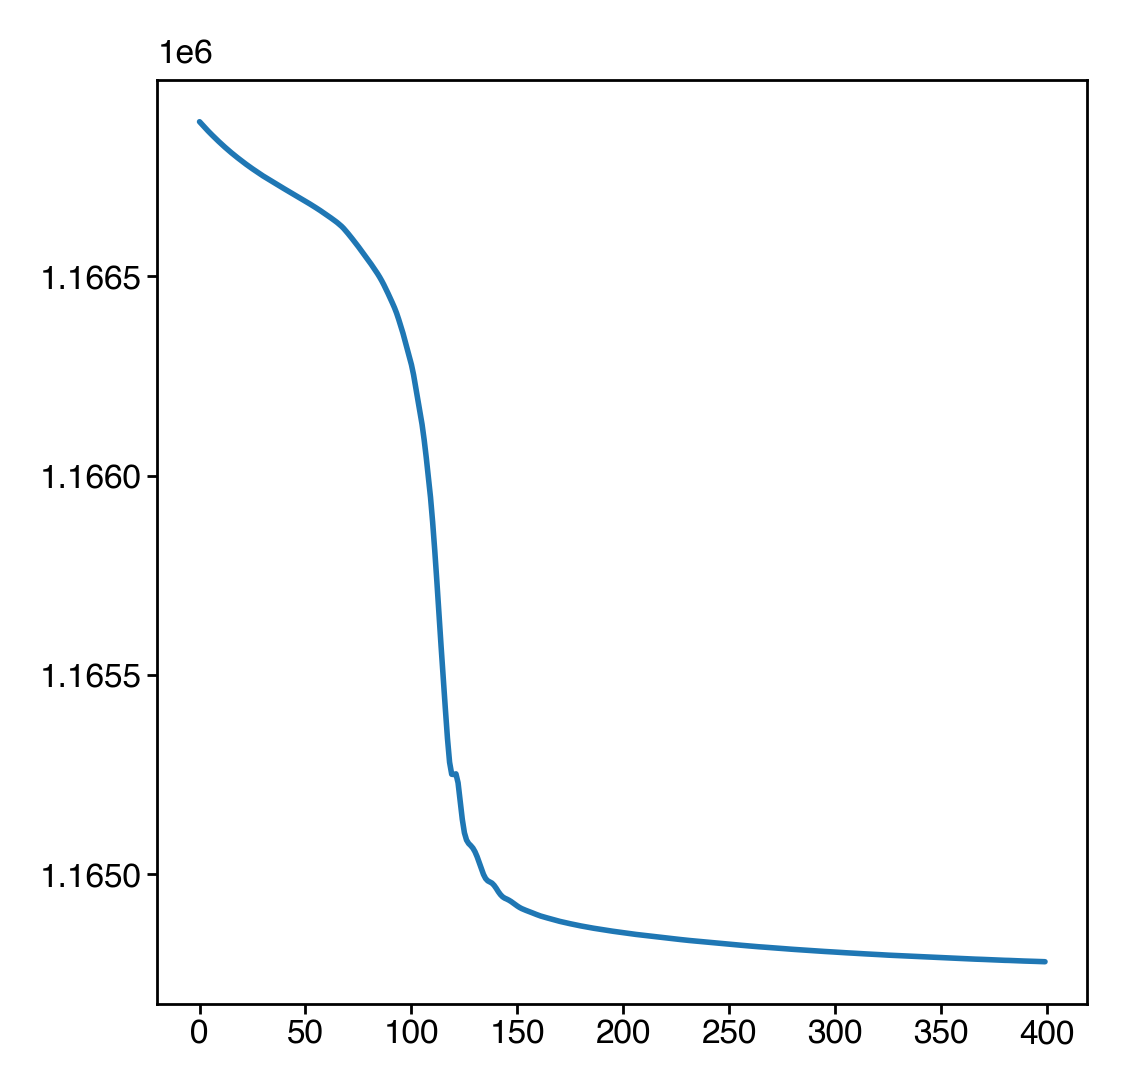

In [11]:
plt.plot(mdl['loss'][100:])

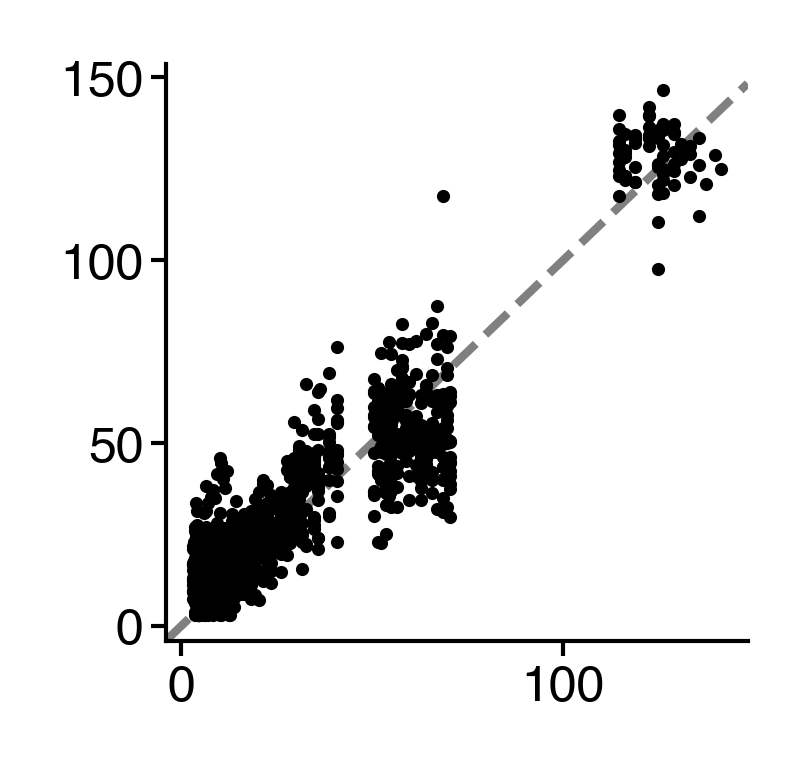

In [12]:
fig = figure(1.25, 1.25)
plt.scatter(mdl['true_ages'], mdl['bio_ages'], c='k', s=2.5, lw=0)
a = add_identity(plt.gca(), c='gray', ls='--', zorder=-1)
sns.despine()

In [14]:
bins, _bins = pd.cut(tmp_df.reset_index()['age'], 28, labels=False, retbins=True)
tmp_df['beh_age'] = mdl['bio_ages']
corrs = compute_correlations(tmp_df, bin_age(tmp_df, _bins), death_map, group_size=4)
minimizer(corrs)

-0.2124217482874154

In [11]:
def compute_correlations_v2(df, win_size=16):
    reset_df = df.reset_index()

    sliding_corr_df = []

    # for w in sliding_window(win_size, range(3, 71)):
    for w in sliding_window(win_size, range(3, 142)):
        subset = reset_df[reset_df['age'].between(w[0], w[-1])]
        subset_join = subset.merge(
            death_map.reset_index(), left_on="mouse", right_on="id"
        ).dropna(subset=["Death"])

        # proven that this gives the same result as casting the datetime to int
        # res = spearmanr(subset_join["beh_age"], subset_join["Death"].rank(method="min"))
        res = spearmanr(subset_join["beh_age"], subset_join["Death"].rank(method="dense"))
        sliding_corr_df.append(
            dict(
                corr=res.correlation,
                p=res.pvalue,
                start=w[0],
                stop=w[-1],
                avg=subset["age"].mean(),
                n_samples=len(subset),
            )
        )
    sliding_corr_df = pd.DataFrame(sliding_corr_df)
    return sliding_corr_df

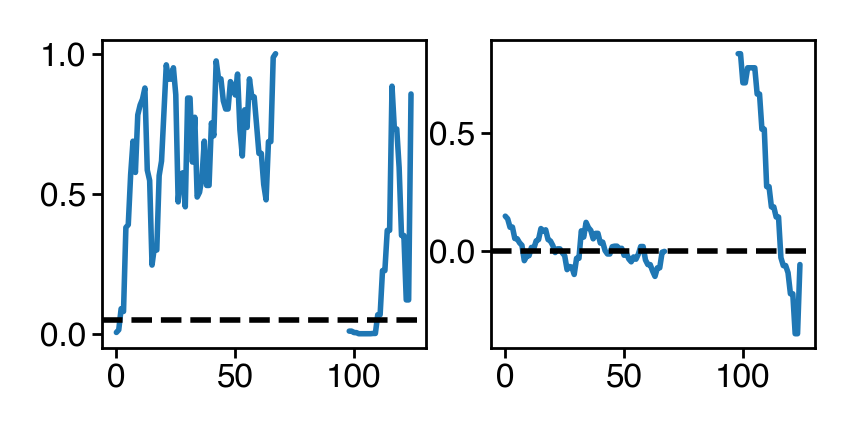

In [16]:
sliding_corr_df = compute_correlations_v2(tmp_df, win_size=15)

fig, ax = plt.subplots(1, 2, figsize=(2.3, 1))

a = sliding_corr_df['p'].plot(ax=ax[0])
a.axhline(0.05, color='k', ls='--')
a = sliding_corr_df['corr'].plot(ax=ax[1])
a.axhline(0, color='k', ls='--')

In [17]:
sliding_corr_df

corr         p  start  stop         avg  n_samples
0    0.149353  0.004627      3    17    8.706582        408
1    0.138103  0.014009      4    18    9.971429        360
2    0.102238  0.089445      5    19   11.449753        317
3    0.103118  0.079581      6    20   11.803787        332
4    0.054745  0.379328      7    21   12.979387        298
..        ...       ...    ...   ...         ...        ...
120 -0.179707  0.350920    123   137  128.379578         35
121 -0.179707  0.350920    124   138  128.630936         36
122 -0.349207  0.120759    125   139  129.888885         27
123 -0.349207  0.120759    126   140  130.239792         28
124 -0.055846  0.856207    127   141  132.112793         19

[125 rows x 6 columns]

In [80]:
random.seed(0)

grid = {
    # 'age_sd': np.logspace(-2, np.log10(0.13), 13),
    'age_sd': np.linspace(5, 40, 8, dtype=float),
    # 'n_splines': [4, 5],
    'n_splines': [4],
    'scale': np.arange(25, 401, 25, dtype=int),
    "n_development_splines": [4, 5],
}

win_size = 15

bins, _bins = pd.cut(tmp_df.reset_index()['age'], 28, labels=False, retbins=True)

pg = list(ParameterGrid(grid))
random.shuffle(pg)

min_correlation = np.inf
min_correlation2 = np.inf

pbar = tqdm(pg)

out = []
for params in pbar:
    # remove the numpy class from scalars
    params = valmap(float, params)
    # params['n_development_splines'] = int(params['n_development_splines'])
    params['n_splines'] = int(params['n_splines'])
    params['n_development_splines'] = int(params['n_development_splines'])
    new_hypparams = merge(hypparams, params)
    try:
        tmp_mdl = fit_model(features, new_hypparams, 5)
        tmp_df['beh_age'] = tmp_mdl['bio_ages']
        corrs = compute_correlations(tmp_df, bin_age(tmp_df, _bins), death_map, group_size=4)
        params['death_corr'] = minimizer(corrs)
        sliding_corr_df = compute_correlations_v2(tmp_df, win_size=win_size)
        sliding_corr_df = sliding_corr_df.groupby('avg').mean().reset_index()
        c = sliding_corr_df.dropna().query('n_samples > 10 & avg > 50').mean()['corr']

        params['death_corr2'] = c

        if params['death_corr'] < min_correlation:
            min_correlation = params['death_corr']
            pbar.set_description(f"{min_correlation:0.2f} - {min_correlation2:0.2f}")

        if params['death_corr2'] < min_correlation2:
            min_correlation2 = params['death_corr2']
            pbar.set_description(f"{min_correlation:0.2f} - {min_correlation2:0.2f}")

        out.append(params)
    except ValueError:
        pass

  0%|          | 0/256 [00:00<?, ?it/s]

In [81]:
opt_df = pd.DataFrame(out)

In [82]:
opt_df.to_parquet('/n/scratch/users/w/wg41/2024-06-13-death-predictor-params-age-v2.parquet')

In [83]:
sorted_opt_df = opt_df.sort_values(by='death_corr2')
sorted_opt_df

age_sd  n_development_splines  n_splines  scale  death_corr  death_corr2
80     20.0                      5          4   25.0   -0.476712    -0.161708
227    15.0                      4          4   25.0   -0.474141    -0.151484
70     40.0                      5          4  250.0   -0.389210    -0.149877
85     20.0                      4          4   25.0   -0.470719    -0.149877
209    15.0                      5          4   25.0   -0.492704    -0.149185
..      ...                    ...        ...    ...         ...          ...
245    40.0                      4          4  300.0    0.182518     0.181290
162    35.0                      4          4  375.0    0.168330     0.191279
19     35.0                      5          4  350.0    0.038571     0.208254
23     35.0                      5          4  375.0    0.213791     0.219525
168    35.0                      4          4  350.0    0.197597     0.264838

[256 rows x 6 columns]

<Axes: xlabel='death_corr', ylabel='death_corr2'>

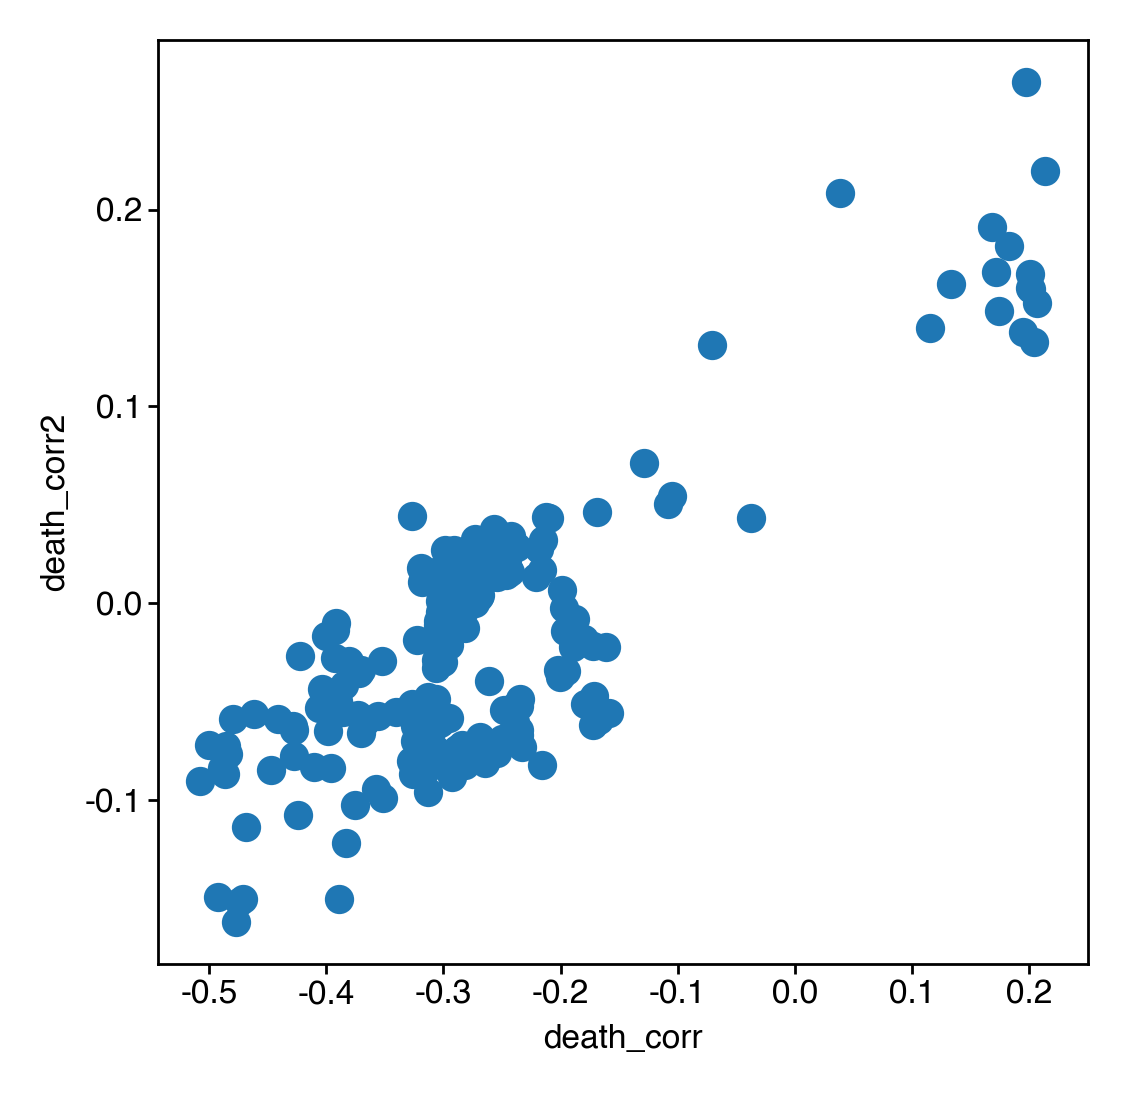

In [84]:
sorted_opt_df.plot(kind='scatter', x='death_corr', y='death_corr2')

<Axes: xlabel='scale', ylabel='age_sd'>

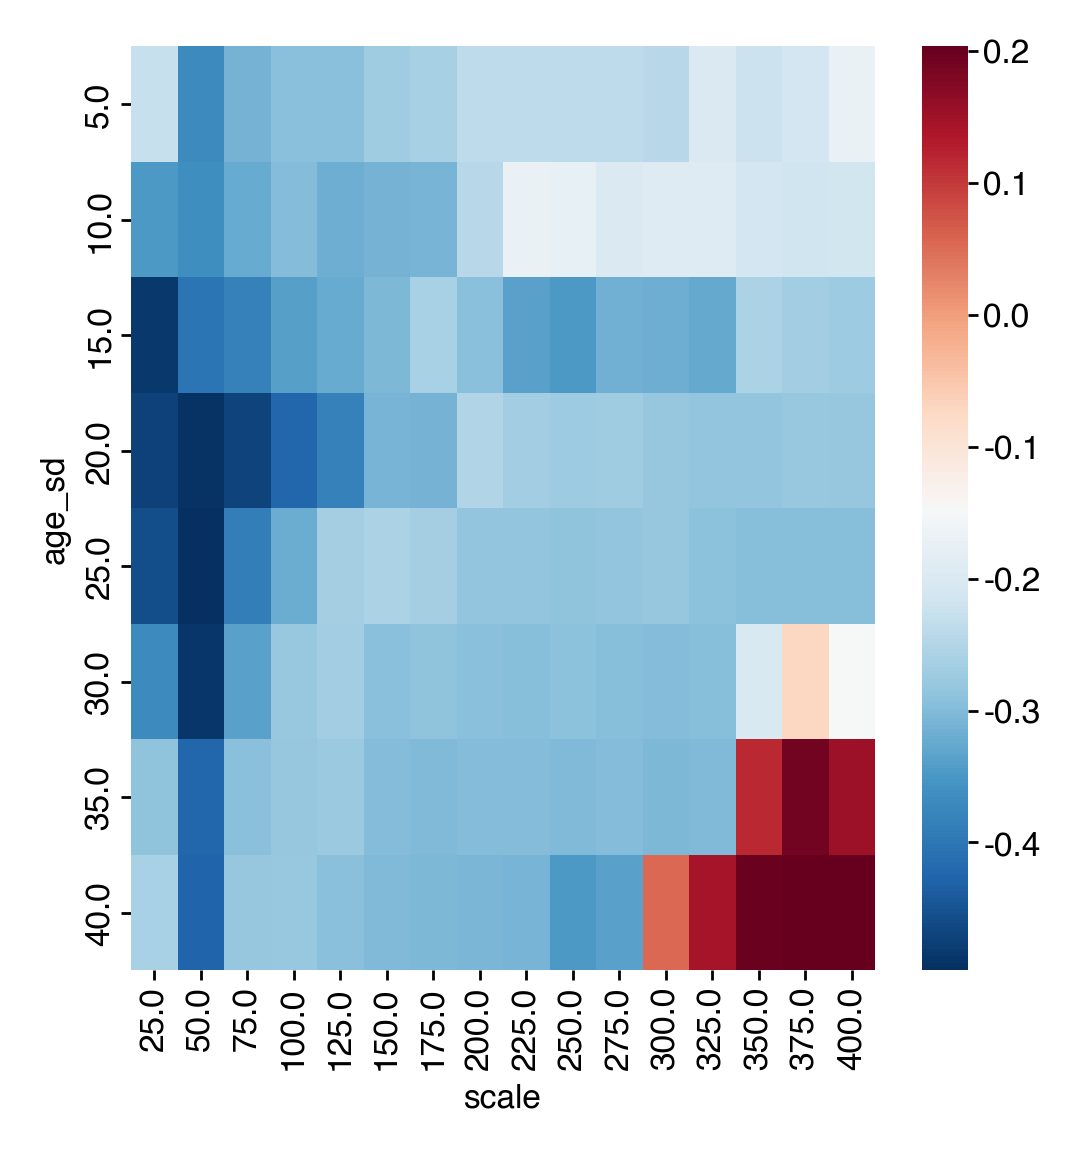

In [85]:
sns.heatmap(pd.pivot_table(opt_df, index='age_sd', columns='scale', values='death_corr'), cmap='RdBu_r')

<Axes: xlabel='scale', ylabel='age_sd'>

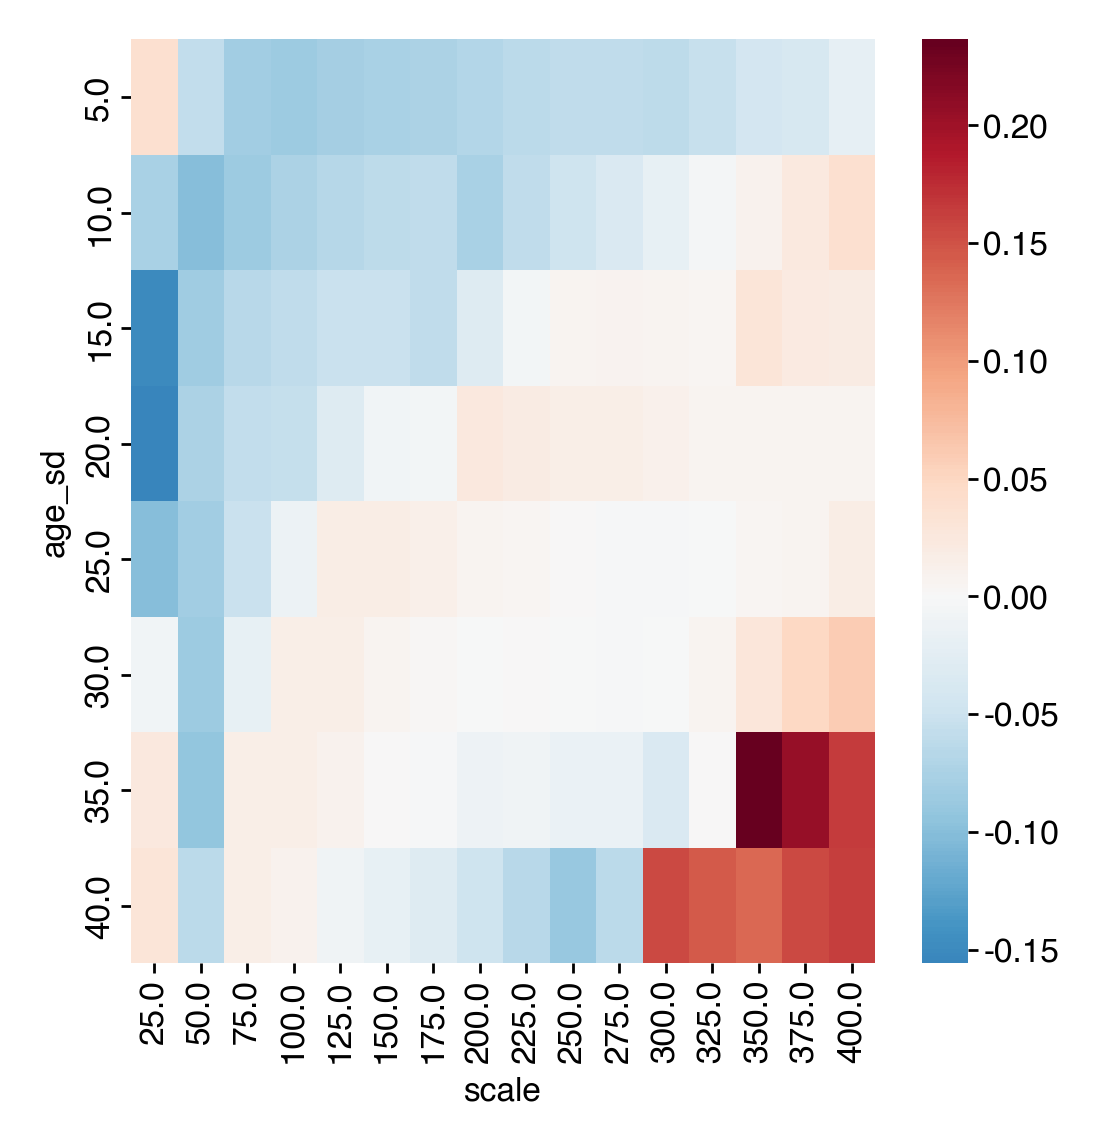

In [86]:
sns.heatmap(pd.pivot_table(opt_df, index='age_sd', columns='scale', values='death_corr2'), cmap='RdBu_r', center=0)

<Axes: xlabel='scale'>

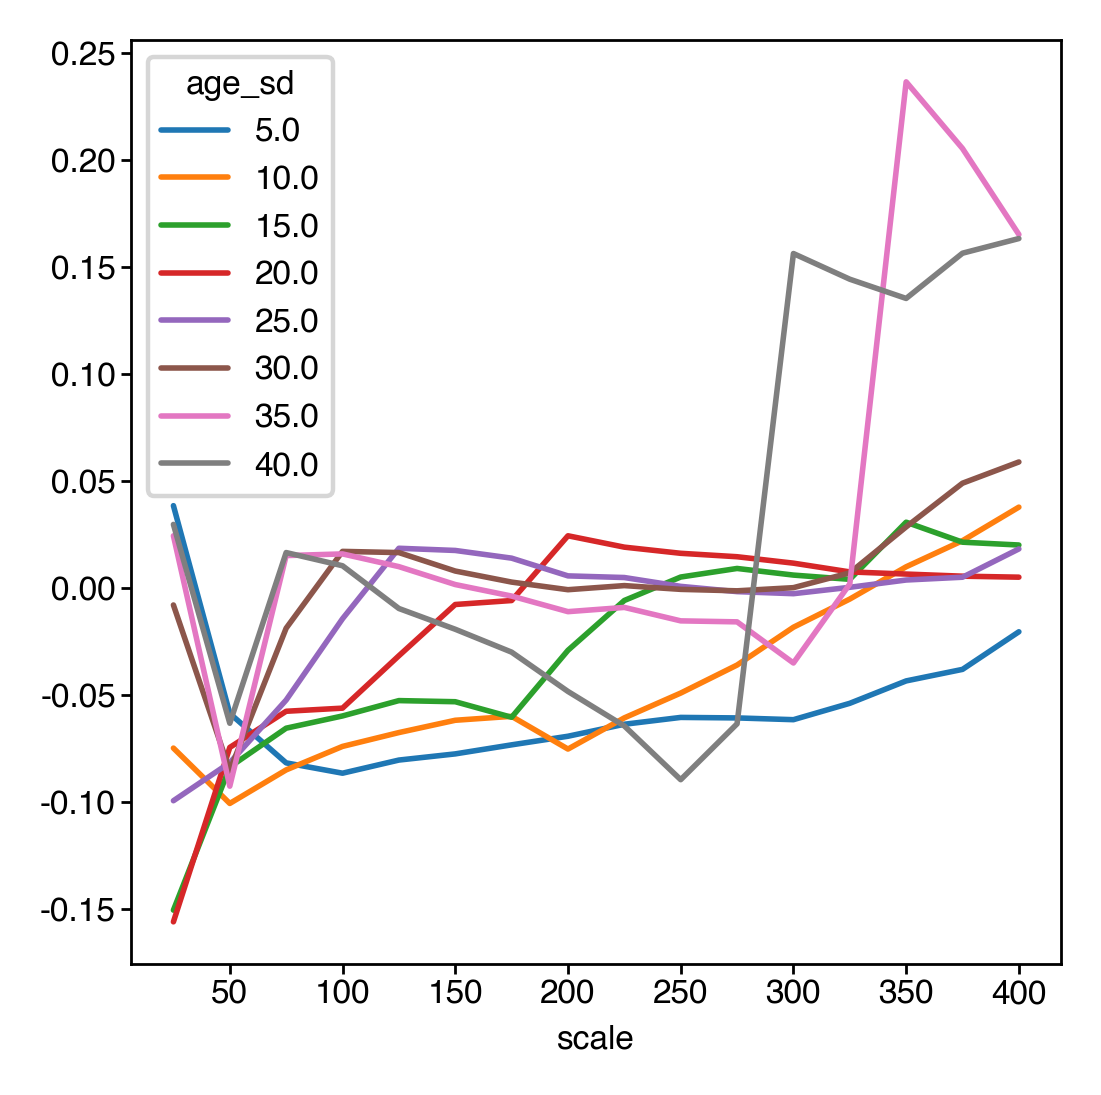

In [87]:
pd.pivot_table(opt_df, index='age_sd', columns='scale', values='death_corr2').T.plot()

<Axes: xlabel='age_sd'>

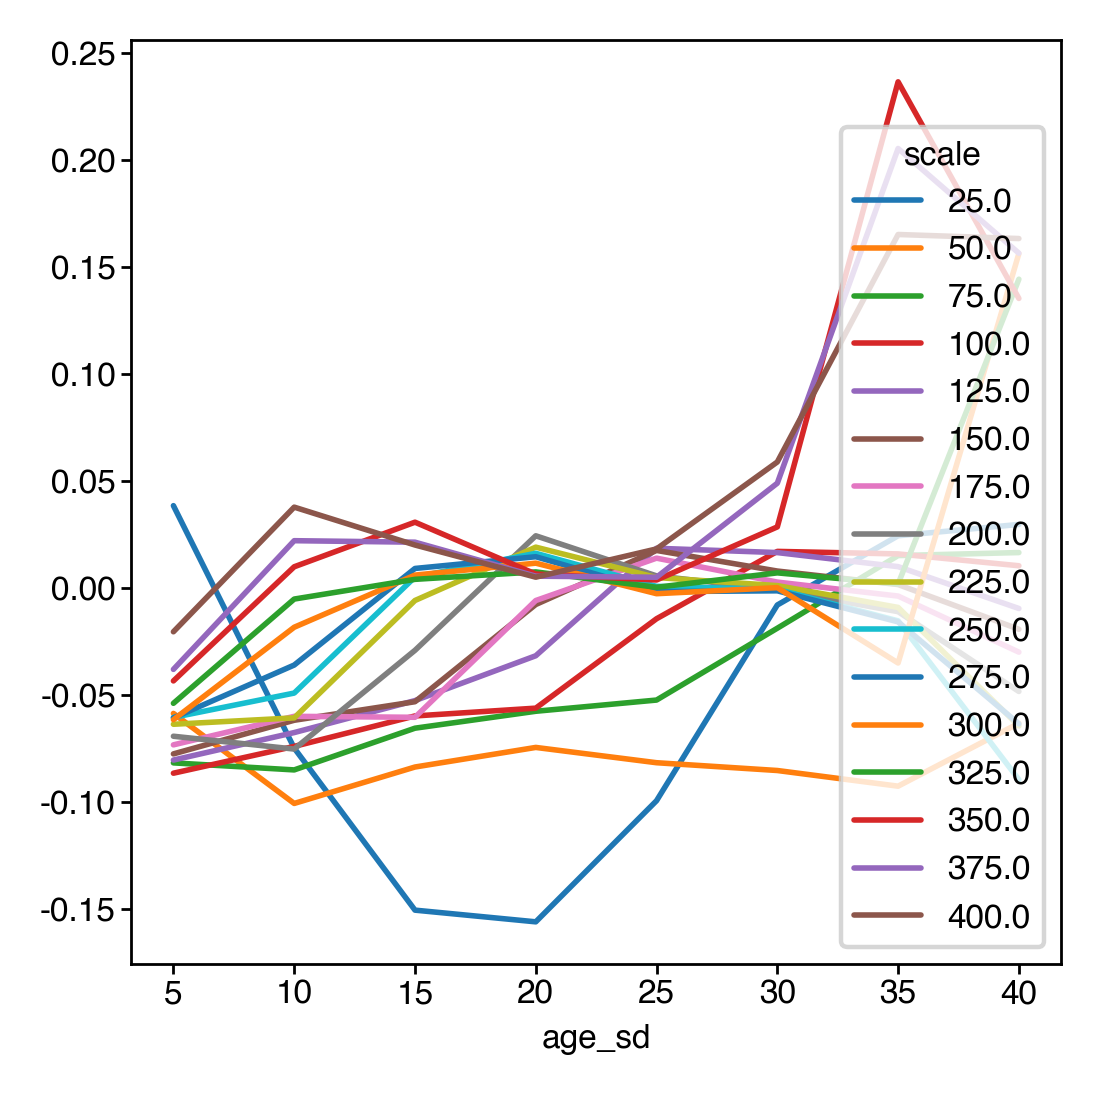

In [88]:
pd.pivot_table(opt_df, index='age_sd', columns='scale', values='death_corr2').plot()

<Axes: xlabel='scale', ylabel='n_development_splines'>

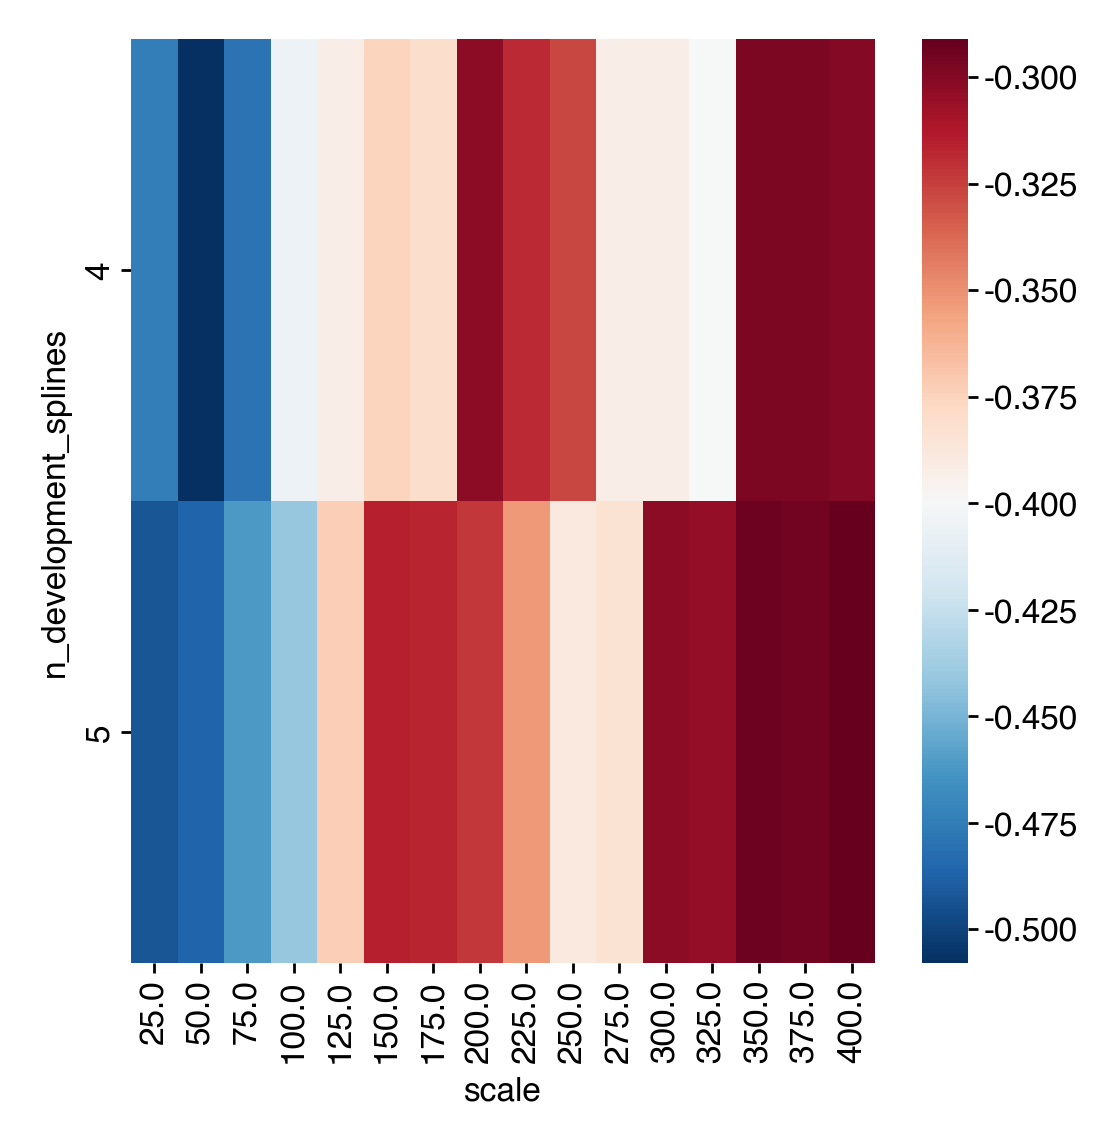

In [89]:
sns.heatmap(pd.pivot_table(opt_df, index='n_development_splines', columns='scale', values='death_corr', aggfunc='min'), cmap='RdBu_r')

<Axes: xlabel='scale', ylabel='n_development_splines'>

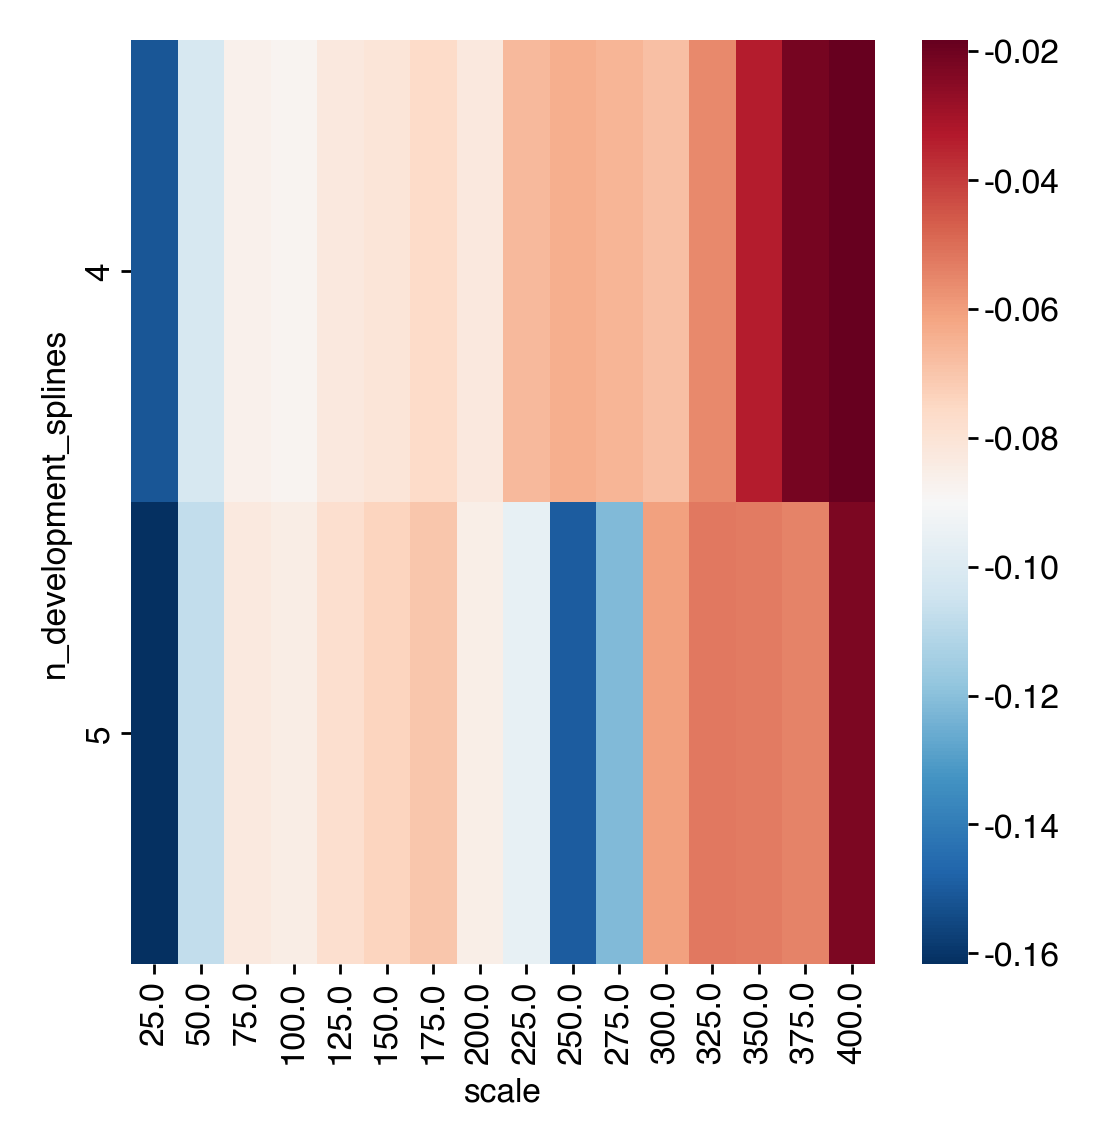

In [90]:
sns.heatmap(pd.pivot_table(opt_df, index='n_development_splines', columns='scale', values='death_corr2', aggfunc='min'), cmap='RdBu_r')

<Axes: xlabel='age_sd', ylabel='n_development_splines'>

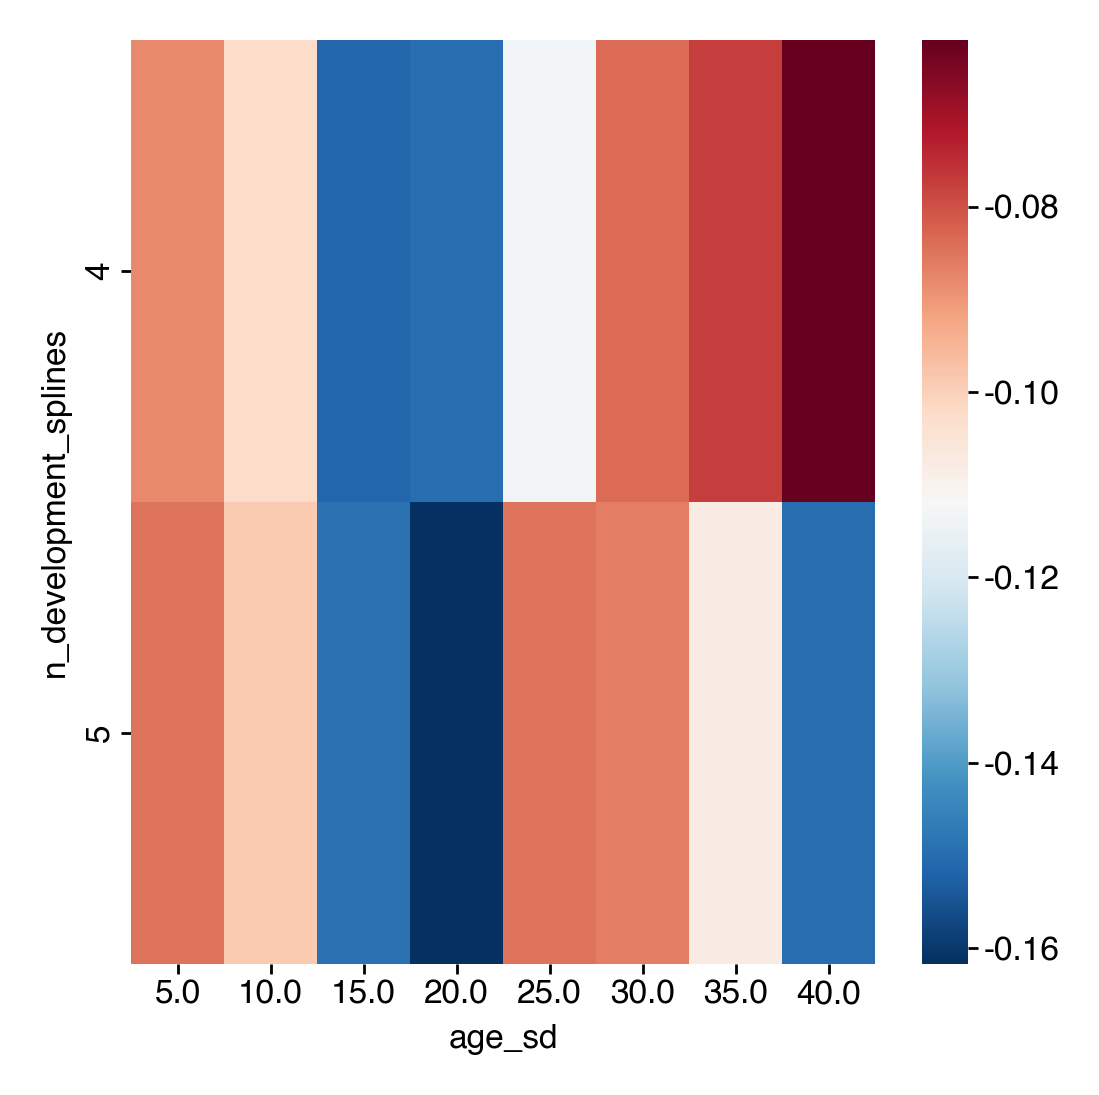

In [163]:
sns.heatmap(pd.pivot_table(opt_df, index='n_development_splines', columns='age_sd', values='death_corr2', aggfunc='min'), cmap='RdBu_r')

In [33]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": size_col.to_numpy(),  # models > 1
    "mice": mouse_ids,
}

# age_sd = 0.04
age_sd = 25

hypparams = {
    "log_age": False,
    "min_age": 3,
    "max_age": 150,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 5,
    "scale": 25,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "lr": 0.25,
    "n_opt_iter": 500,
}

In [34]:
mdl = fit_model(features, hypparams, 5)

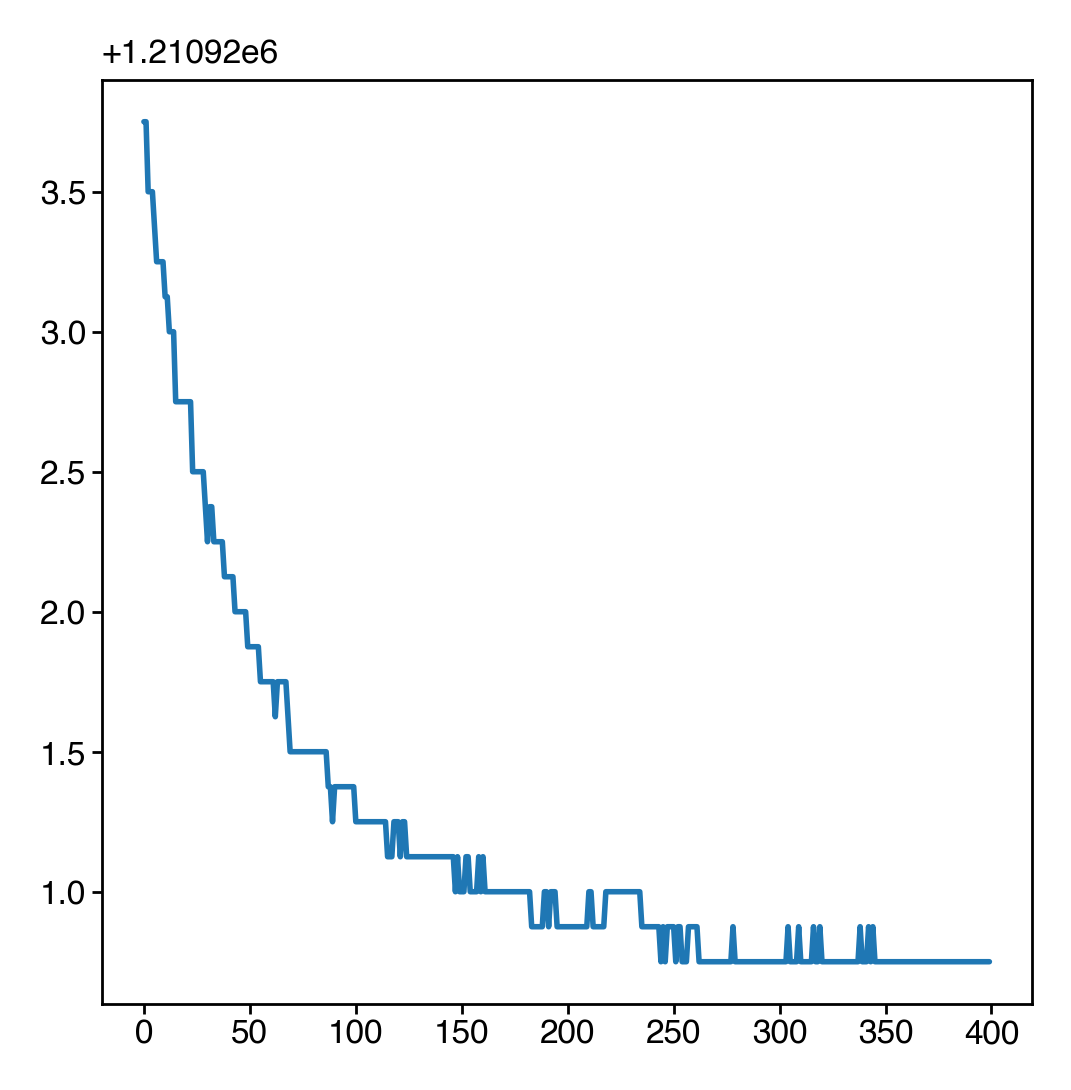

In [35]:
plt.plot(mdl['loss'][100:])

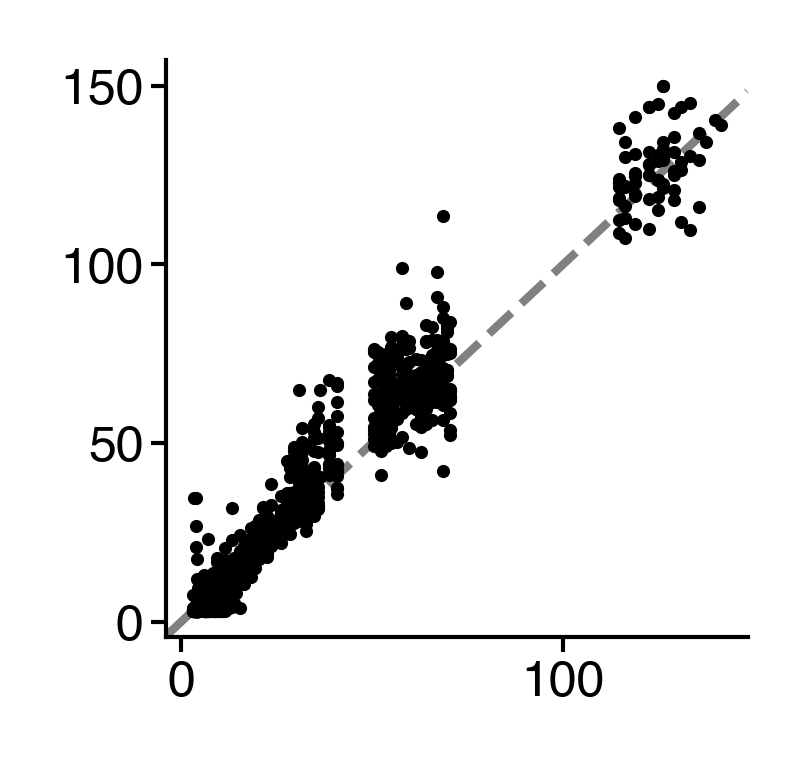

In [36]:
fig = figure(1.25, 1.25)
plt.scatter(mdl['true_ages'], mdl['bio_ages'], c='k', s=2.5, lw=0)
a = add_identity(plt.gca(), c='gray', ls='--', zorder=-1)
sns.despine()

In [37]:
bins, _bins = pd.cut(tmp_df.reset_index()['age'], 28, labels=False, retbins=True)
tmp_df['beh_age'] = mdl['bio_ages']
corrs = compute_correlations(tmp_df, bin_age(tmp_df, _bins), death_map, group_size=4)
minimizer(corrs)

-0.44696972741142116

<Axes: xlabel='age'>

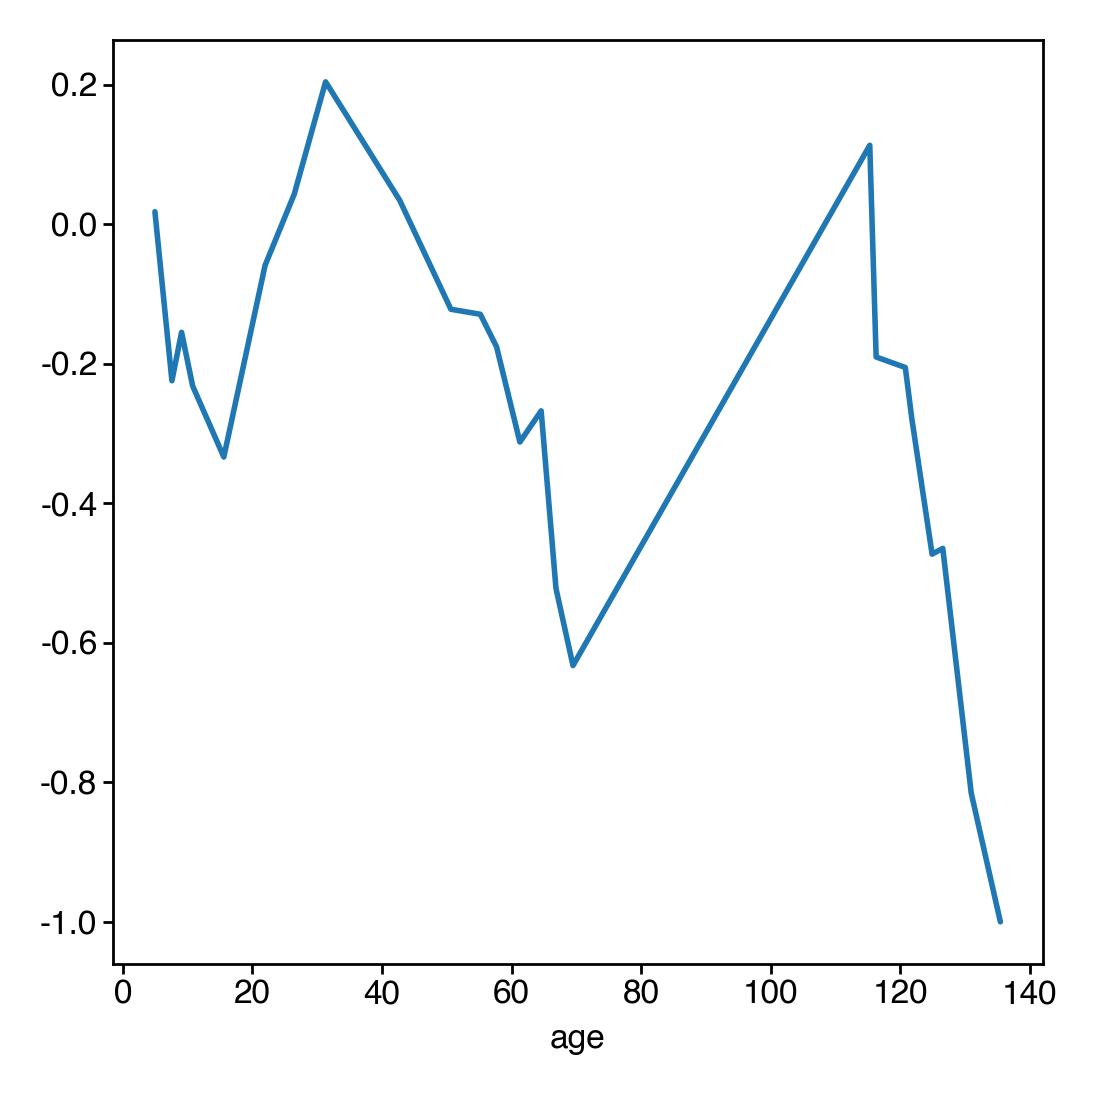

In [38]:
corrs['Death'].plot()

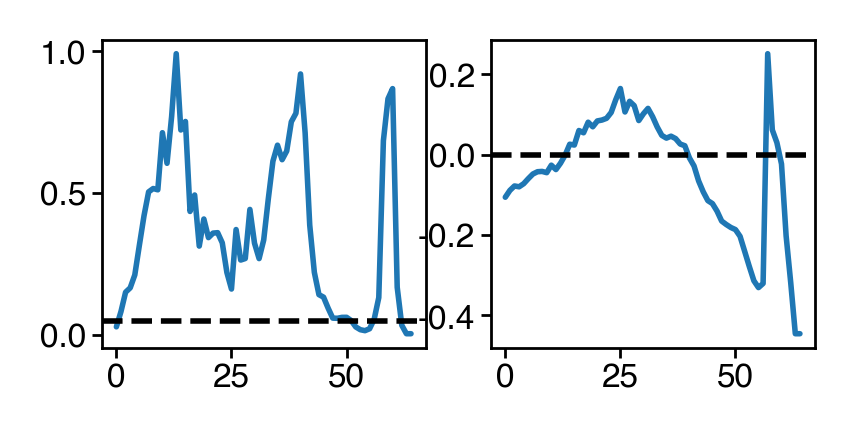

In [24]:
sliding_corr_df = compute_correlations_v2(tmp_df, win_size=20)
sliding_corr_df = sliding_corr_df.query('n_samples > 40 | n_samples == 0')
sliding_corr_df = sliding_corr_df.groupby('avg').mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(2.3, 1))

a = sliding_corr_df['p'].plot(ax=ax[0])
a.axhline(0.05, color='k', ls='--')
a = sliding_corr_df['corr'].plot(ax=ax[1])
a.axhline(0, color='k', ls='--')

In [25]:
# shuffle
shuffs = []
for i in tqdm(range(200)):
    shuff_df = tmp_df.copy()#.reset_index()
    shuff_df['beh_age'] = shuff_df['beh_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
    _df = compute_correlations_v2(shuff_df, win_size=20)
    _df = _df.query('n_samples > 20 | n_samples == 0')
    _df = _df.groupby('avg').mean().reset_index()
    shuffs.append(_df.set_index('avg')['corr'].rename(i))

  0%|          | 0/200 [00:00<?, ?it/s]

In [26]:
shuffs = pd.concat(shuffs, axis=1)
tmp_plt = shuffs.reset_index().melt(id_vars='avg')

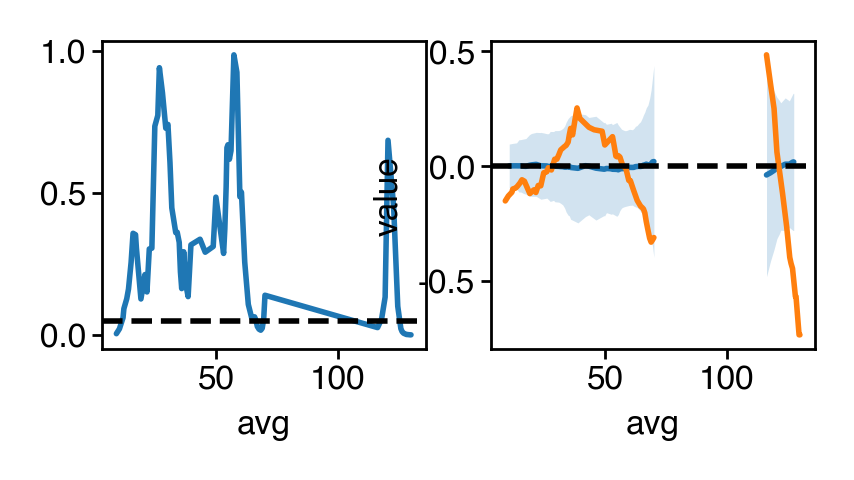

In [27]:
sliding_corr_df = compute_correlations_v2(tmp_df, win_size=15)
sliding_corr_df = sliding_corr_df.query('n_samples > 20 | n_samples == 0')
sliding_corr_df = sliding_corr_df.groupby('avg').mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(2.3, 1))

a = sliding_corr_df.set_index('avg')['p'].plot(ax=ax[0])
a.axhline(0.05, color='k', ls='--')

a = sns.lineplot(data=tmp_plt.query('avg < 100'), x='avg', y='value', errorbar=("sd", 2), ax=ax[1], err_kws=dict(lw=0))
a = sns.lineplot(data=tmp_plt.query('avg > 100'), x='avg', y='value', errorbar=("sd", 2), ax=ax[1], err_kws=dict(lw=0), color='C0')
a = sliding_corr_df.set_index('avg').loc[:100]['corr'].plot(ax=a, color='C1')
a = sliding_corr_df.set_index('avg').loc[100:]['corr'].plot(ax=a, color='C1')
a.axhline(0, color='k', ls='--')

In [28]:
# optimize the win_size for computing correlations
x = np.arange(3, 51, 2)
corrs = {}
for w in x:
    sliding_corr_df = compute_correlations_v2(tmp_df, win_size=w)
    sliding_corr_df = sliding_corr_df.groupby('avg').mean().reset_index()
    c = sliding_corr_df.dropna().query('n_samples > 10 & avg > 50').mean()['corr']
    corrs[w] = c
# sliding_corr_df = sliding_corr_df.query('n_samples > 40 | n_samples == 0')


/tmp/ipykernel_27432/2199235895.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(subset_join["beh_age"], subset_join["Death"].rank(method="dense"))


In [29]:
pd.Series(corrs).idxmin()

15

In [30]:
# shuffle
shuffs = []
for i in tqdm(range(150)):
    shuff_df = tmp_df.copy().reset_index(level="age")
    shuff_df["beh_age"] = shuff_df.groupby(
        pd.cut(shuff_df["age"], 51, labels=False), observed=True
    )["beh_age"].transform(
        lambda x: x.sample(frac=1, replace=False, random_state=i).to_numpy()
    )

    # shuff_df['beh_age'] = shuff_df['beh_age'].sample(frac=1, replace=False, random_state=i).to_numpy()

    _df = compute_correlations_v2(shuff_df, win_size=15)
    _df = _df.query("n_samples > 30 | n_samples == 0")
    _df = _df.groupby("avg").mean().reset_index()
    shuffs.append(_df.set_index("avg")["corr"].rename(i))

shuffs = pd.concat(shuffs, axis=1)
tmp_plt = shuffs.reset_index().melt(id_vars="avg")

  0%|          | 0/150 [00:00<?, ?it/s]

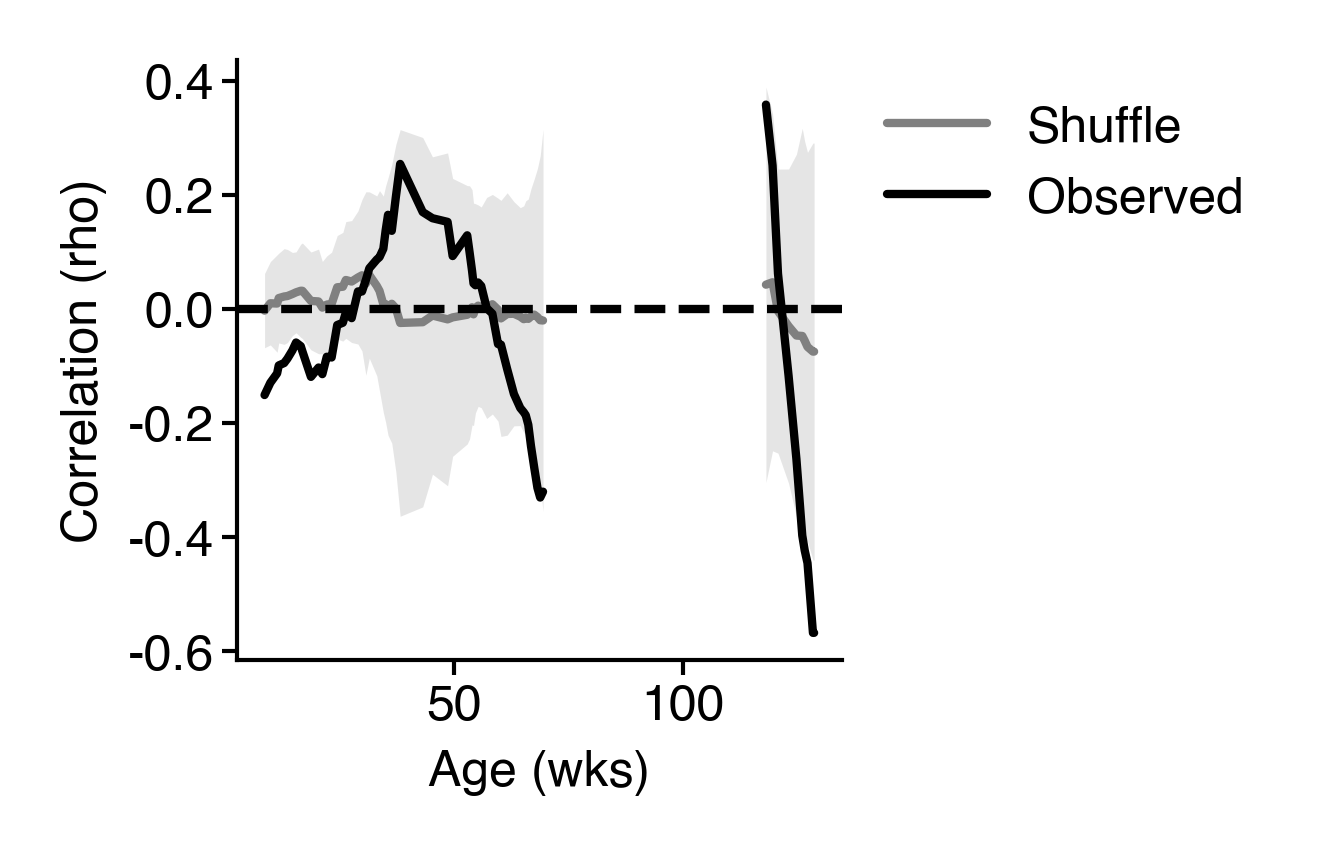

In [31]:
fig = figure(1.3, 1.3)
ax = fig.gca()

sliding_corr_df = compute_correlations_v2(tmp_df, win_size=15)
sliding_corr_df = sliding_corr_df.query("n_samples > 30 | n_samples == 0")
sliding_corr_df = sliding_corr_df.groupby("avg").mean().reset_index()


a = sns.lineplot(
    data=tmp_plt.query("avg < 100"),
    x="avg",
    y="value",
    errorbar=("sd", 2),
    ax=ax,
    err_kws=dict(lw=0),
    color="gray",
    label="Shuffle",
)
a = sns.lineplot(
    data=tmp_plt.query("avg > 100"),
    x="avg",
    y="value",
    errorbar=("sd", 2),
    ax=a,
    err_kws=dict(lw=0),
    color="gray",
)
a = (
    sliding_corr_df.set_index("avg")
    .loc[:100]["corr"]
    .plot(ax=a, color="k", label="Observed")
)
a = sliding_corr_df.set_index("avg").loc[100:]["corr"].plot(ax=a, color="k", label="")
a.axhline(0, color="k", ls="--")
legend(a)
a.set(xlabel="Age (wks)", ylabel="Correlation (rho)")
sns.despine()
saver(fig, "death-predictor-correlations");

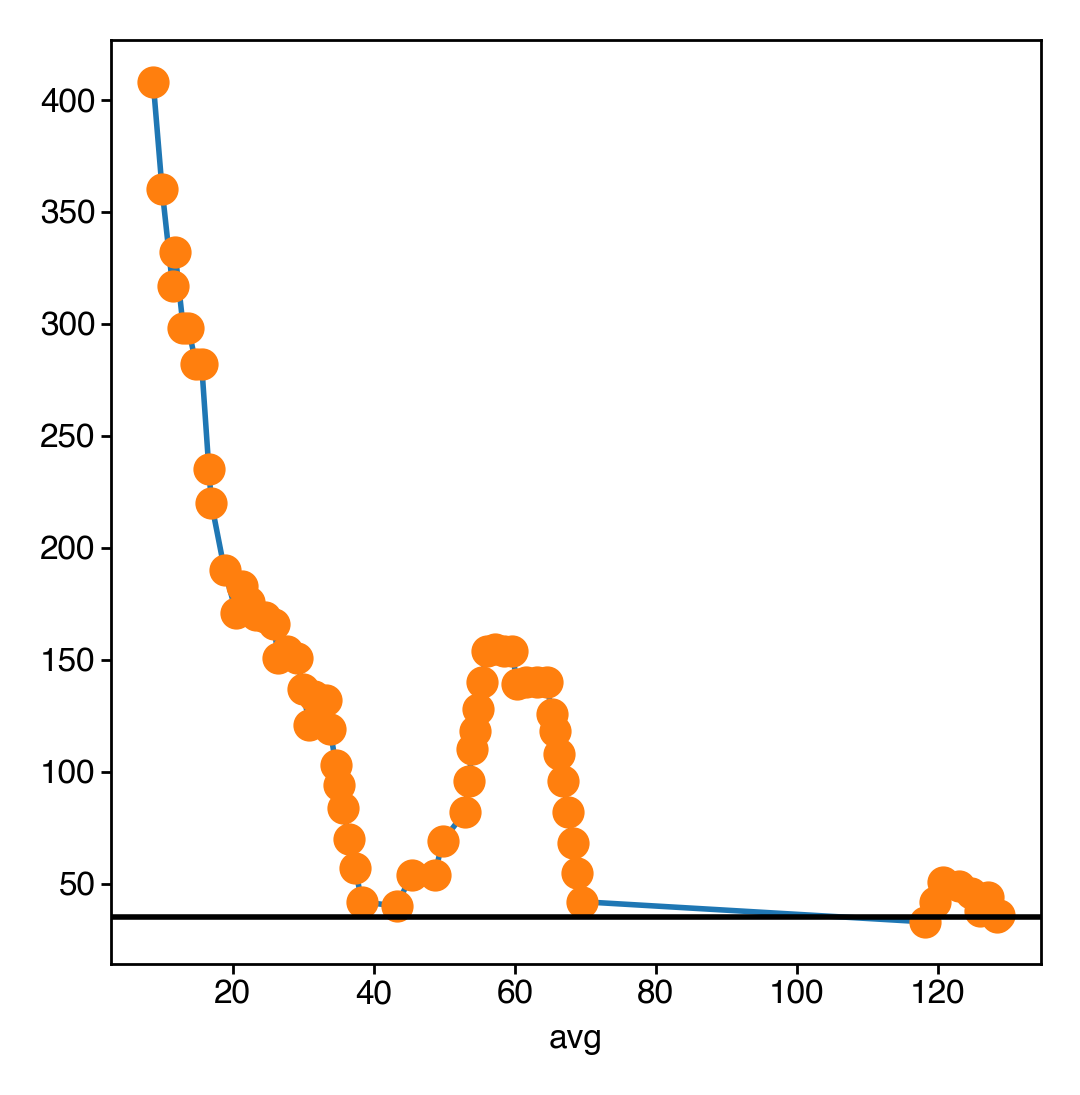

In [32]:
ax = sliding_corr_df.set_index('avg')['n_samples'].plot()
plt.plot(sliding_corr_df.set_index('avg')['n_samples'], 'o')
ax.axhline(35, color='k')

In [12]:
def compute_correlations_v3(df, win_size=15, n_samples=30, seed=0):
    reset_df = df.reset_index()

    sliding_corr_df = []

    # for w in sliding_window(win_size, range(3, 71)):
    for w in sliding_window(win_size, range(3, 142)):
        subset = reset_df[reset_df['age'].between(w[0], w[-1])]
        subset_join = subset.merge(
            death_map.reset_index(), left_on="mouse", right_on="id"
        ).dropna(subset=["Death"])
        try:
            subset_join = subset_join.sample(n=n_samples, random_state=seed)

            # proven that this gives the same result as casting the datetime to int
            # res = spearmanr(subset_join["beh_age"], subset_join["Death"].rank(method="min"))
            res = spearmanr(subset_join["beh_age"], subset_join["Death"].rank(method="dense"))
            sliding_corr_df.append(
                dict(
                    corr=res.correlation,
                    p=res.pvalue,
                    start=w[0],
                    stop=w[-1],
                    avg=subset["age"].mean(),
                    n_samples=len(subset_join),
                )
            )
        except ValueError:
            continue
    sliding_corr_df = pd.DataFrame(sliding_corr_df)
    return sliding_corr_df

In [34]:
sliding_corr_df = pd.concat(
    compute_correlations_v3(tmp_df, win_size=15, n_samples=25, seed=i).drop_duplicates(
        subset=["avg"]
    )
    for i in tqdm(range(100))
)
sliding_corr_df = sliding_corr_df.groupby("start").mean().reset_index()

  0%|          | 0/100 [00:00<?, ?it/s]

In [35]:
# shuffle
shuffs = []
for i in tqdm(range(100)):
    shuff_df = tmp_df.copy().reset_index(level="age")
    shuff_df["beh_age"] = shuff_df.groupby(
        pd.cut(shuff_df["age"], 51, labels=False), observed=True
    )["beh_age"].transform(
        lambda x: x.sample(frac=1, replace=False, random_state=i).to_numpy()
    )
    # shuff_df["beh_age"] = (
    #     shuff_df["beh_age"].sample(frac=1, replace=False, random_state=i).to_numpy()
    # )
    _df = compute_correlations_v3(
        shuff_df, win_size=15, n_samples=25, seed=i
    ).drop_duplicates(subset=["avg"])
    shuffs.append(_df.set_index("avg")["corr"].rename(i))

shuffs = pd.concat(shuffs, axis=1)
tmp_plt = shuffs.reset_index().melt(id_vars="avg")

  0%|          | 0/100 [00:00<?, ?it/s]

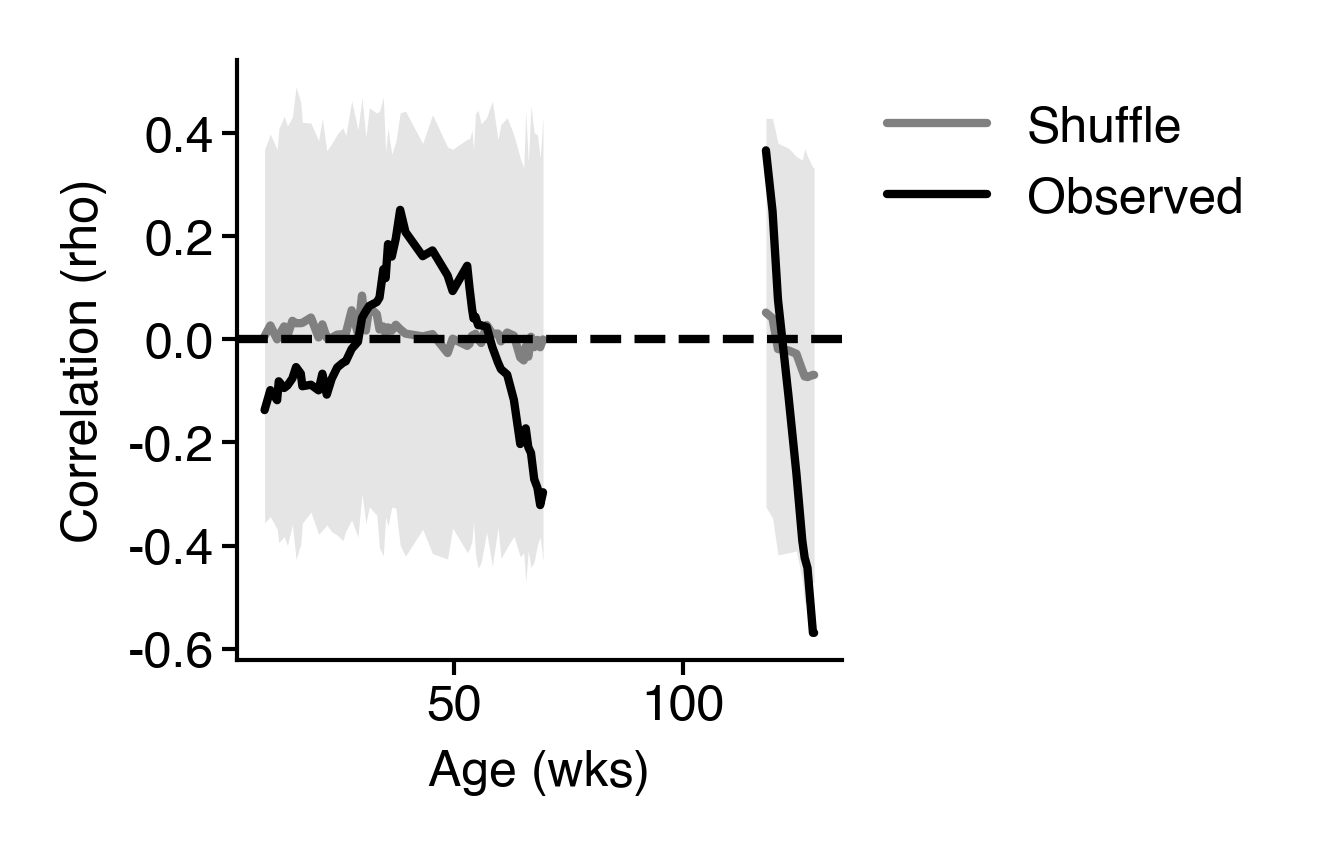

In [36]:
fig = figure(1.3, 1.3)
ax = fig.gca()

a = sns.lineplot(
    data=tmp_plt.query("avg < 100"),
    x="avg",
    y="value",
    errorbar=("sd", 2),
    ax=ax,
    err_kws=dict(lw=0),
    color="gray",
    label="Shuffle",
)
a = sns.lineplot(
    data=tmp_plt.query("avg > 100"),
    x="avg",
    y="value",
    errorbar=("sd", 2),
    ax=a,
    err_kws=dict(lw=0),
    color="gray",
)
a = (
    sliding_corr_df.set_index("avg")
    .loc[:100]["corr"]
    .plot(ax=a, color="k", label="Observed")
)
a = sliding_corr_df.set_index("avg").loc[100:]["corr"].plot(ax=a, color="k", label="")
a.axhline(0, color="k", ls="--")
legend(a)
a.set(xlabel="Age (wks)", ylabel="Correlation (rho)")
sns.despine()
saver(fig, "death-predictor-correlations-v2");

## Try classifying early/late death times - on old data

In [40]:
n_classes = 2

reset_df = tmp_df.reset_index()

subset = reset_df[reset_df['age'].between(90, 200)]
subset_join = subset.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])

classes = pd.qcut(subset_join["Death"], n_classes, labels=False)
subset_join['classes'] = classes

In [41]:
accs = []
for seed in range(1_000):
    acc, p = compute_classifier(subset_join, seed=seed)
    accs.append(acc)
print(n_classes, round(np.log2(np.mean(accs) / (1 / n_classes)), 2))

2 -0.06


In [31]:
# shuffle
shuffs = []
for i in tqdm(range(1_000)):
    shuff_df = subset_join.copy()
    shuff_df['beh_age'] = shuff_df['beh_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
    # shuffle ages within age chunks rather than across everything to remove individual biases
    acc, p = compute_classifier(shuff_df, seed=i)
    shuffs.append(acc)
print(n_classes, round(np.log2(np.mean(shuffs) / (1 / n_classes)), 2))

  0%|          | 0/1000 [00:00<?, ?it/s]

2 -0.0


/tmp/ipykernel_25336/2412142652.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy")


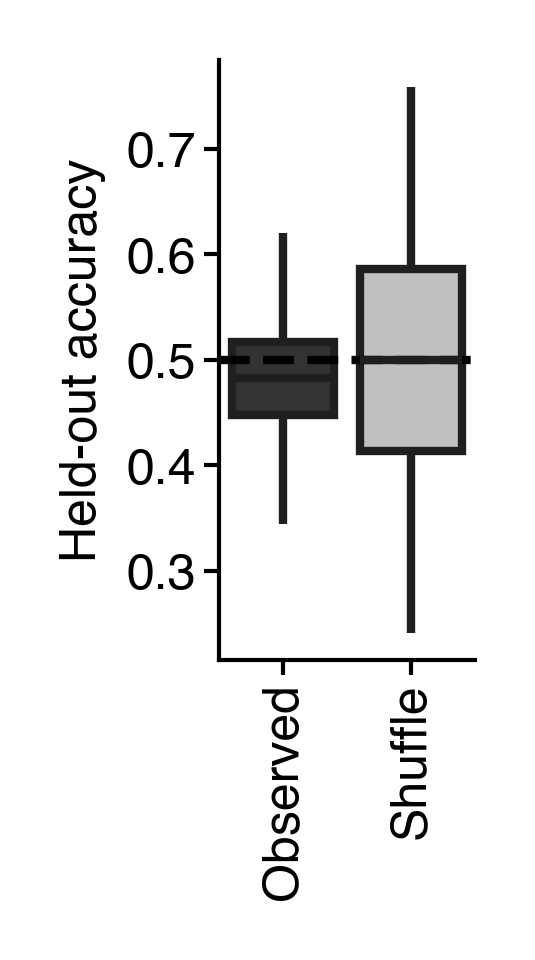

In [42]:
fig = figure(0.55, 1.3)
ax = sns.boxplot(data=[accs, shuffs], palette=['#333', 'silver'], showfliers=False, showcaps=False)
ax.axhline(1 / n_classes, color='k', ls='--')
ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy")
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "long-recordings-death-rank-classifier-via-bambi");

## Optimize 70wk model

In [43]:
def load_long_df2(n_bins: "Optional[int]" = 75):
    keep_syllables = np.loadtxt(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt",
        dtype=int,
    )
    df = pd.read_parquet(
        # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_counts_matrix_v00.parquet"
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_raw_counts_matrix_v00.parquet"
    )
    df = df[keep_syllables]
    mask = df.index.get_level_values("age") < 100
    df = df[mask].copy()

    masks = []
    for uuid in to_remove:
        m = df.reset_index()["uuid"].str.startswith(uuid)
        masks.append(m)
    mask = np.array(reduce(or_, masks), dtype=bool)
    df = df[~mask].copy()

    size_df = pd.read_parquet(
        # '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_mouse_area_df_v00.parquet'
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_males_mouse_area_df_v00.parquet"
    )
    mask = size_df.index.get_level_values("age") < 100
    size_df = size_df[mask].copy()
    age_cut = pd.cut(size_df.index.get_level_values("age"), 19)

    size_df.loc[size_df["quant_0.5"] == 0, "quant_0.5"] = np.nan
    sizes_col = size_df["quant_0.5"]
    sizes_col = (
        sizes_col.groupby("mouse")
        .apply(lambda df: df.sort_index(level="age").interpolate())
        .droplevel(0)
    )

    # sizes_col = zscore(sizes_col.groupby(age_cut, observed=True).transform(demean))
    sizes_col = sizes_col.groupby(age_cut, observed=True).transform(zscore)
    sizes_col = sizes_col.fillna(0)
    sizes_col = sizes_col.loc[df.index]

    # make sure df matches sizes
    df = df.loc[sizes_col.index]

    if n_bins is not None:
        # subsample the dataset
        cut, bins = pd.cut(df.index.get_level_values("age"), n_bins, retbins=True)
        # tmp_df = df.groupby(['mouse', cut], observed=True).first()
        tmp_df = (
            df.reset_index()
            .groupby(["mouse", cut], observed=True)
            .first()
            .reset_index()
            .drop(columns=["level_1"])
            .set_index(["age", "mouse", "subject_name", "session_name", "uuid", "date"])
        )
        # mid_age = [round(v.left, 2) for v in tmp_df.index.get_level_values(1)]
        # tmp_df['age'] = mid_age
        # tmp_df = tmp_df.set_index('age', append=True).droplevel(1)

        sizes_col = (
            sizes_col.reset_index().groupby(["mouse", cut], observed=True).first()
        )
        sizes_col = (
            sizes_col.reset_index()
            .drop(columns=["level_1"])
            .set_index(["age", "mouse", "subject_name", "session_name", "uuid", "date"])
        )
        sizes_col = sizes_col.loc[tmp_df.index, "quant_0.5"]
    else:
        tmp_df = df

    age = jnp.array(tmp_df.index.get_level_values("age"))
    syllable_counts_jax = jnp.array(tmp_df.astype(float))

    label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
    mouse_ids = label_encoder.fit_transform(
        sizes_col.index.get_level_values("mouse").to_numpy()[:, None]
    ).T

    sort_idx = np.argsort(syllable_counts_jax.sum(0))[::-1]

    return tmp_df, syllable_counts_jax, age, sizes_col, mouse_ids, sort_idx, label_encoder

In [44]:
tmp_df, syllable_counts_jax, age, size_col, mouse_ids, sort_idx, label_encoder = load_long_df2(None)

In [45]:
cats = label_encoder.categories_[0]

In [46]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": size_col.to_numpy(),  # models > 1
    "mice": mouse_ids,
}

# age_sd = 0.04
age_sd = 10

hypparams = {
    "log_age": False,
    "min_age": 3,
    "max_age": 150,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 400,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "lr": 0.25,
    "n_opt_iter": 500,
}

In [21]:
random.seed(0)

grid = {
    'age_sd': np.linspace(5, 40, 8, dtype=float),
    # 'n_splines': [4, 5],
    'n_splines': [4],
    'scale': np.arange(25, 401, 25, dtype=int),
    # "n_development_splines": [4, 5],
    "n_development_splines": [5],
}

win_size = 15

bins, _bins = pd.cut(tmp_df.reset_index()['age'], 28, labels=False, retbins=True)

pg = list(ParameterGrid(grid))
random.shuffle(pg)

min_correlation = np.inf
min_correlation2 = np.inf

pbar = tqdm(pg)

out = []
for params in pbar:
    # remove the numpy class from scalars
    params = valmap(float, params)
    params['n_splines'] = int(params['n_splines'])
    params['n_development_splines'] = int(params['n_development_splines'])
    new_hypparams = merge(hypparams, params)

    try:
        tmp_mdl = fit_model(features, new_hypparams, 5)
        tmp_df['beh_age'] = tmp_mdl['bio_ages']
        corrs = compute_correlations(tmp_df, bin_age(tmp_df, _bins), death_map, group_size=4)
        params['death_corr'] = minimizer(corrs)
        sliding_corr_df = compute_correlations_v2(tmp_df.query('age >= 50'), win_size=win_size)
        sliding_corr_df = sliding_corr_df.groupby('avg').mean().reset_index()
        c = sliding_corr_df.dropna().query('n_samples > 10 & avg > 50').mean()['corr']

        params['death_corr2'] = c

        if params['death_corr'] < min_correlation:
            min_correlation = params['death_corr']
            pbar.set_description(f"{min_correlation:0.2f} - {min_correlation2:0.2f}")

        if params['death_corr2'] < min_correlation2:
            min_correlation2 = params['death_corr2']
            pbar.set_description(f"{min_correlation:0.2f} - {min_correlation2:0.2f}")

        out.append(params)
    except ValueError:
        pass

  0%|          | 0/128 [00:00<?, ?it/s]

In [22]:
opt_df = pd.DataFrame(out)
sorted_opt_df = opt_df.sort_values(by='death_corr2')
sorted_opt_df

age_sd  n_development_splines  n_splines  scale  death_corr  death_corr2
21      5.0                      5          4  125.0   -0.284550    -0.093527
121     5.0                      5          4  150.0   -0.277928    -0.087416
107    10.0                      5          4   50.0   -0.290608    -0.078031
0      20.0                      5          4   25.0   -0.287372    -0.077320
12      5.0                      5          4  100.0   -0.268538    -0.076889
..      ...                    ...        ...    ...         ...          ...
9      30.0                      5          4  375.0    0.234966     0.340786
2      35.0                      5          4  325.0    0.214179     0.344650
17     30.0                      5          4  400.0    0.245522     0.346054
19     35.0                      5          4  375.0    0.244106     0.350636
105    35.0                      5          4  350.0    0.220353     0.353268

[126 rows x 6 columns]

<Axes: xlabel='death_corr', ylabel='death_corr2'>

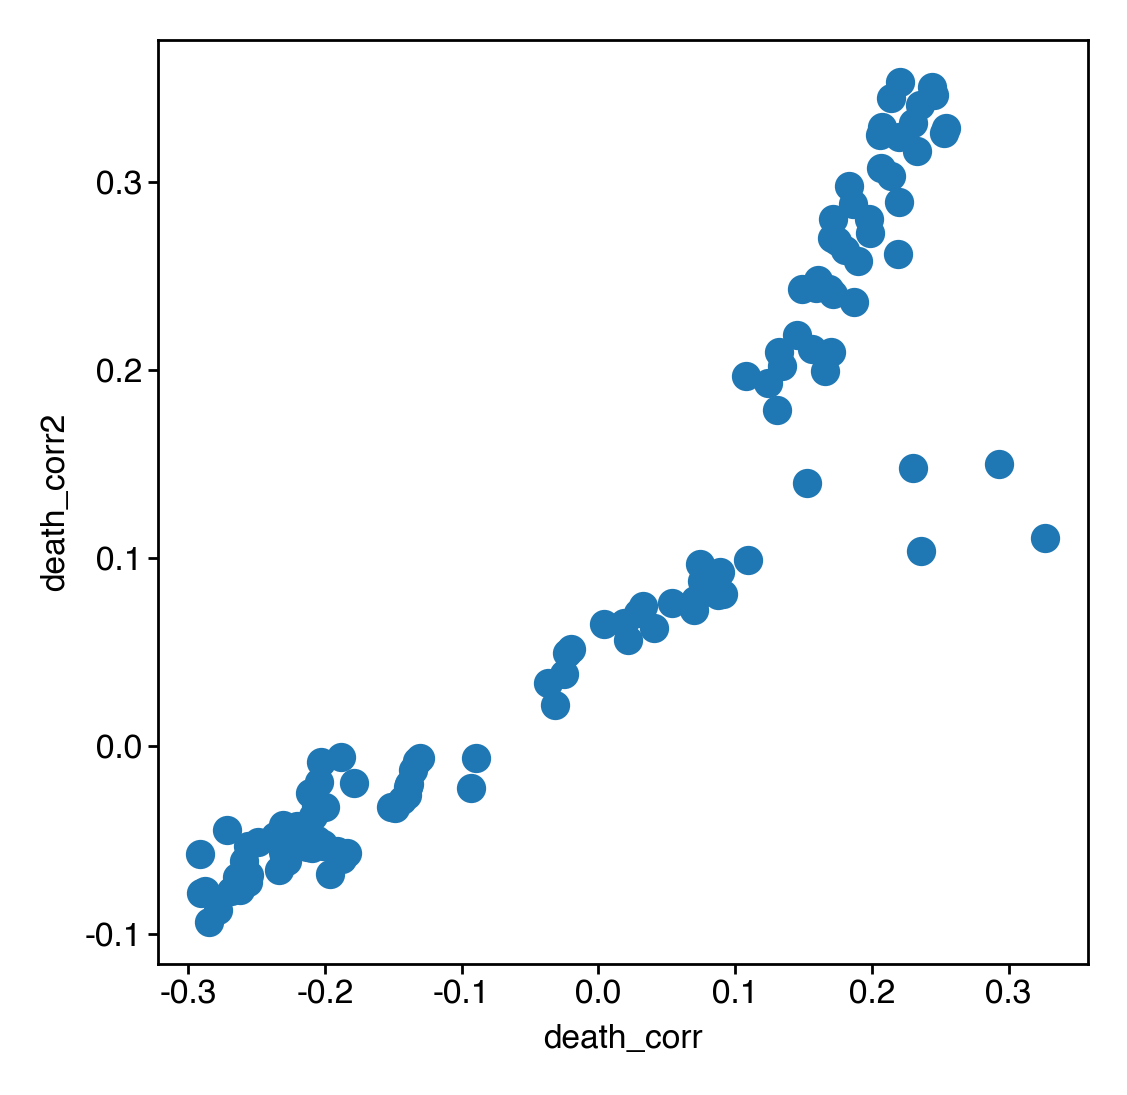

In [23]:
sorted_opt_df.plot(kind='scatter', x='death_corr', y='death_corr2')

<Axes: xlabel='scale', ylabel='age_sd'>

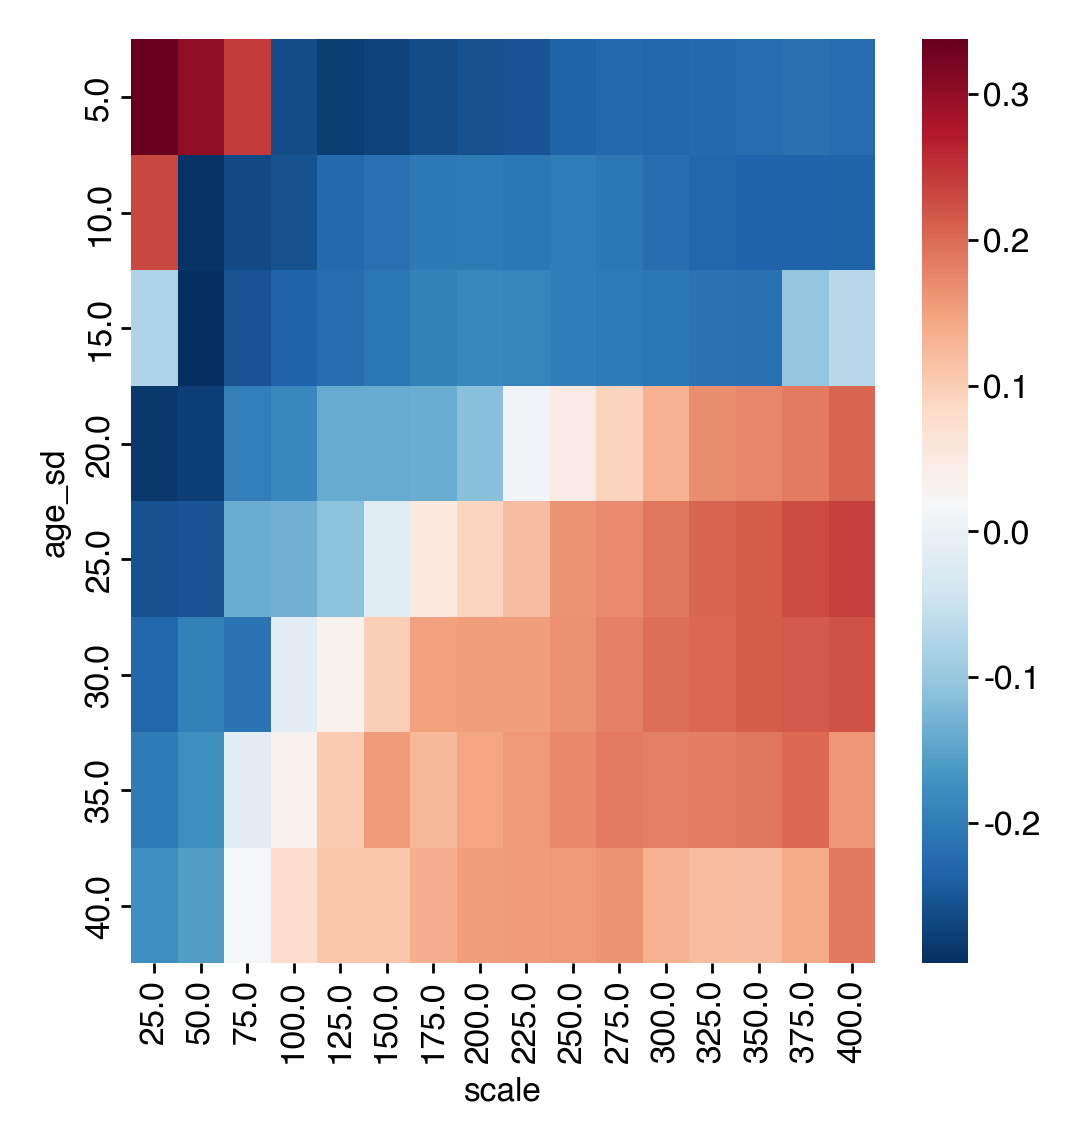

In [179]:
sns.heatmap(pd.pivot_table(opt_df, index='age_sd', columns='scale', values='death_corr'), cmap='RdBu_r')

<Axes: xlabel='scale', ylabel='age_sd'>

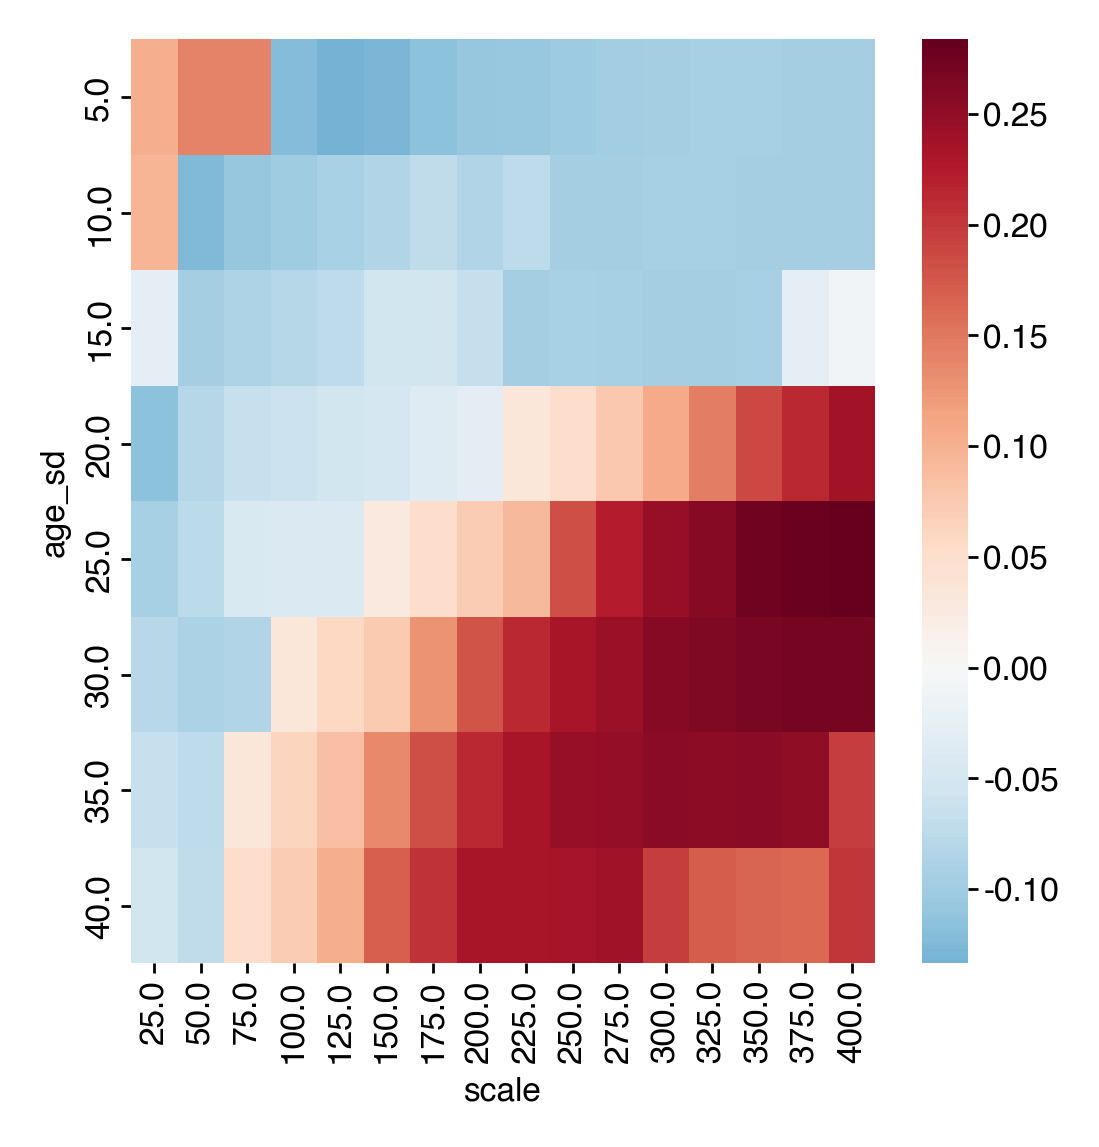

In [180]:
sns.heatmap(pd.pivot_table(opt_df, index='age_sd', columns='scale', values='death_corr2'), cmap='RdBu_r', center=0)

<Axes: xlabel='scale'>

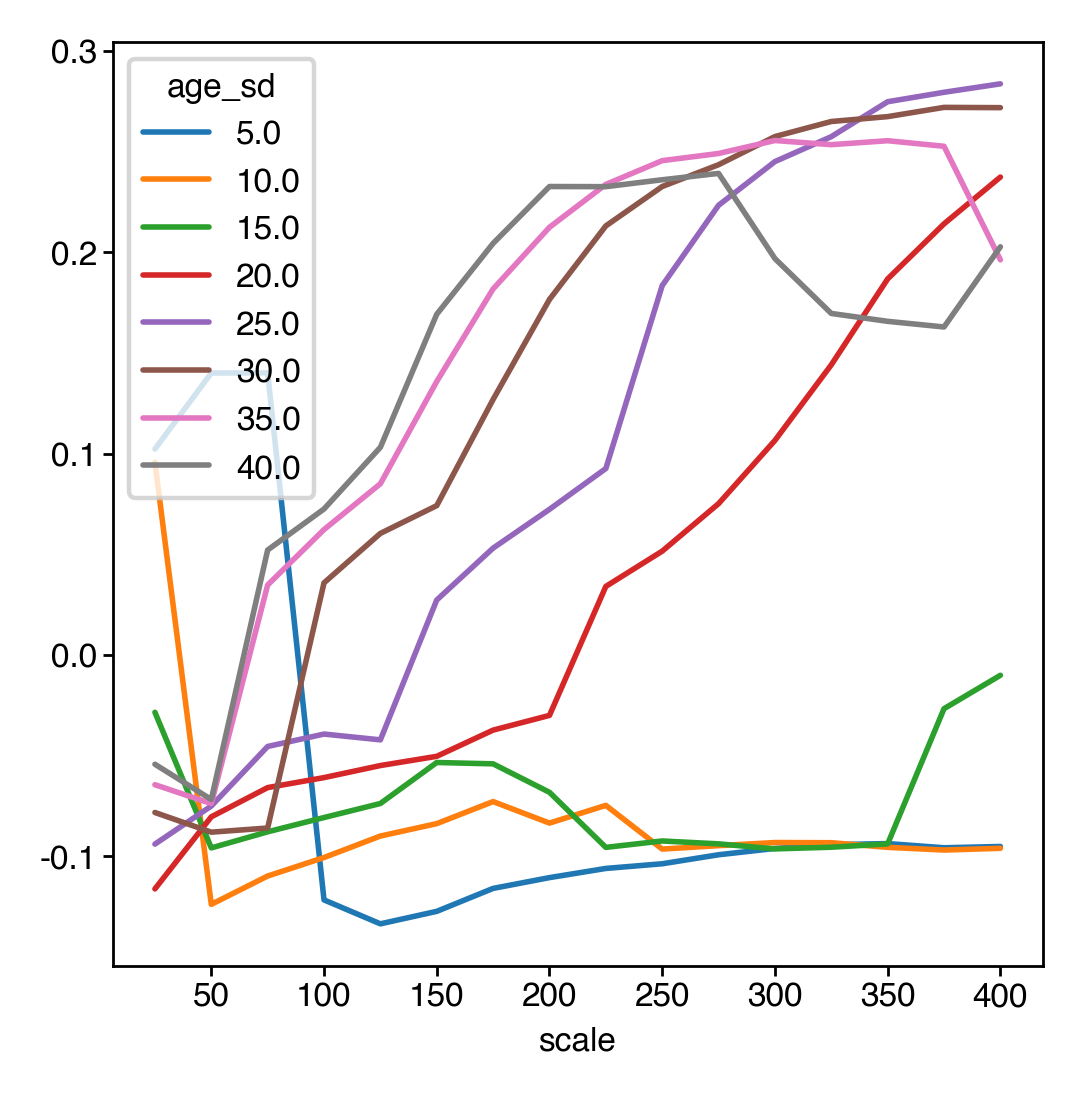

In [181]:
pd.pivot_table(opt_df, index='age_sd', columns='scale', values='death_corr2').T.plot()

<Axes: xlabel='age_sd'>

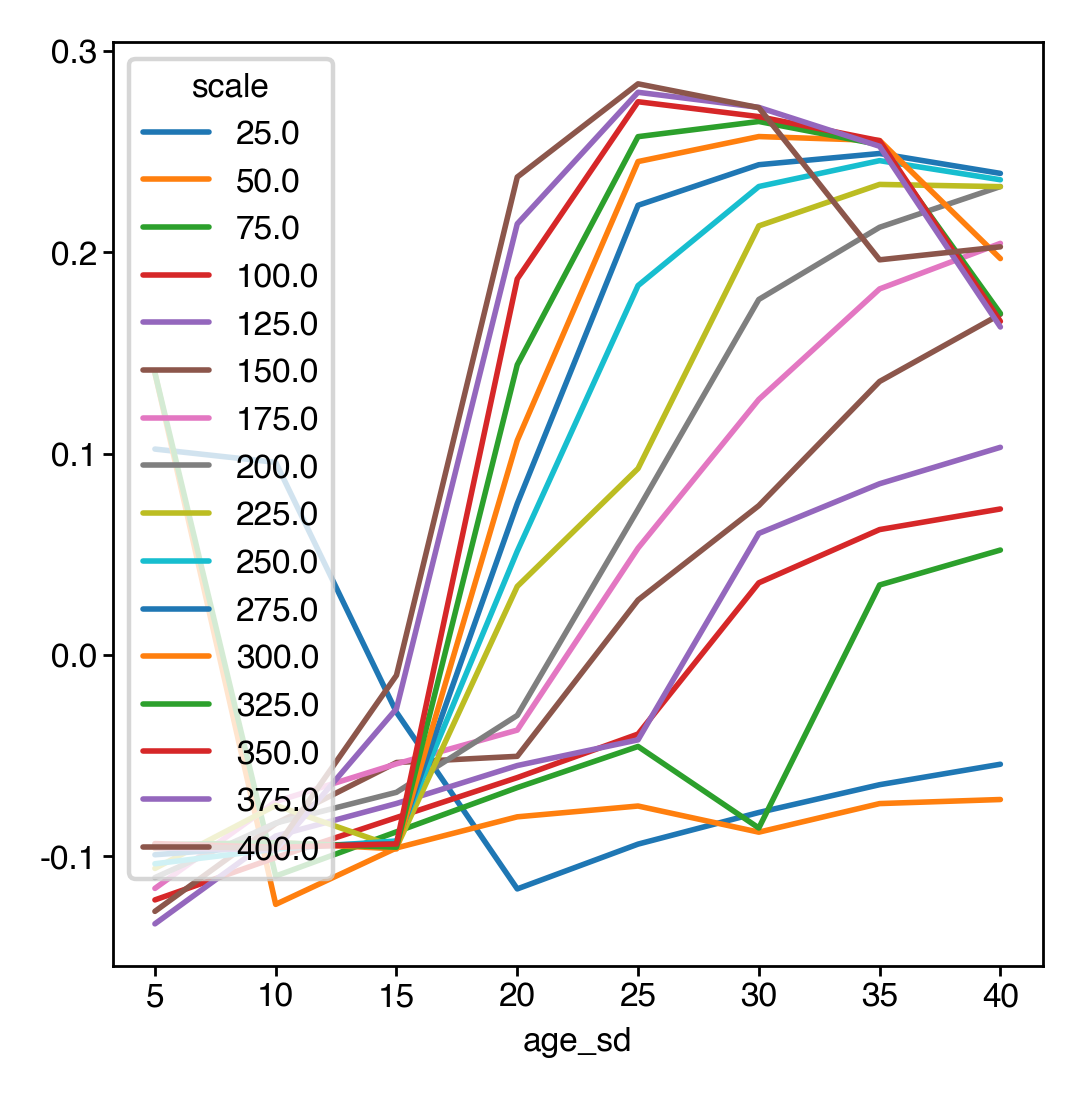

In [182]:
pd.pivot_table(opt_df, index='age_sd', columns='scale', values='death_corr2').plot()

<Axes: xlabel='scale', ylabel='n_development_splines'>

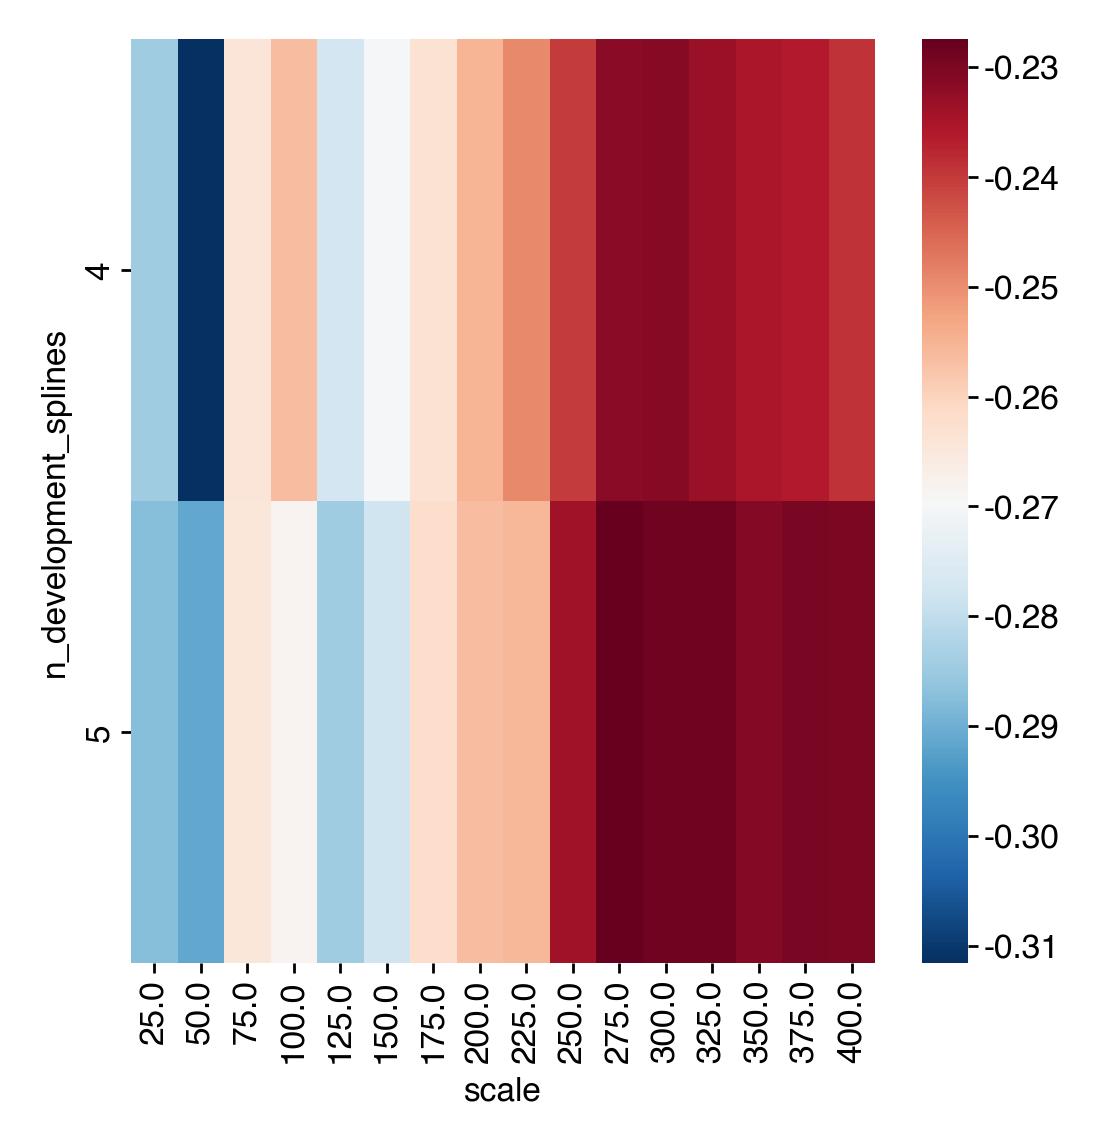

In [183]:
sns.heatmap(pd.pivot_table(opt_df, index='n_development_splines', columns='scale', values='death_corr', aggfunc='min'), cmap='RdBu_r')

<Axes: xlabel='scale', ylabel='n_development_splines'>

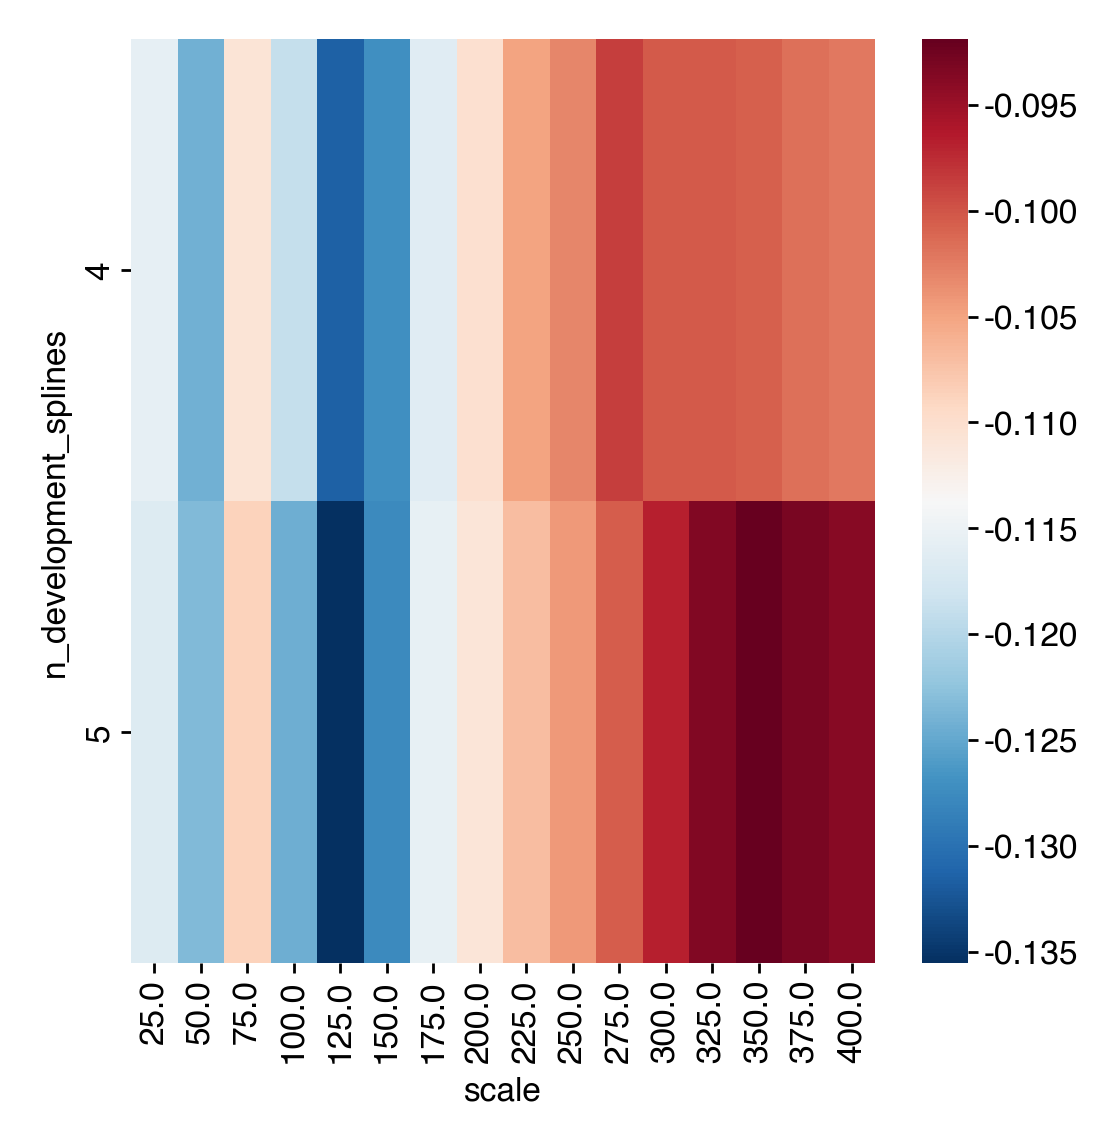

In [184]:
sns.heatmap(pd.pivot_table(opt_df, index='n_development_splines', columns='scale', values='death_corr2', aggfunc='min'), cmap='RdBu_r')

<Axes: xlabel='age_sd', ylabel='n_development_splines'>

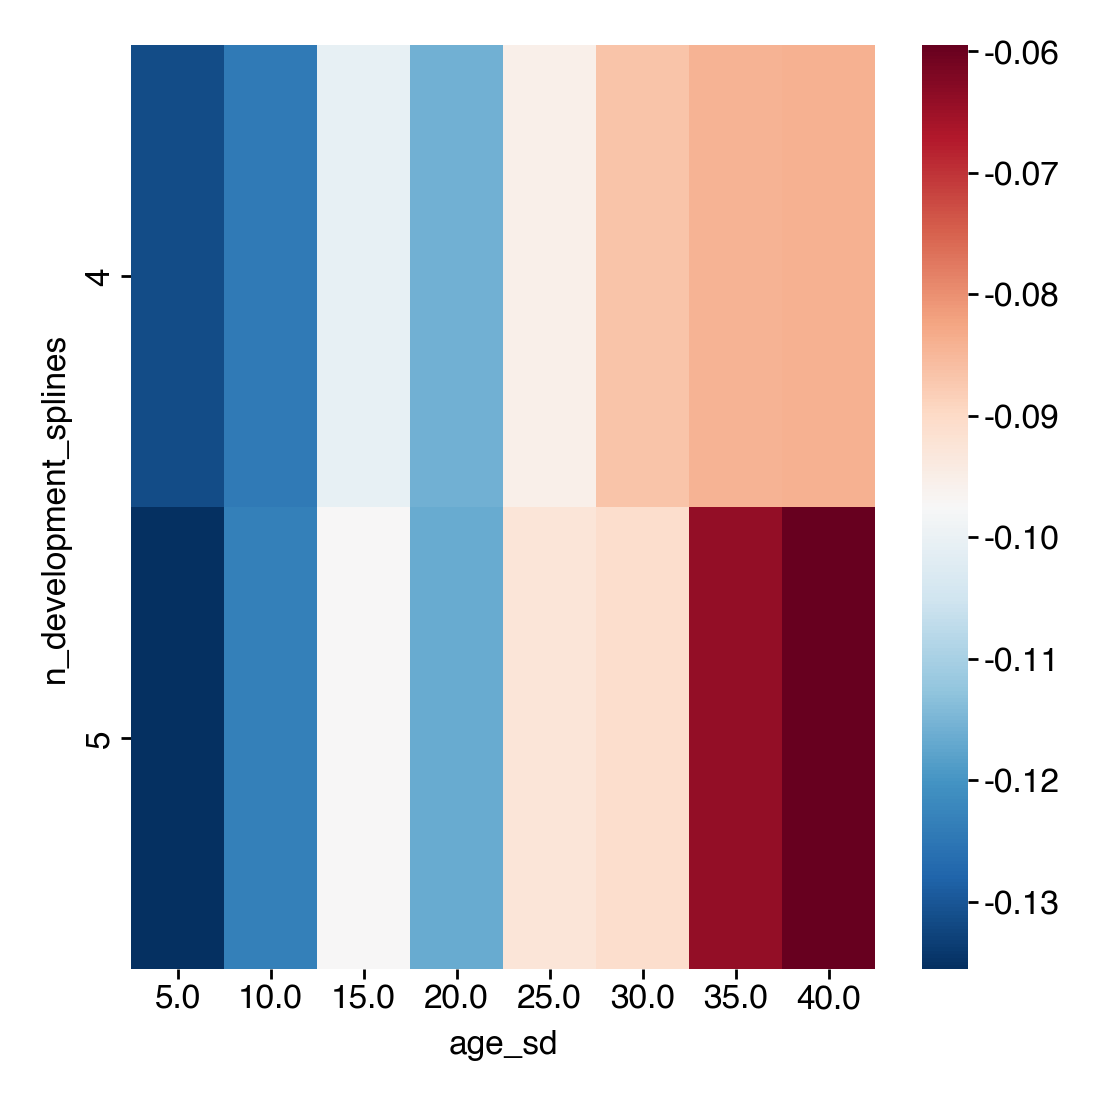

In [185]:
sns.heatmap(pd.pivot_table(opt_df, index='n_development_splines', columns='age_sd', values='death_corr2', aggfunc='min'), cmap='RdBu_r')

## Fit 70wk model to optimal params

In [47]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": size_col.to_numpy(),  # models > 1
    "mice": mouse_ids,
}

# age_sd = 20
age_sd = 5

hypparams = {
    "log_age": False,
    "min_age": 3,
    "max_age": 120,
    # "max_age": 80,
    "age_sd": age_sd,
    "n_age_samples": 1000,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 5,
    # "scale": 25,
    "scale": 125,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "lr": 0.25,
    "n_opt_iter": 700,
}

In [48]:
mdl = fit_model(features, hypparams, 5)

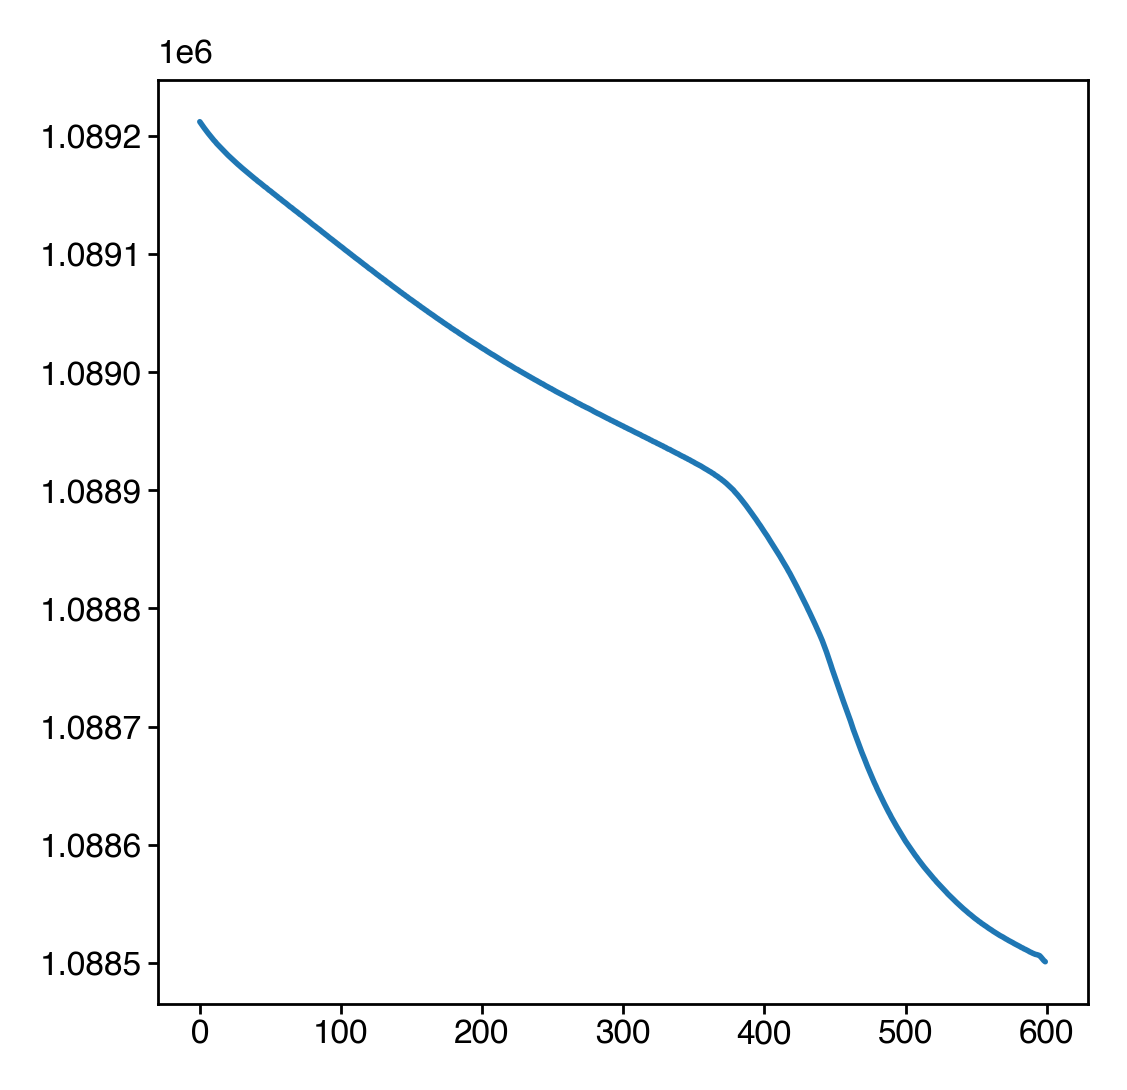

In [49]:
plt.plot(mdl['loss'][100:])

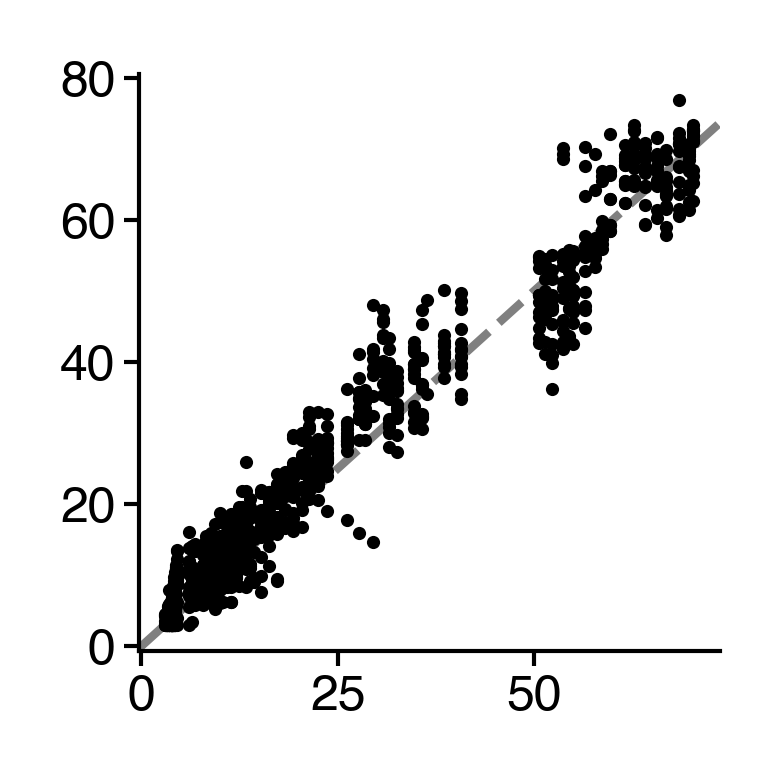

In [50]:
fig = figure(1.25, 1.25)
plt.scatter(mdl['true_ages'], mdl['bio_ages'], c='k', s=2.5, lw=0)
a = add_identity(plt.gca(), c='gray', ls='--', zorder=-1)
sns.despine()

In [51]:
tmp_df['beh_age'] = mdl['bio_ages']

In [24]:
sliding_corr_df = pd.concat(
    compute_correlations_v3(tmp_df, win_size=15, n_samples=50, seed=i).drop_duplicates(
        subset=["avg"]
    )
    for i in tqdm(range(10))
)
sliding_corr_df = sliding_corr_df.groupby("start").mean().reset_index()

  0%|          | 0/10 [00:00<?, ?it/s]

In [47]:
# shuffle
shuffs = []
for i in tqdm(range(100)):
    shuff_df = tmp_df.copy().reset_index(level="age")
    # shuffle ages within age chunks rather than across everything to remove individual biases
    shuff_df["beh_age"] = shuff_df.groupby(
        pd.cut(shuff_df["age"], 21, labels=False), observed=True
    )["beh_age"].transform(
        lambda x: x.sample(frac=1, replace=False, random_state=i).to_numpy()
    )
    # shuffle all ages uniformly
    # shuff_df["beh_age"] = (
    #     shuff_df["beh_age"].sample(frac=1, replace=False, random_state=i).to_numpy()
    # )
    _df = compute_correlations_v3(
        shuff_df, win_size=15, n_samples=50, seed=i
    ).drop_duplicates(subset=["avg"])
    shuffs.append(_df.set_index("avg")["corr"].rename(i))

shuffs = pd.concat(shuffs, axis=1)
tmp_plt = shuffs.reset_index().melt(id_vars="avg")

  0%|          | 0/100 [00:00<?, ?it/s]

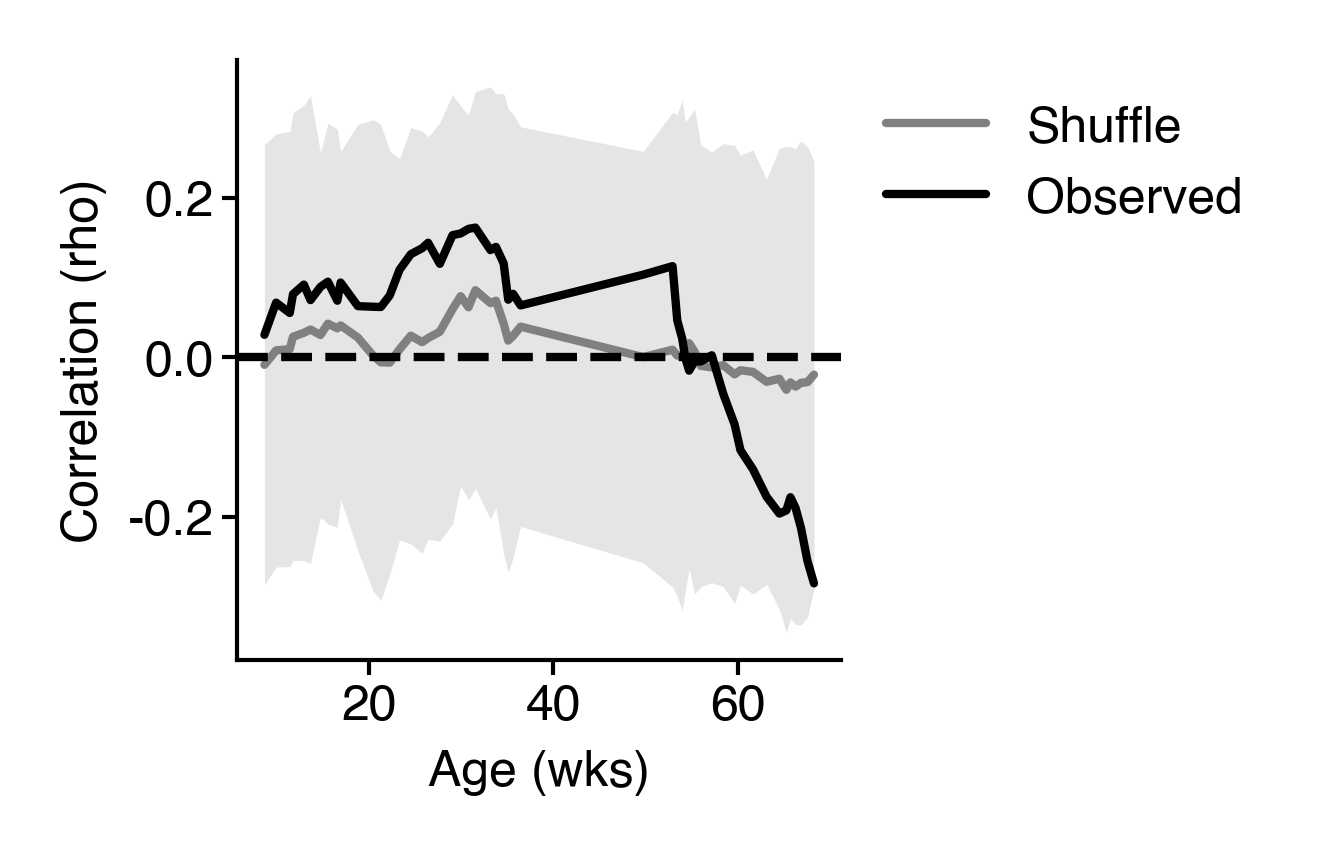

In [48]:
fig = figure(1.3, 1.3)
ax = fig.gca()

a = sns.lineplot(
    data=tmp_plt.query("avg < 100"),
    x="avg",
    y="value",
    errorbar=("sd", 2),
    ax=ax,
    err_kws=dict(lw=0),
    color="gray",
    label="Shuffle",
)
a = sns.lineplot(
    data=tmp_plt.query("avg > 100"),
    x="avg",
    y="value",
    errorbar=("sd", 2),
    ax=a,
    err_kws=dict(lw=0),
    color="gray",
)
a = (
    sliding_corr_df.set_index("avg")
    .loc[:100]["corr"]
    .plot(ax=a, color="k", label="Observed")
)
a = sliding_corr_df.set_index("avg").loc[100:]["corr"].plot(ax=a, color="k", label="")
a.axhline(0, color="k", ls="--")
legend(a)
a.set(xlabel="Age (wks)", ylabel="Correlation (rho)")
sns.despine()
saver(fig, "death-predictor-correlations-up-to-70-wk-v2");

In [29]:
# shuffle
shuffs = []
for i in tqdm(range(30)):
    # shuff_df = tmp_df.copy()#.reset_index()
    # shuff_df['beh_age'] = shuff_df['beh_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
    shuff_df = tmp_df.query('age >= 50').copy().reset_index(level="age")
    # shuffle ages within age chunks rather than across everything to remove individual biases
    shuff_df["beh_age"] = shuff_df.groupby(
        pd.cut(shuff_df["age"], 5, labels=False), observed=True
    )["beh_age"].transform(
        lambda x: x.sample(frac=1, replace=False, random_state=i).to_numpy()
    )
    _df = compute_correlations_v2(shuff_df, win_size=15)
    _df = _df.query('n_samples > 50')
    _df = _df.groupby('avg').mean().reset_index()
    shuffs.append(_df.set_index('avg')['corr'].rename(i))

shuffs = pd.concat(shuffs, axis=1)
tmp_plt = shuffs.reset_index().melt(id_vars='avg')

  0%|          | 0/30 [00:00<?, ?it/s]

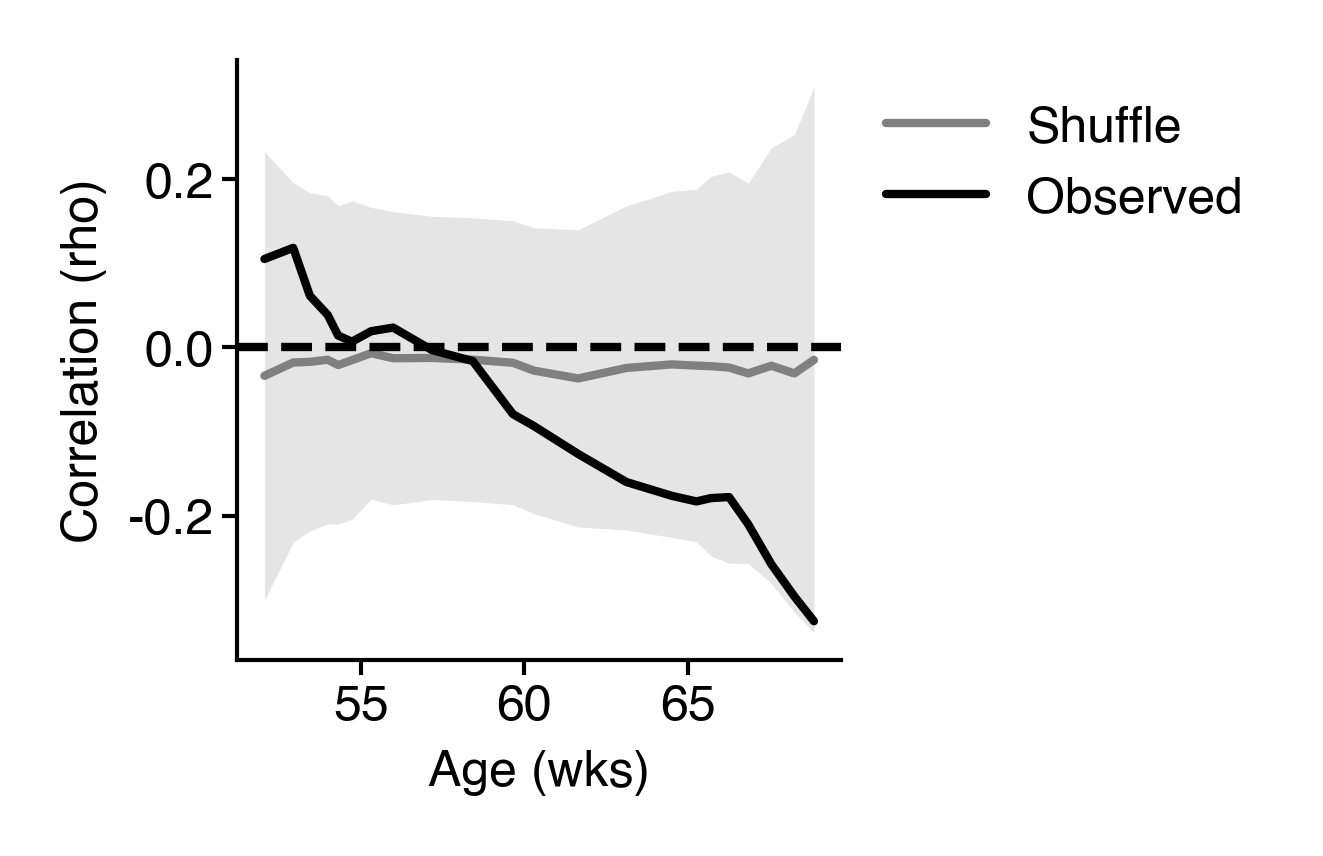

In [30]:
fig = figure(1.3, 1.3)
ax = fig.gca()

sliding_corr_df = compute_correlations_v2(tmp_df.query('age > 50'), win_size=15)
sliding_corr_df = sliding_corr_df.query('n_samples > 50')
sliding_corr_df = sliding_corr_df.groupby('avg').mean().reset_index()

a = sns.lineplot(data=tmp_plt, x='avg', y='value', errorbar=("sd", 2), ax=ax, err_kws=dict(lw=0), color='gray', label="Shuffle")
a = sliding_corr_df.set_index('avg')['corr'].plot(ax=a, color='k', label="Observed")
a.axhline(0, color='k', ls='--')
legend(a)
a.set(xlabel="Age (wks)", ylabel="Correlation (rho)")
sns.despine()
# saver(fig, "death-predictor-correlations-up-to-70-wk");

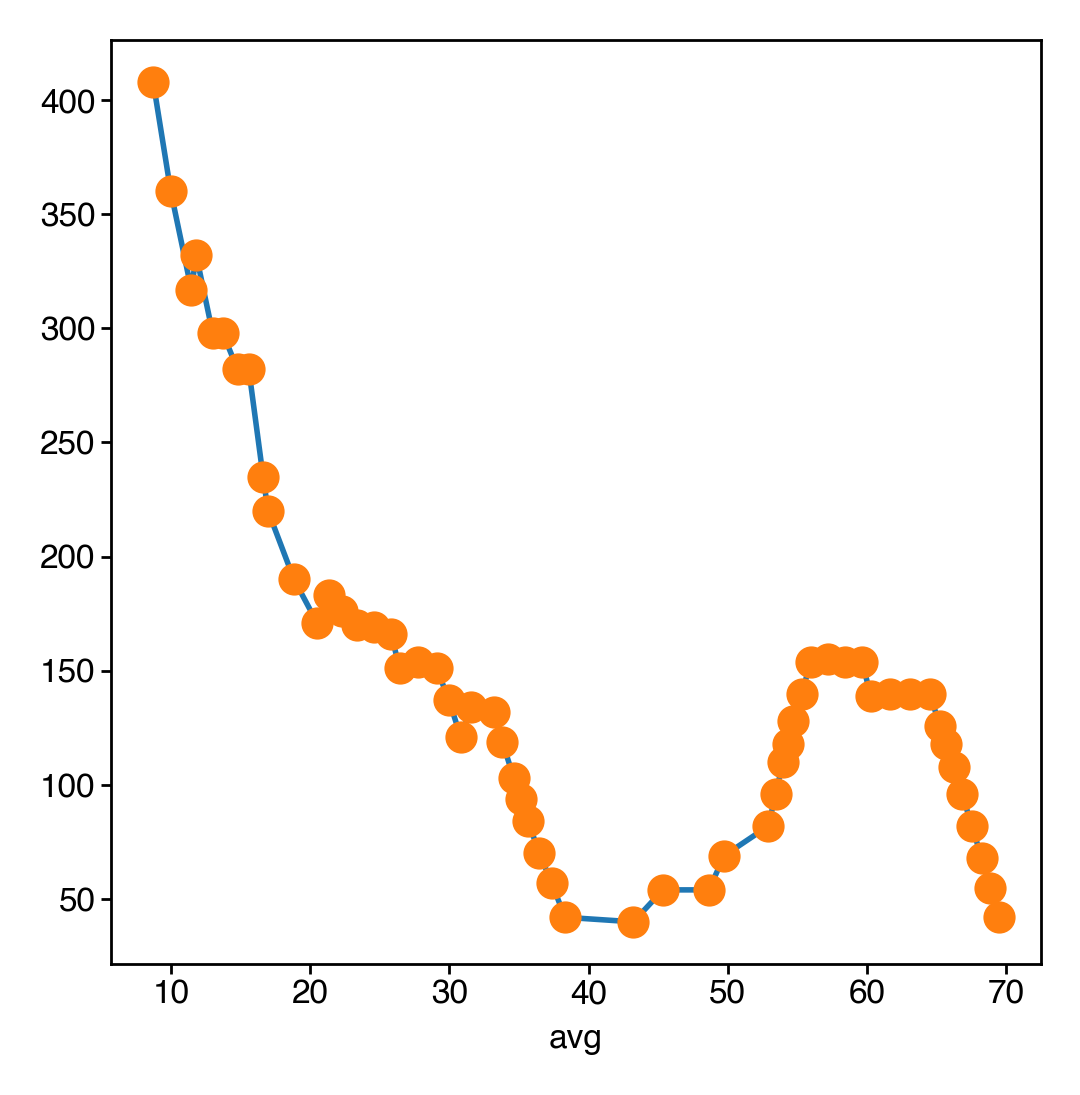

In [204]:
sliding_corr_df.set_index('avg')['n_samples'].plot()
plt.plot(sliding_corr_df.set_index('avg')['n_samples'], 'o')

## Try classifying early/late death times 

In [121]:
n_classes = 4

reset_df = tmp_df.reset_index()

subset = reset_df[reset_df['age'].between(57, 71)]
subset_join = subset.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])

classes = pd.qcut(subset_join["Death"], n_classes, labels=False)
subset_join['classes'] = classes

In [122]:
accs = []
for seed in range(1_000):
    acc, p = compute_classifier(subset_join, seed=seed)
    accs.append(acc)
print(n_classes, round(np.log2(np.mean(accs) / (1 / n_classes)), 2))

4 0.57


In [123]:
# shuffle
shuffs = []
for i in tqdm(range(1_000)):
    shuff_df = subset_join.copy()
    shuff_df['beh_age'] = shuff_df['beh_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
    # shuffle ages within age chunks rather than across everything to remove individual biases
    acc, p = compute_classifier(shuff_df, seed=i)
    shuffs.append(acc)
print(n_classes, round(np.log2(np.mean(shuffs) / (1 / n_classes)), 2))

  0%|          | 0/1000 [00:00<?, ?it/s]

4 -0.02


/tmp/ipykernel_25336/1913065548.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.42))


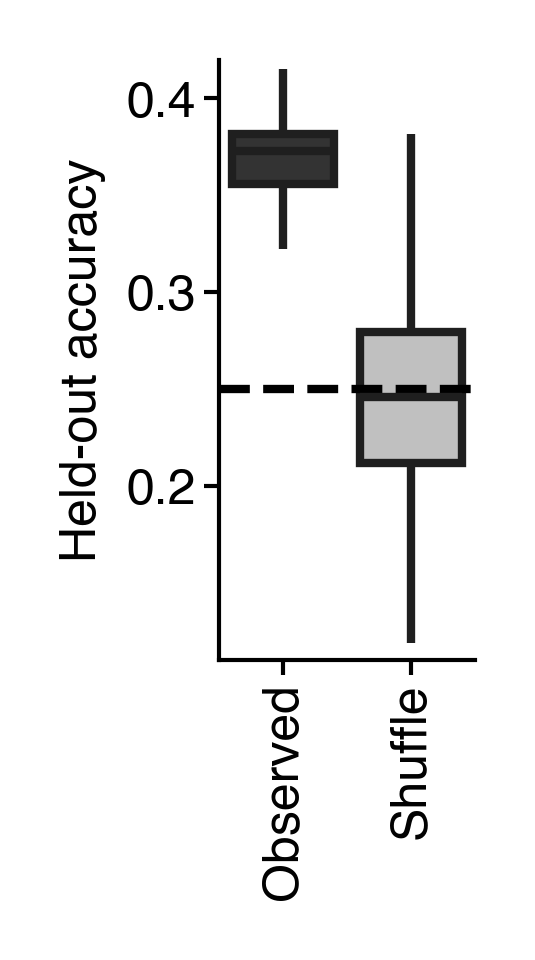

In [126]:
fig = figure(0.55, 1.3)
ax = sns.boxplot(data=[accs, shuffs], palette=['#333', 'silver'], showfliers=False, showcaps=False)
ax.axhline(1 / n_classes, color='k', ls='--')
ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.42))
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "death-rank-classifier-via-bambi");

### Younger ages

In [127]:
n_classes = 4

reset_df = tmp_df.reset_index()

subset = reset_df[reset_df['age'].between(0, 20)]
subset_join = subset.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])

classes = pd.qcut(subset_join["Death"], n_classes, labels=False)
subset_join['classes'] = classes

In [128]:
accs = []
for seed in range(1_000):
    acc, p = compute_classifier(subset_join, seed=seed)
    accs.append(acc)
print(n_classes, round(np.log2(np.mean(accs) / (1 / n_classes)), 2))

4 -0.04


In [129]:
# shuffle
shuffs = []
for i in tqdm(range(1_000)):
    shuff_df = subset_join.copy()
    shuff_df['beh_age'] = shuff_df['beh_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
    # shuffle ages within age chunks rather than across everything to remove individual biases
    acc, p = compute_classifier(shuff_df, seed=i)
    shuffs.append(acc)
print(n_classes, round(np.log2(np.mean(shuffs) / (1 / n_classes)), 2))

  0%|          | 0/1000 [00:00<?, ?it/s]

4 -0.06


/tmp/ipykernel_25336/2087879615.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.42))


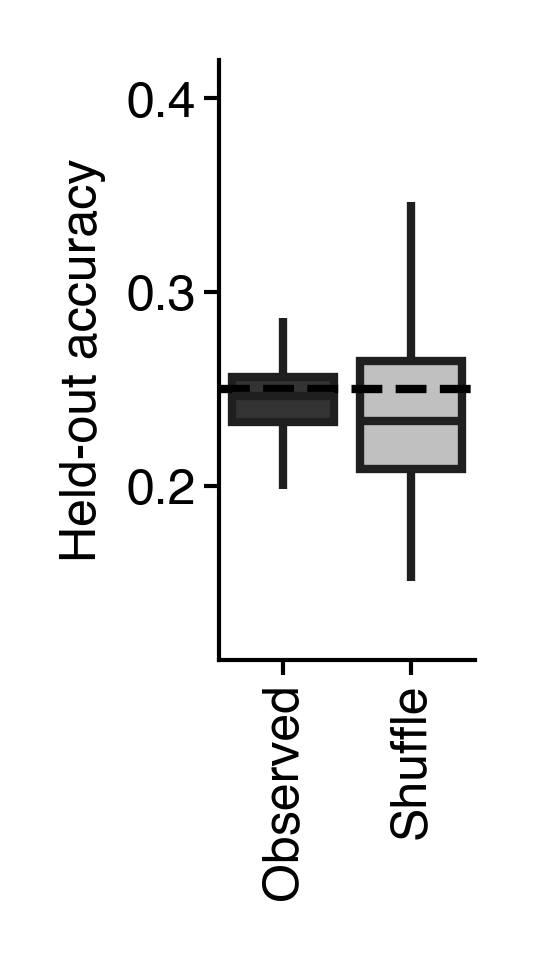

In [130]:
fig = figure(0.55, 1.3)
ax = sns.boxplot(data=[accs, shuffs], palette=['#333', 'silver'], showfliers=False, showcaps=False)
ax.axhline(1 / n_classes, color='k', ls='--')
ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.42))
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "young-age-death-rank-classifier-via-bambi");

### Middler ages

In [131]:
n_classes = 4

reset_df = tmp_df.reset_index()

subset = reset_df[reset_df['age'].between(20, 56)]
subset_join = subset.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])

classes = pd.qcut(subset_join["Death"], n_classes, labels=False)
subset_join['classes'] = classes

In [132]:
accs = []
for seed in range(1_00):
    acc, p = compute_classifier(subset_join, seed=seed)
    accs.append(acc)
print(n_classes, round(np.log2(np.mean(accs) / (1 / n_classes)), 2))

4 0.28


In [133]:
# shuffle
shuffs = []
for i in tqdm(range(1_00)):
    shuff_df = subset_join.copy()
    shuff_df['beh_age'] = shuff_df['beh_age'].sample(frac=1, replace=False, random_state=i).to_numpy()
    # shuffle ages within age chunks rather than across everything to remove individual biases
    acc, p = compute_classifier(shuff_df, seed=i)
    shuffs.append(acc)
print(n_classes, round(np.log2(np.mean(shuffs) / (1 / n_classes)), 2))

  0%|          | 0/100 [00:00<?, ?it/s]

4 -0.03


/tmp/ipykernel_25336/627085734.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.42))


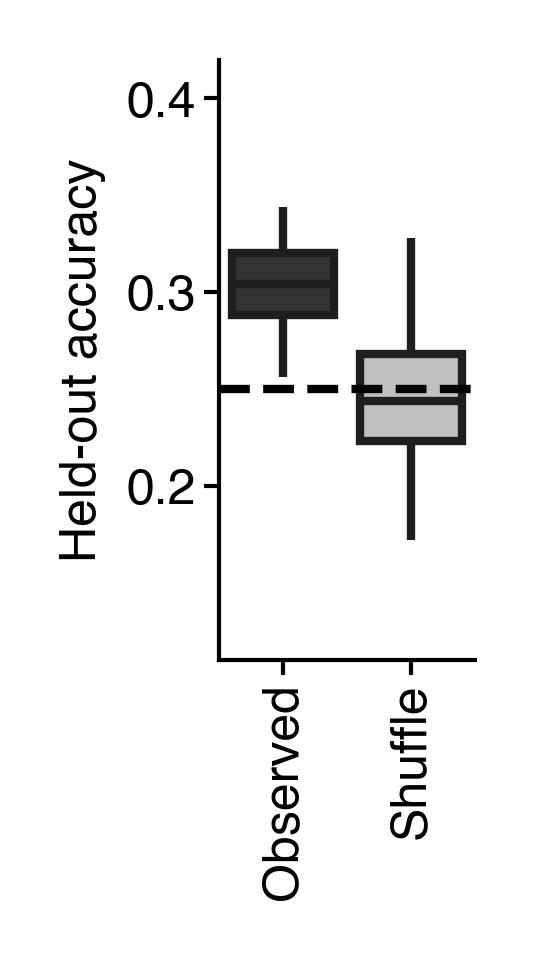

In [134]:
fig = figure(0.55, 1.3)
ax = sns.boxplot(data=[accs, shuffs], palette=['#333', 'silver'], showfliers=False, showcaps=False)
ax.axhline(1 / n_classes, color='k', ls='--')
ax.set(xticklabels=["Observed", "Shuffle"], ylabel="Held-out accuracy", ylim=(0.11, 0.42))
ax.tick_params(axis='x', rotation=90)
sns.despine()
saver(fig, "mid-age-death-rank-classifier-via-bambi");

## Compute syllable correlations

In [34]:
from statsmodels.stats.multitest import multipletests

In [35]:
# load syllable class names
class_df = pd.read_csv(
    "../v11_syllable_labels_v2.csv", index_col="Original ID", usecols=range(4)
)

def get_class(syll):
    return class_df.loc[syll, "Class"]

In [36]:
def compute_syllable_correlations(df, syllable, win_size=15):
    reset_df = df.reset_index()

    sliding_corr_df = []

    for w in sliding_window(win_size, range(3, 71)):
        subset = reset_df[reset_df['age'].between(w[0], w[-1])]
        subset_join = subset.merge(
            death_map.reset_index(), left_on="mouse", right_on="id"
        ).dropna(subset=["Death"])
        subset_join.groupby('mouse').mean(numeric_only=True).join(death_map.rename_axis(index='mouse')[['Death']])

        # proven that this gives the same result as casting the datetime to int
        # res = spearmanr(subset_join[syllable], subset_join["Death"].rank(method="min"))
        res = spearmanr(subset_join[syllable], subset_join["Death"].rank(method="dense"))
        sliding_corr_df.append(
            dict(
                corr=res.correlation,
                p=res.pvalue,
                start=w[0],
                stop=w[-1],
                avg=subset["age"].mean(),
                n_samples=len(subset),
            )
        )
    sliding_corr_df = pd.DataFrame(sliding_corr_df)
    return sliding_corr_df

In [37]:
syllables = tmp_df.columns[:-1]

In [38]:
all_scs = {}
for s in syllables:
    all_scs[s] = compute_syllable_correlations(tmp_df.query('age >= 50'), s).dropna().query('n_samples > 50')

avg_d = valmap(lambda x: x['corr'].mean(), all_scs)
avg_d = dict(sorted(avg_d.items(), key=lambda k: k[1]))

In [39]:
reset_df = tmp_df.query('age >= 50').reset_index()

subset_join = reset_df.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])
subset_join.groupby('mouse').mean(numeric_only=True).join(death_map.rename_axis(index='mouse')[['Death']])

corr_and_p = []
for s in syllables:
    # res = spearmanr(subset_join[s], subset_join["Death"].rank(method="dense"))
    res = spearmanr(subset_join[s], pd.qcut(subset_join["Death"], 4, labels=False))
    corr_and_p.append(dict(syllable=s, c=res.statistic, p=res.pvalue))
corr_and_p = pd.DataFrame(corr_and_p)
corr_and_p['adj_p'] = multipletests(corr_and_p['p'].to_numpy(), method='bonferroni')[1]
corr_and_p = corr_and_p.set_index("syllable")

In [40]:
group_class_df = class_df.join(corr_and_p).join(pd.Series(avg_d, name="averaged_c")).sort_values(by='c')

In [42]:
# group_class_df.to_csv('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/stats/long-v1-syllable-death-correlations.csv')

In [43]:
group_class_df

Class           Short description  \
Original ID                                            
0                Rear up                         NaN   
77               Rear up                         NaN   
11                   Run                         NaN   
55               Rear up                         NaN   
10               Rear up                         NaN   
71                  Walk                         NaN   
95               Rear up                         NaN   
25                  Walk                         NaN   
12               Rear up                         NaN   
18                  Walk                         NaN   
44                 Pause                         NaN   
52               Rear up                         NaN   
4                    Run                    Slow run   
67                  Walk                         NaN   
69                  Walk                         NaN   
17               Rear up                         NaN   
42                  Walk                         NaN   
70                   Run                         Run   
2                    Run                         Run   
63               Rear up                         NaN   
97               Rear up                         NaN   
66                  Walk                        Walk   
98             Rear down                         NaN   
61                  Walk                        Walk   
14           Investigate                 Investigate   
53                  Walk               Walk or pause   
60               Rear up                         NaN   
13               Rear up                         NaN   
79               Rear up                         NaN   
64           Investigate  Investigate and turn right   
9              Rear down                   Rear down   
54               Rear up                         NaN   
50                 Groom                         NaN   
30               Rear up                         NaN   
36                 Pause                       Pause   
83           Investigate                         NaN   
85               Rear up                         NaN   
32               Rear up                         NaN   
84               Rear up                         NaN   
16                 Groom                       Groom   
68                 Groom                       Groom   
33             Rear down                         NaN   
27               Rear up                         NaN   
93               Rear up                         NaN   
5                   Walk                        Walk   
74           Investigate             Pause and sniff   
49             Rear down                         NaN   
39           Investigate                         NaN   
73           Investigate                         NaN   
62               Scrunch                     Scrunch   
41               Rear up                         NaN   
59                 Pause                       Pause   
76               Rear up                         NaN   
6                Rear up                         NaN   
24           Investigate                         NaN   
7                    Run                  Short dart   
90             Rear down                   Rear down   
23                 Pause                       Pause   

                                              Long description         c  \
Original ID                                                                
0                                                          NaN -0.360907   
77                                                         NaN -0.309123   
11                                                         NaN -0.237926   
55                                                         NaN -0.224524   
10                                                         NaN -0.211188   
71                                                         NaN -0.146547   
95           Mix of rear up and investigation, bec

In [44]:
sig_examples = group_class_df.query('adj_p < 0.05').iloc[[0, 1, -2, -1]]
sig_examples

Class Short description  \
Original ID                                
0              Rear up               NaN   
77             Rear up               NaN   
90           Rear down         Rear down   
23               Pause             Pause   

                                              Long description         c  \
Original ID                                                                
0                                                          NaN -0.360907   
77                                                         NaN -0.309123   
90                               Rear down away from the walls  0.267147   
23           Pause, with head ducking down. Some animals mo...  0.286890   

                        p     adj_p  averaged_c  
Original ID                                      
0            1.520778e-07  0.000009   -0.385554  
77           8.435238e-06  0.000489   -0.325943  
90           1.312565e-04  0.007613    0.194420  
23           3.809753e-05  0.002210    0.275478

In [45]:
non_sig_examples = group_class_df.iloc[len(group_class_df) // 2:len(group_class_df) // 2 + 2]
non_sig_examples

Class           Short description  \
Original ID                                            
64           Investigate  Investigate and turn right   
9              Rear down                   Rear down   

                                              Long description         c  \
Original ID                                                                
64           A sort of head bob investigation with a right ... -0.026509   
9                                                          NaN -0.010266   

                    p  adj_p  averaged_c  
Original ID                               
64           0.709436    1.0   -0.033128  
9            0.885285    1.0   -0.093033

In [46]:
subset_join["death_rank"] = pd.qcut(subset_join["Death"], n_classes, labels=False)
ss = subset_join.copy()

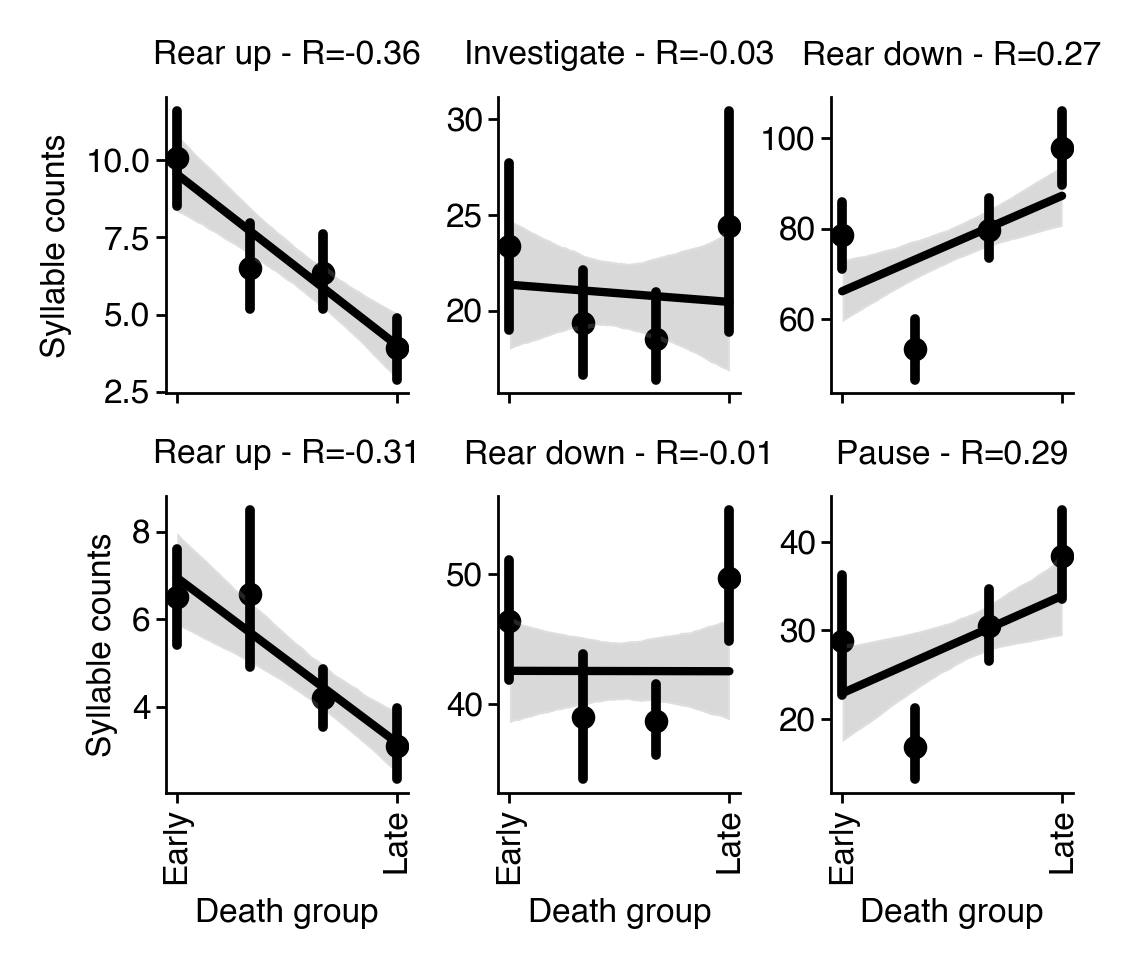

In [47]:
fig, ax = plt.subplots(2, 3, figsize=(2.7, 2.4), sharex=True)

for ex, ax_col in zip((sig_examples.iloc[:2], non_sig_examples, sig_examples.iloc[-2:]), ax.T):

    for (syllable, row), a in zip(ex.iterrows(), ax_col.flat):

        ss[f"{syllable}"] = ss[syllable]
        a = sns.regplot(data=ss, x='death_rank', y=f"{syllable}", x_bins=6, scatter_kws=dict(s=18, lw=0), color='k', ax=a)
        a.set(xlabel="", ylabel="", title=f"{row.Class} - R={row.c:0.2f}", xticks=[0, 3], xticklabels=["Early", "Late"])
for a in ax[:, 0].flat:
    a.set(ylabel="Syllable counts")
for a in ax[-1].flat:
    a.set(xlabel="Death group")
    a.tick_params(axis='x', labelrotation=90)

sns.despine()
fig.tight_layout(w_pad=0.6)
saver(fig, "syllable-count-vs-death-correlations");

In [48]:
group_class_df['c'].agg(['min', 'max'])

min   -0.360907
max    0.286890
Name: c, dtype: float64

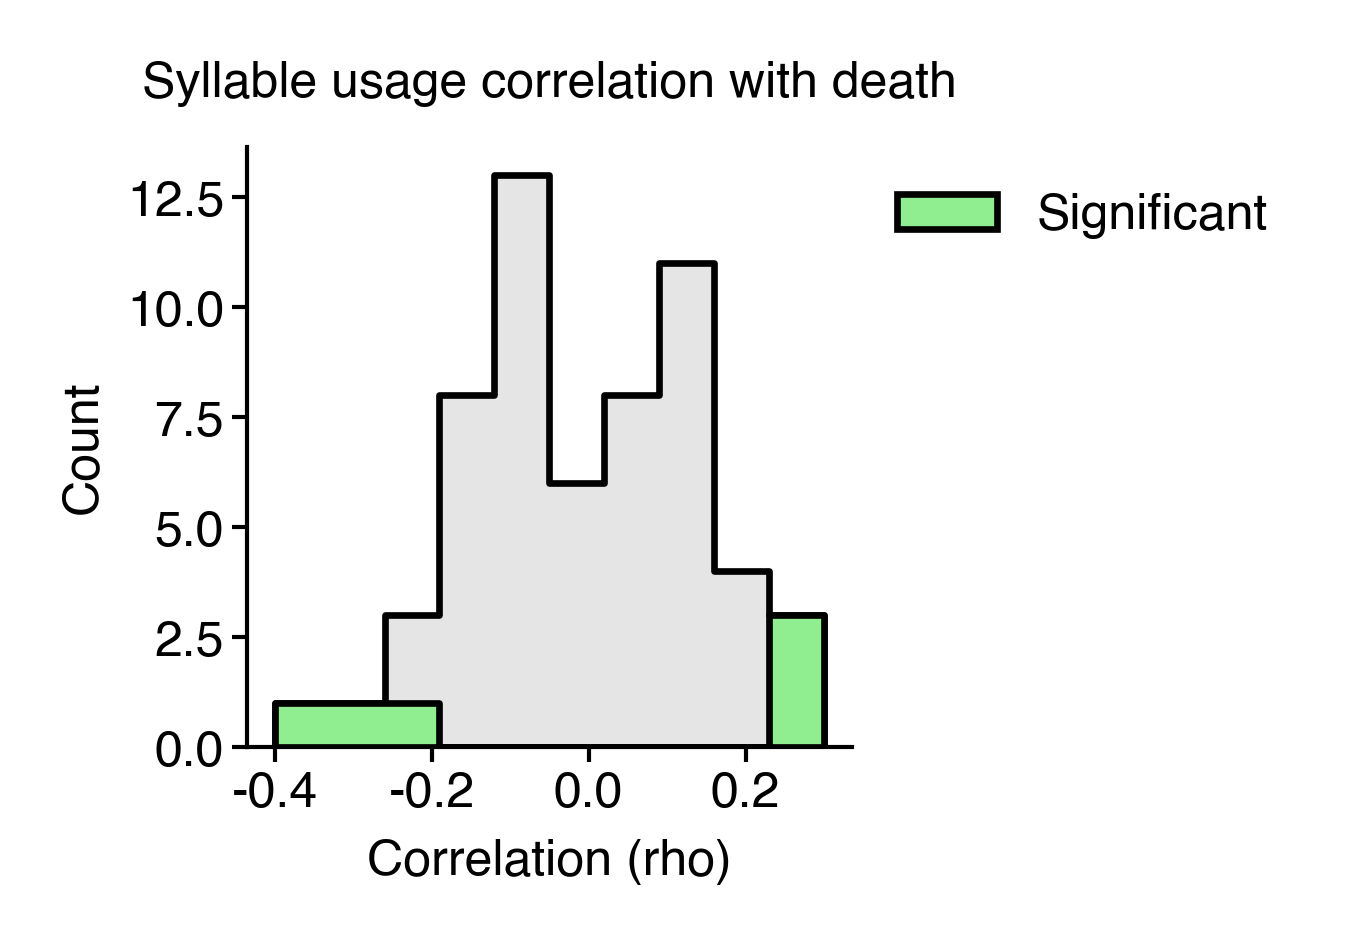

In [49]:
fig = figure(1.3, 1.3)
bins = np.linspace(-0.4, 0.3, 11)
ax = sns.histplot(
    group_class_df["c"], bins=bins, element="step", color="silver", alpha=0.4, ec="k"
)
ax = sns.histplot(
    group_class_df.query("adj_p < 0.05")["c"],
    bins=bins,
    element="step",
    color="lightgreen",
    alpha=1,
    ec="k",
    label="Significant",
)
ax.set(xlabel="Correlation (rho)", title="Syllable usage correlation with death")
legend(ax)
sns.despine()
saver(fig, "syllable-death-correlation-histplot");

In [50]:
list(mdl['init_components'].bases)

['bio', 'size', 'individual', 'development']

In [51]:
bio_base = mdl['init_components'].bases['bio']

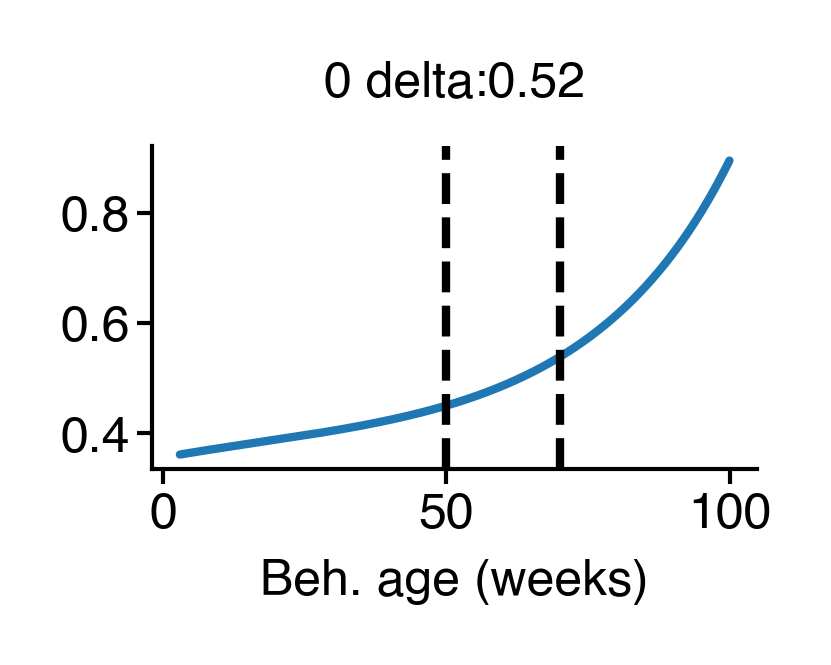

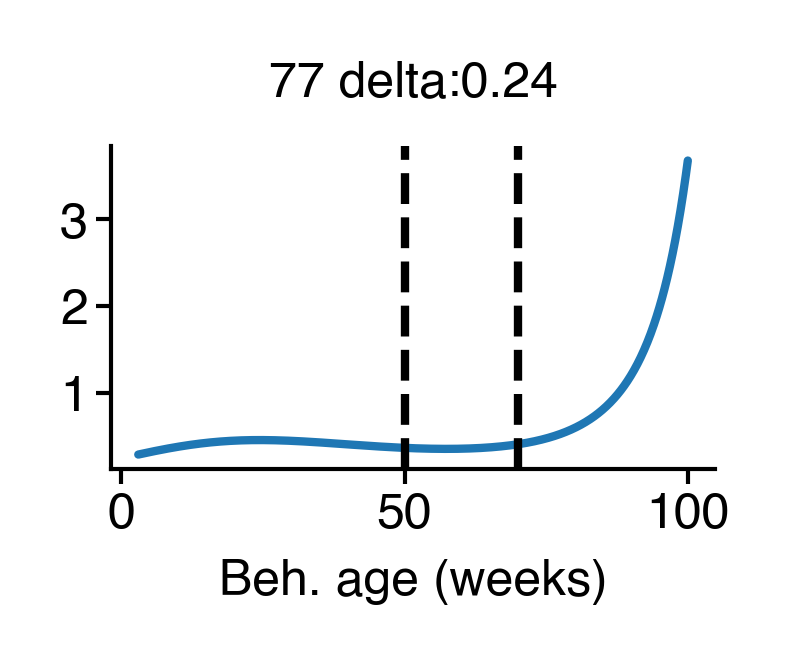

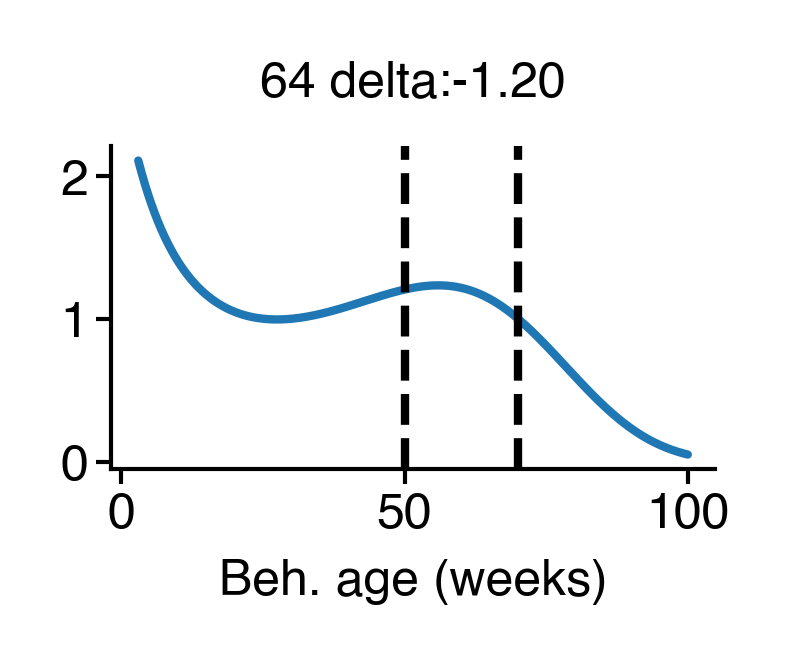

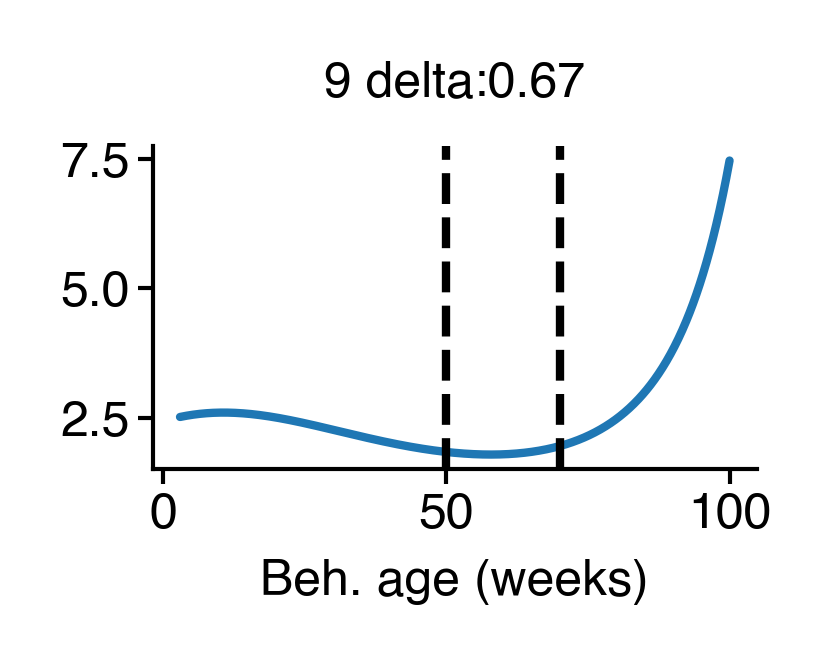

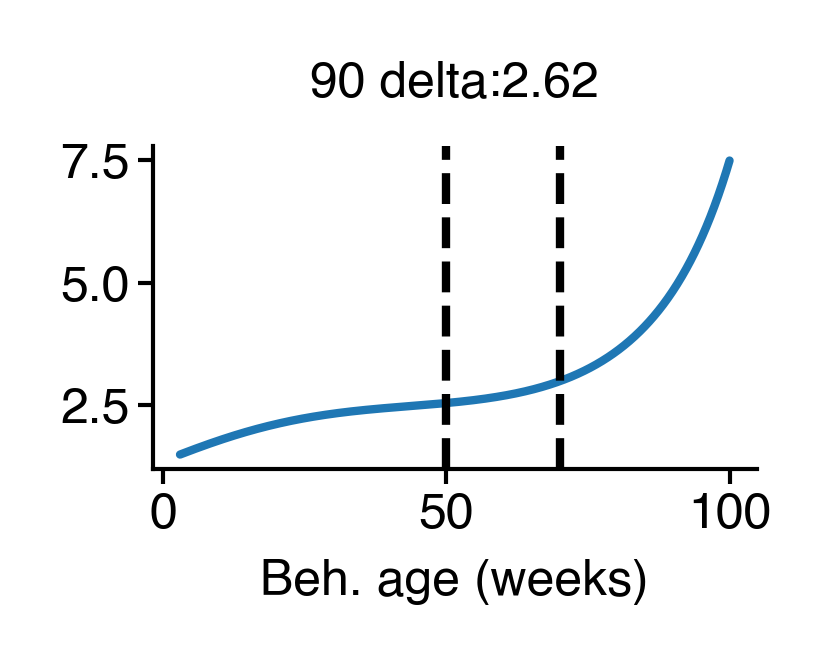

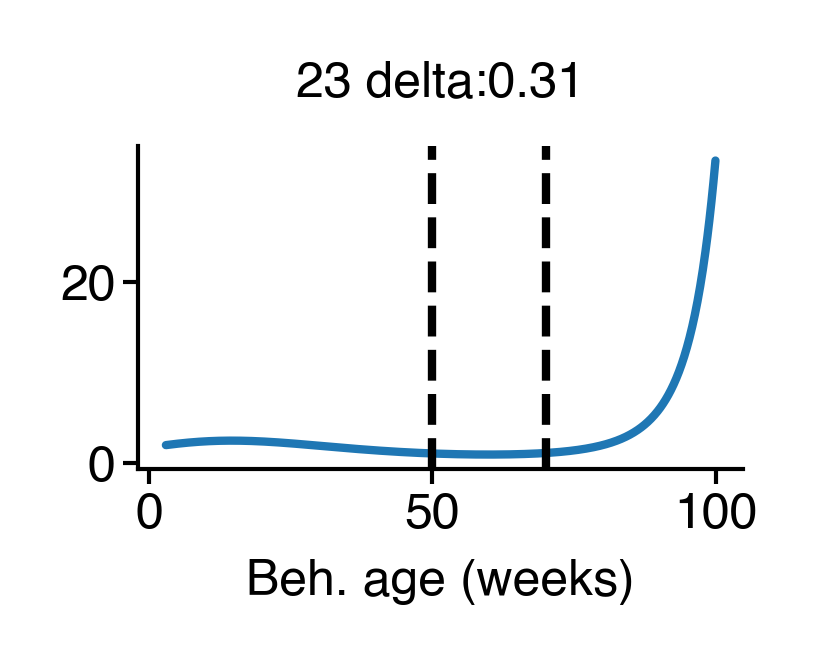

In [53]:
for ex in (sig_examples.iloc[:2], non_sig_examples, sig_examples.iloc[-2:]):
    for syllable, row in ex.iterrows():

        mtx_idx = list(tmp_df.columns).index(syllable)
        weights = mdl['params']['bio_basis_weights'][mtx_idx]
        curve = np.exp(weights @ bio_base)
        age_range = mdl['init_components'].age_normalizer(np.array([50, 70]))

        norm_ages = pd.Series(np.linspace(0, 1, len(curve)))
        sig = norm_ages.between(*age_range)
        sig_mask = sig[sig]
        start_idx, end_idx = sig_mask.index[[0, -1]]
        deriv = (curve[end_idx] - curve[start_idx]) / (norm_ages[sig].iloc[-1] - norm_ages[sig].iloc[0])

        fig = figure(1.3, 0.7)
        # plt.plot(mdl['init_components'].age_unnormalizer(np.linspace(0, 1, len(curve)))[:600], curve[:600])
        x_age = mdl['init_components'].age_unnormalizer(np.linspace(0, 1, len(curve)))
        age_limit = np.where(x_age > 100)[0][0]
        plt.plot(x_age[:age_limit], curve[:age_limit])
        plt.axvline(50, color='k', ls='--')
        plt.axvline(70, color='k', ls='--')
        plt.xlabel("Beh. age (weeks)")
        plt.title(f"{syllable} delta:{deriv:0.2f}")
        sns.despine()

In [84]:
deriv_df = []
for syllable in tmp_df.columns[:-1]:

    mtx_idx = list(tmp_df.columns).index(syllable)
    weights = mdl['params']['bio_basis_weights'][mtx_idx]
    curve = np.exp(weights @ bio_base)
    age_range = mdl['init_components'].age_normalizer(np.array([50, 70]))

    norm_ages = pd.Series(np.linspace(0, 1, len(curve)))
    sig = norm_ages.between(*age_range)
    sig_mask = sig[sig]
    start_idx, end_idx = sig_mask.index[[0, -1]]
    deriv = (curve[end_idx] - curve[start_idx]) / (norm_ages[sig].iloc[-1] - norm_ages[sig].iloc[0])
    deriv_df.append(dict(deriv=deriv, syllable=syllable))

deriv_df = pd.DataFrame(deriv_df).set_index('syllable')

In [85]:
cdf = group_class_df.join(deriv_df)

In [86]:
cdf.head()

Class Short description Long description         c  \
Original ID                                                         
0            Rear up               NaN              NaN -0.360907   
77           Rear up               NaN              NaN -0.309123   
11               Run               NaN              NaN -0.237926   
55           Rear up               NaN              NaN -0.224524   
10           Rear up               NaN              NaN -0.211188   

                        p     adj_p  averaged_c     deriv  
Original ID                                                
0            1.520778e-07  0.000009   -0.385554  0.517227  
77           8.435238e-06  0.000489   -0.325943  0.244388  
11           6.924604e-04  0.040163   -0.235600  0.951835  
55           1.392213e-03  0.080748   -0.279974  0.471042  
10           2.683414e-03  0.155638   -0.186505  0.257253

In [100]:
corr = cdf[['averaged_c', 'deriv']].corr(method='spearman').iloc[0, 1]

In [91]:
cdf['averaged_c'].agg(['min', 'max'])

min   -0.385554
max    0.275478
Name: averaged_c, dtype: float64

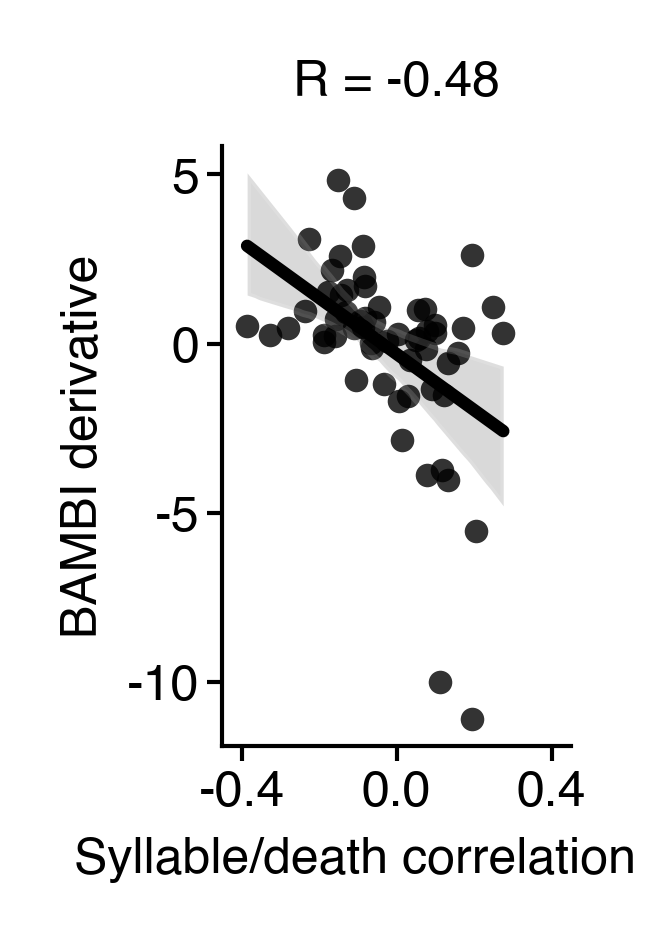

In [102]:
fig = figure(0.75, 1.3)
ax = sns.regplot(
    x=cdf["averaged_c"],
    y=cdf["deriv"],
    scatter_kws=dict(linewidths=0, s=8),
    color="k",
    robust=False,
    n_boot=400,
)

ax.set(
    xticks=(-0.4, 0, 0.4),
    xlim=(-0.45, 0.45),
    ylabel="BAMBI derivative",
    title=f"R = {corr:0.2f}",
    xlabel="Syllable/death correlation (R)",
)
sns.despine()
saver(fig, "bambi-deriv-vs-syllable-correlation");

In [240]:
from aging.behavior.bio_age_model import raise_dim

In [241]:
biases = np.array(raise_dim(mdl['params']['individual_biases'], axis=1))

In [ ]:
bias_death_order = death_map.reindex(cats)
# cuts = pd.qcut(bias_death_order["Death"], 4, labels=False)
cuts = bias_death_order["Death"].rank(method="dense")

In [321]:
bias_corr_df = []
for i, syllable in enumerate(tmp_df.columns[:-1]):
    death_bias_df = cuts.reset_index().assign(bias=biases[i])
    death_bias_df = death_bias_df.dropna()
    # death here can a 4-class category depending on cell above
    c = spearmanr(death_bias_df['bias'], death_bias_df['Death'])
    bias_mag = np.abs(biases[i]).mean()
    bias_corr_df.append(dict(syllable=syllable, c=c.statistic, p=c.pvalue, bias_mag=bias_mag))
bias_corr_df = pd.DataFrame(bias_corr_df).set_index('syllable')

In [284]:
bias_corr_df['c'].agg(['min', 'max'])

min   -0.499455
max    0.612164
Name: c, dtype: float64

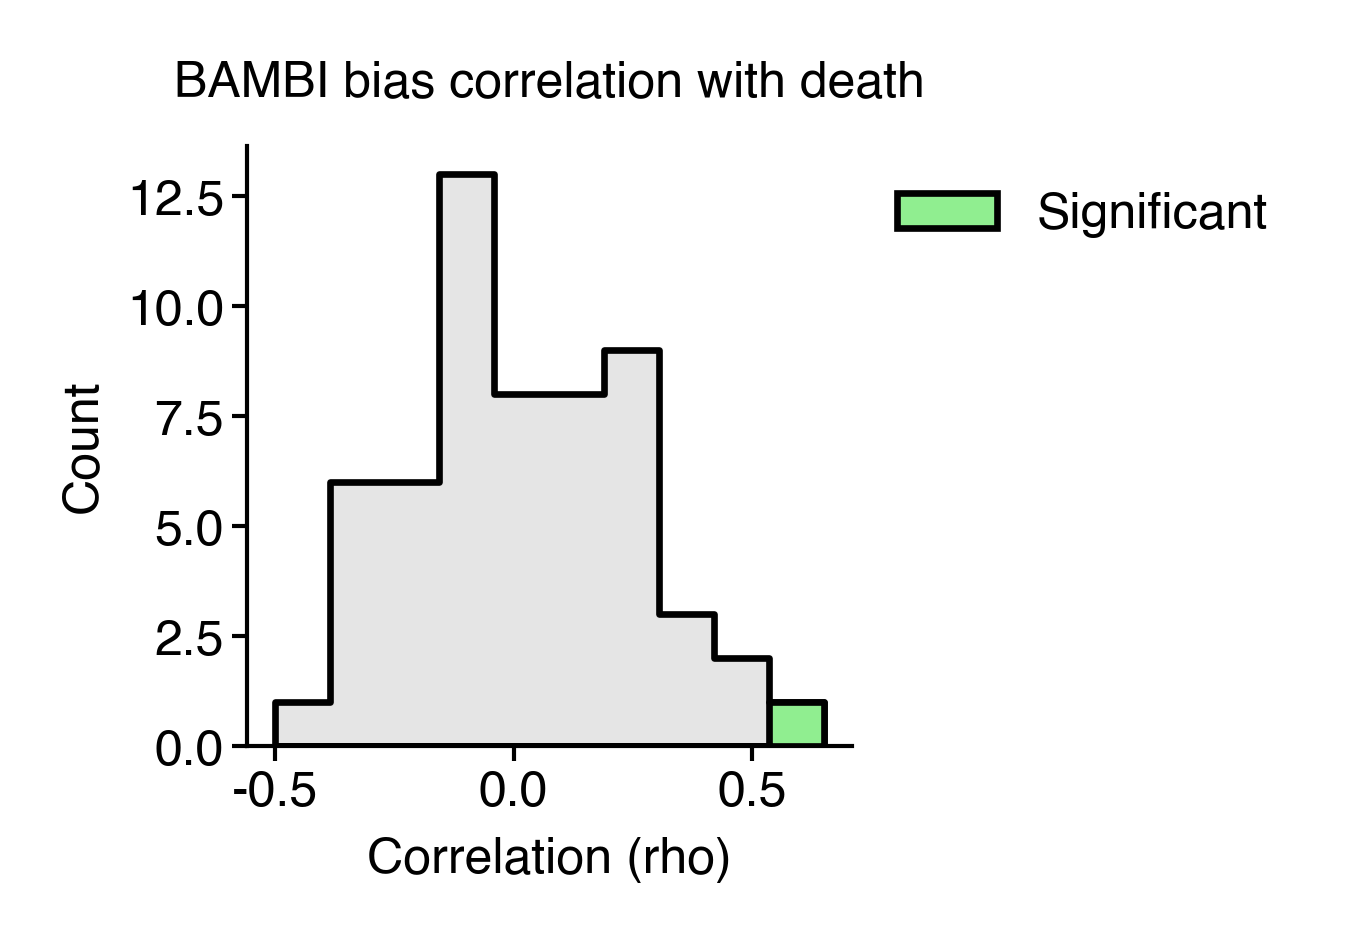

In [288]:
fig = figure(1.3, 1.3)
bins = np.linspace(-0.5, 0.65, 11)
ax = sns.histplot(
    bias_corr_df["c"], bins=bins, element="step", color="silver", alpha=0.4, ec="k"
)
ax = sns.histplot(
    bias_corr_df.query("p < 0.05")["c"],
    bins=bins,
    element="step",
    color="lightgreen",
    alpha=1,
    ec="k",
    label="Significant",
)
ax.set(xlabel="Correlation (rho)", title="BAMBI bias correlation with death")
legend(ax)
sns.despine()
saver(fig, "bambi-bias-death-correlation-histplot");

In [322]:
joined_dfs = group_class_df.join(bias_corr_df, rsuffix='_bias')

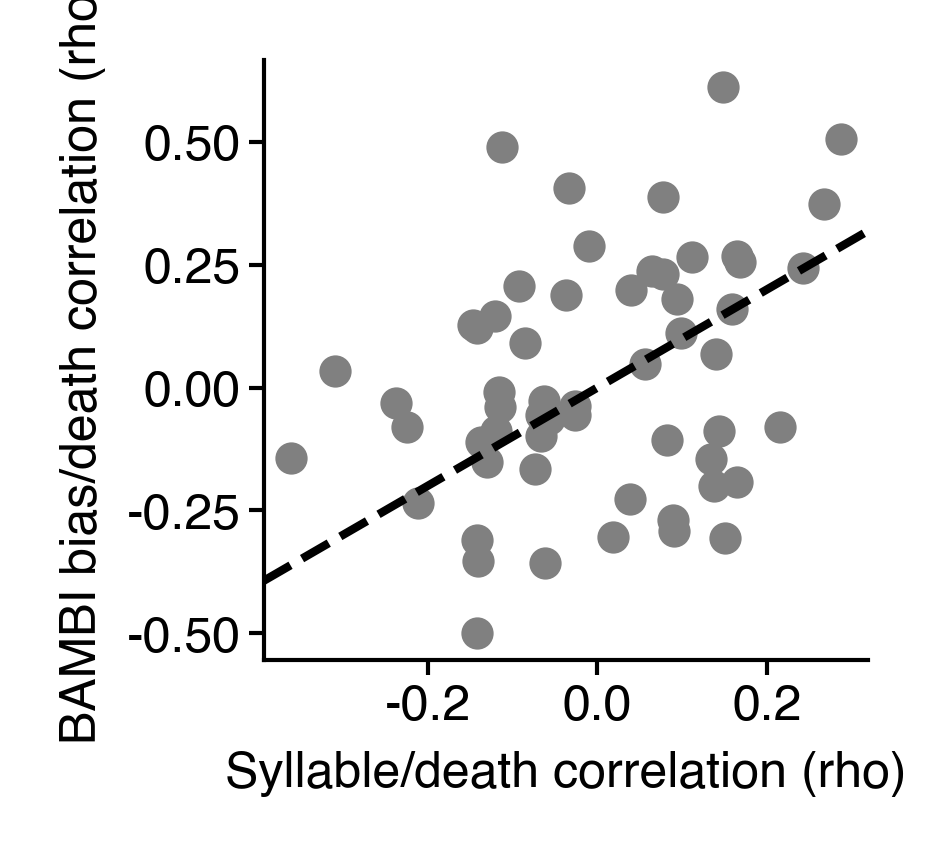

In [323]:
fig = figure(1.3, 1.3)
ax = fig.gca()
ax.scatter(joined_dfs['c'], joined_dfs['c_bias'], c='gray', s=15, lw=0)
add_identity(ax, color='k', ls='--', lw=1)
ax.set(xlabel="Syllable/death correlation (rho)", ylabel="BAMBI bias/death correlation (rho)")
sns.despine()
saver(fig, "bambi-syllable-death-correlation-relationships");

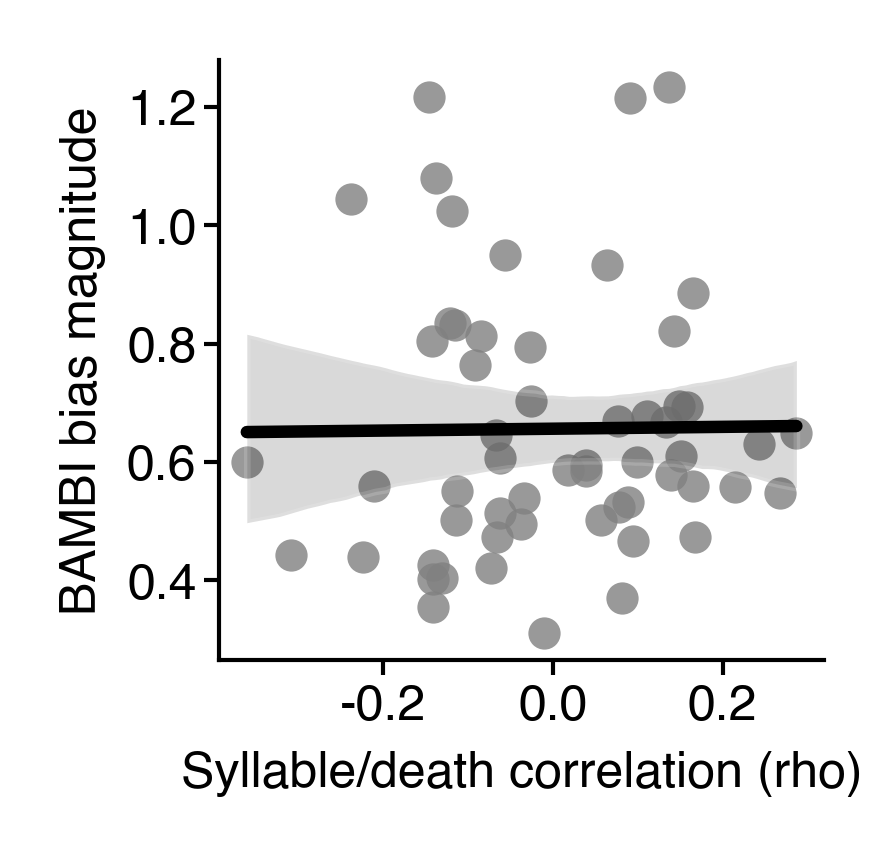

In [327]:
fig = figure(1.3, 1.3)
ax = fig.gca()
ax = sns.regplot(x=joined_dfs['c'], y=joined_dfs['bias_mag'], color='k', scatter_kws=dict(s=15, linewidths=0, color='gray'))
# add_identity(ax, color='k', ls='--', lw=1)
ax.set(xlabel="Syllable/death correlation (rho)", ylabel="BAMBI bias magnitude")
sns.despine()
saver(fig, "bambi-bias-syllable-death-correlation-relationships");

In [314]:
r = joined_dfs[['c', 'c_bias']].corr(method='spearman').iloc[0, 1]

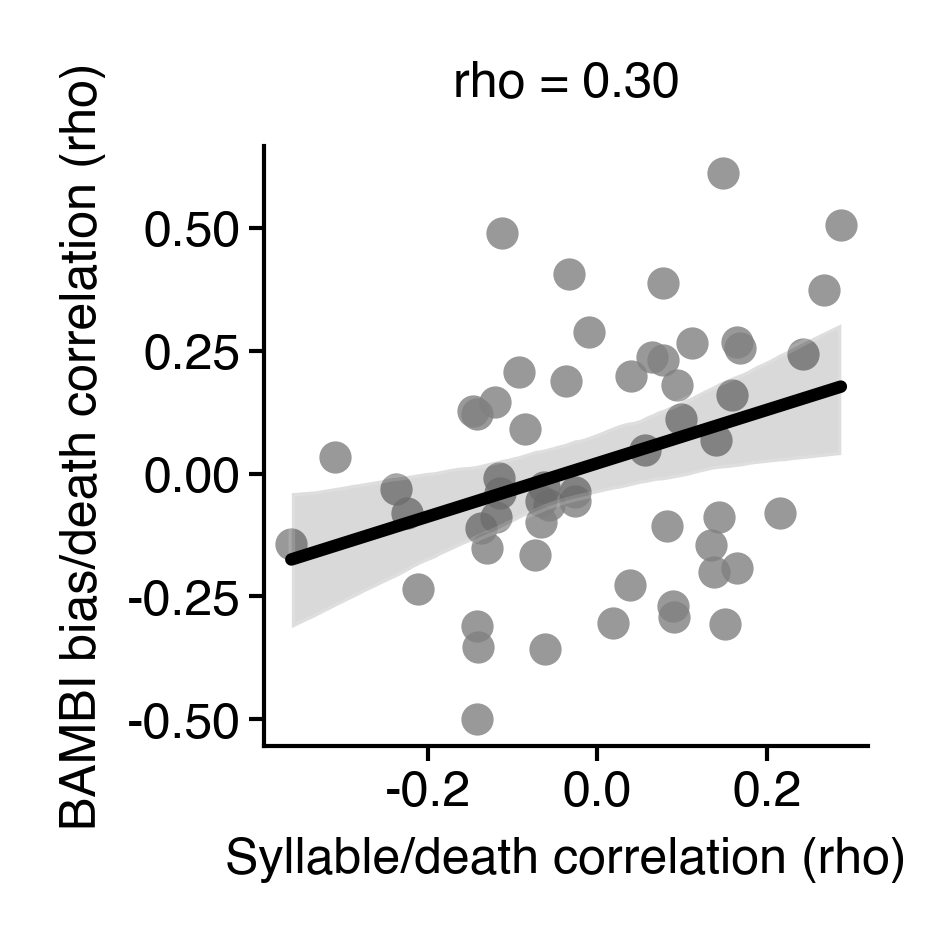

In [316]:
fig = figure(1.3, 1.3)
ax = fig.gca()
ax = sns.regplot(x=joined_dfs['c'], y=joined_dfs['c_bias'], color='k', scatter_kws=dict(s=15, linewidths=0, color='gray'))
# add_identity(ax, color='k', ls='--', lw=1)
ax.set(xlabel="Syllable/death correlation (rho)", ylabel="BAMBI bias/death correlation (rho)", title=f"rho = {r:0.2f}")
sns.despine()
saver(fig, "bambi-syllable-death-correlation-relationships-regplot");

In [49]:
n_sylls = 4
_sylls = list(avg_d)

neg = _sylls[:n_sylls]
pos = _sylls[-n_sylls:]

half_n = n_sylls // 2
half_len = len(_sylls) // 2
mid = _sylls[half_len - half_n:half_len+half_n]

In [62]:
# shuffle
shuffs = defaultdict(list)
ages = defaultdict(list)
for i in tqdm(range(50)):
    shuff_df = tmp_df.query("age >= 50").copy().reset_index()

    # remove age-related info per mouse
    # shuff_df['age'] = shuff_df.groupby('mouse')['age'].transform(lambda x: x.sample(frac=1, replace=False, random_state=i).to_numpy())
    # remove age-related info across all mice
    # shuff_df['age'] = shuff_df['age'].sample(frac=1, replace=False, random_state=i).to_numpy()

    for s in neg + mid + pos:
        # remove mouse-syll-related info per age
        shuff_df[s] = shuff_df.groupby(
            pd.cut(shuff_df["age"], 5, labels=False), observed=True
        )[s].transform(
            lambda x: x.sample(frac=1, replace=False, random_state=i).to_numpy()
        )

        _df = (
            compute_syllable_correlations(shuff_df, s).dropna().query("n_samples > 50")
        )
        ages[s].append(_df["avg"].to_numpy())
        shuffs[s].append(_df["corr"].rename(i).reset_index(drop=True))

shuffs = valmap(lambda x: pd.concat(x, axis=1), shuffs)
# shuffs = pd.concat(shuffs, axis=1)
# tmp_plt = shuffs.reset_index().melt(id_vars='avg')

shuff_with_age = {}
for k, v in shuffs.items():
    shuff_with_age[k] = v.assign(age=np.mean(ages[k], axis=0)).melt(id_vars="age")

  0%|          | 0/50 [00:00<?, ?it/s]

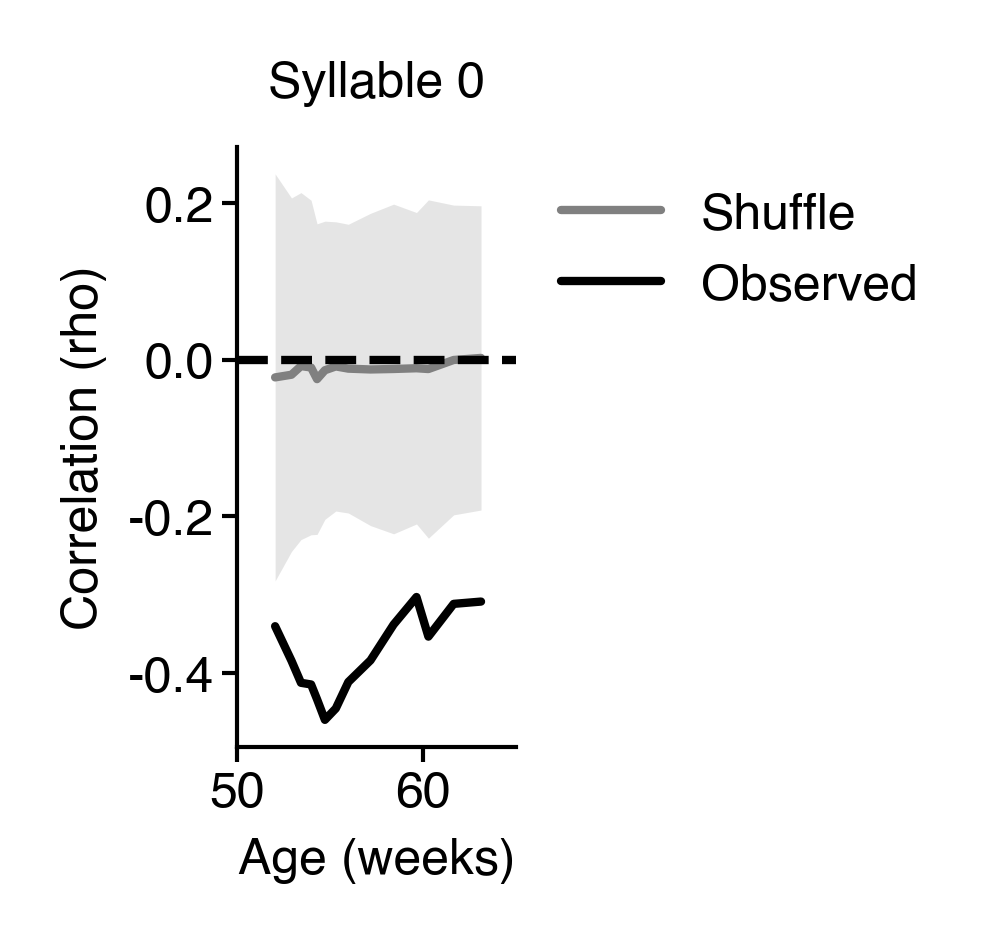

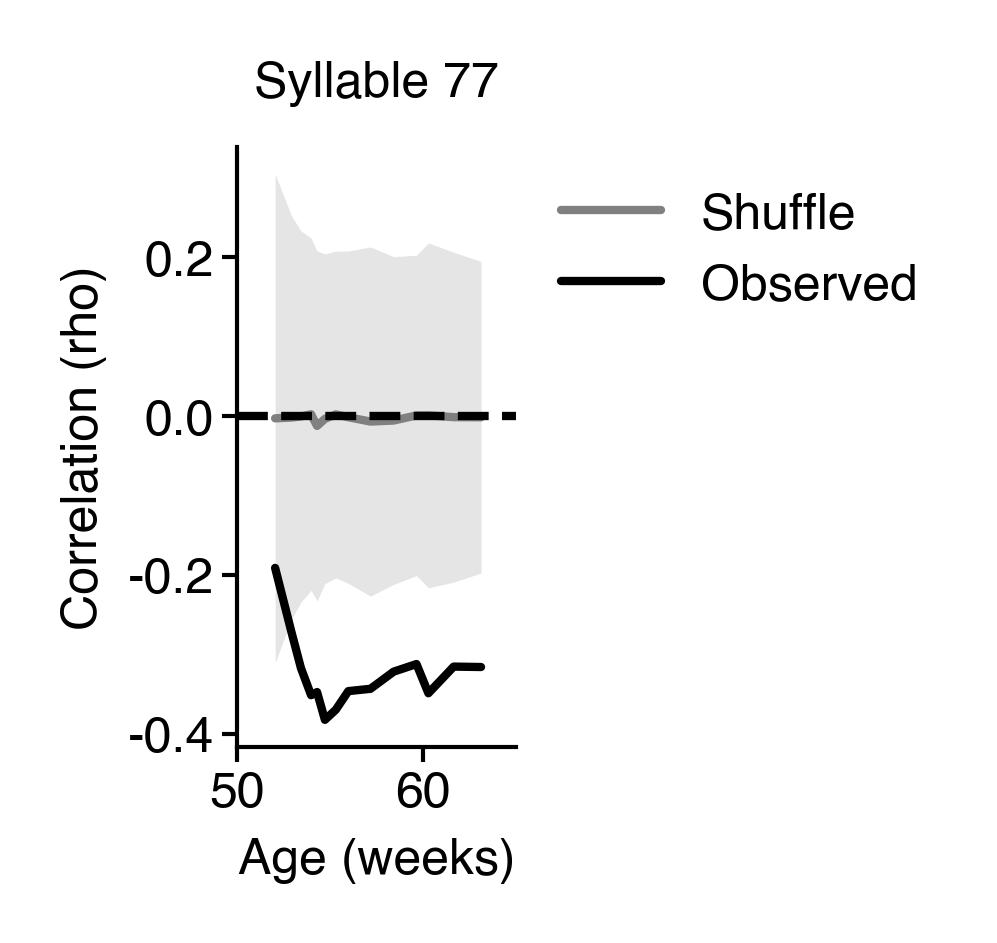

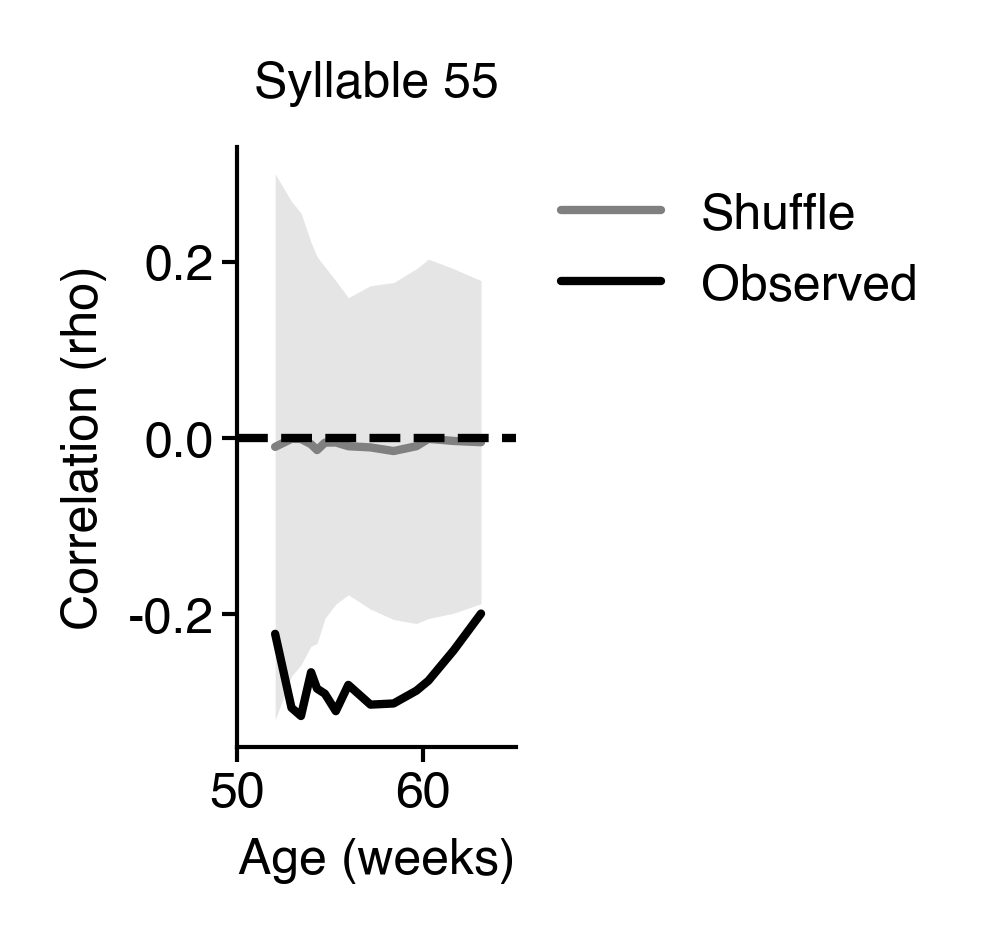

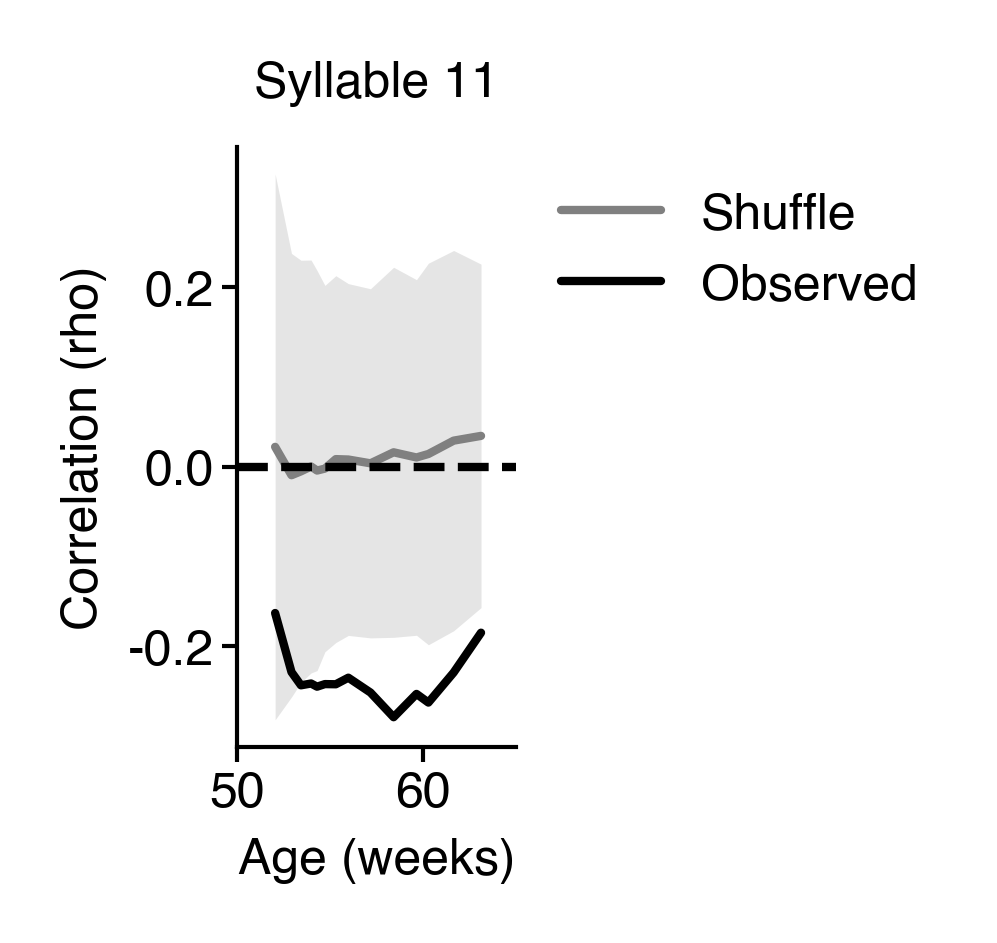

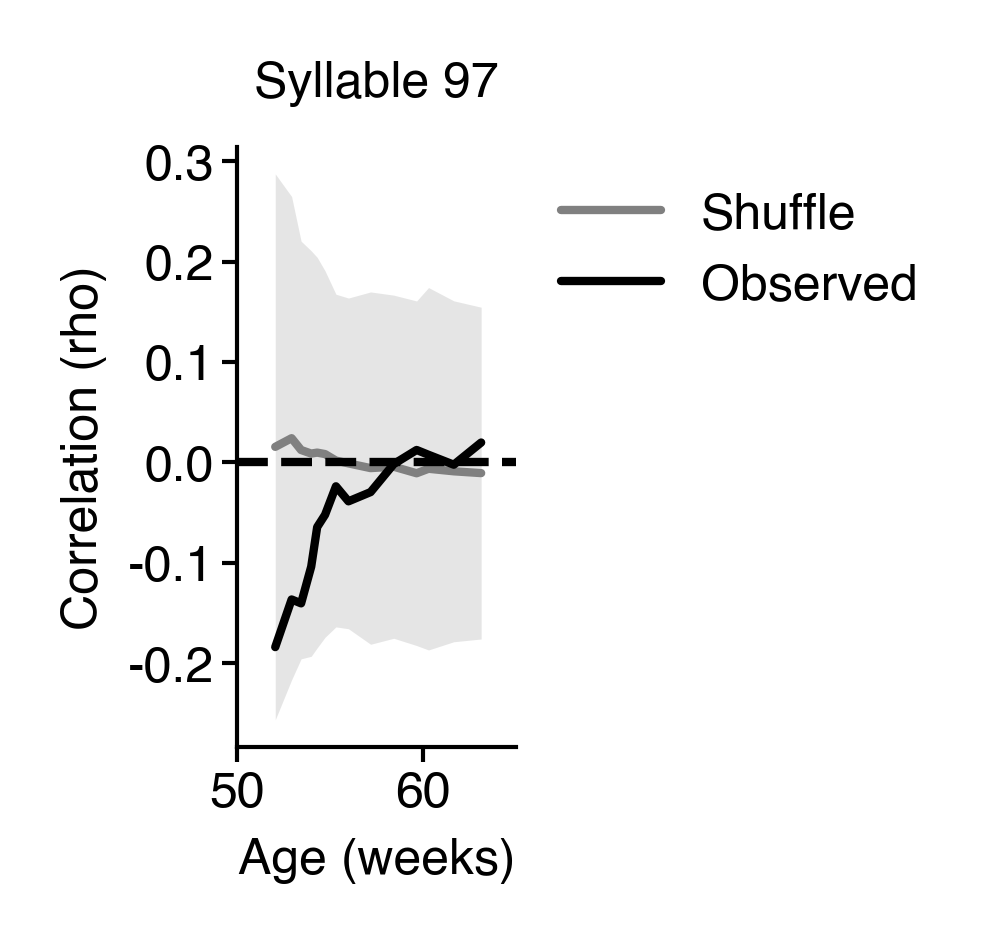

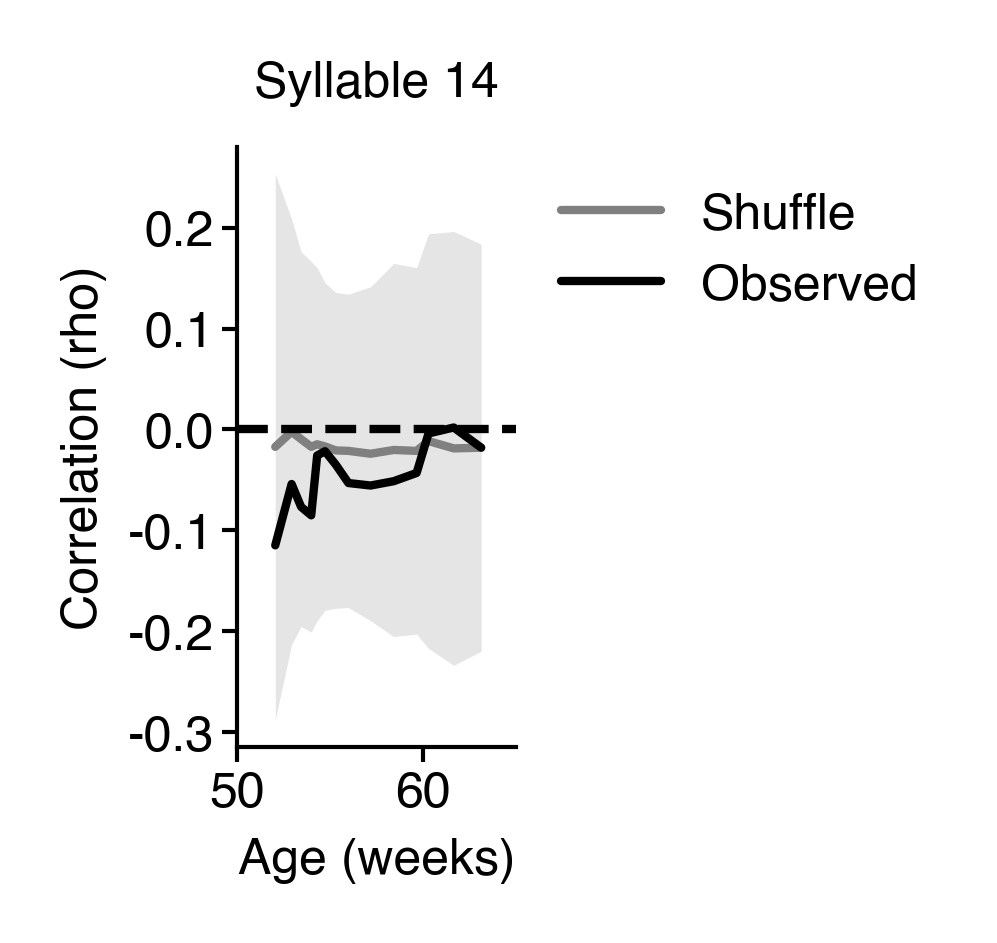

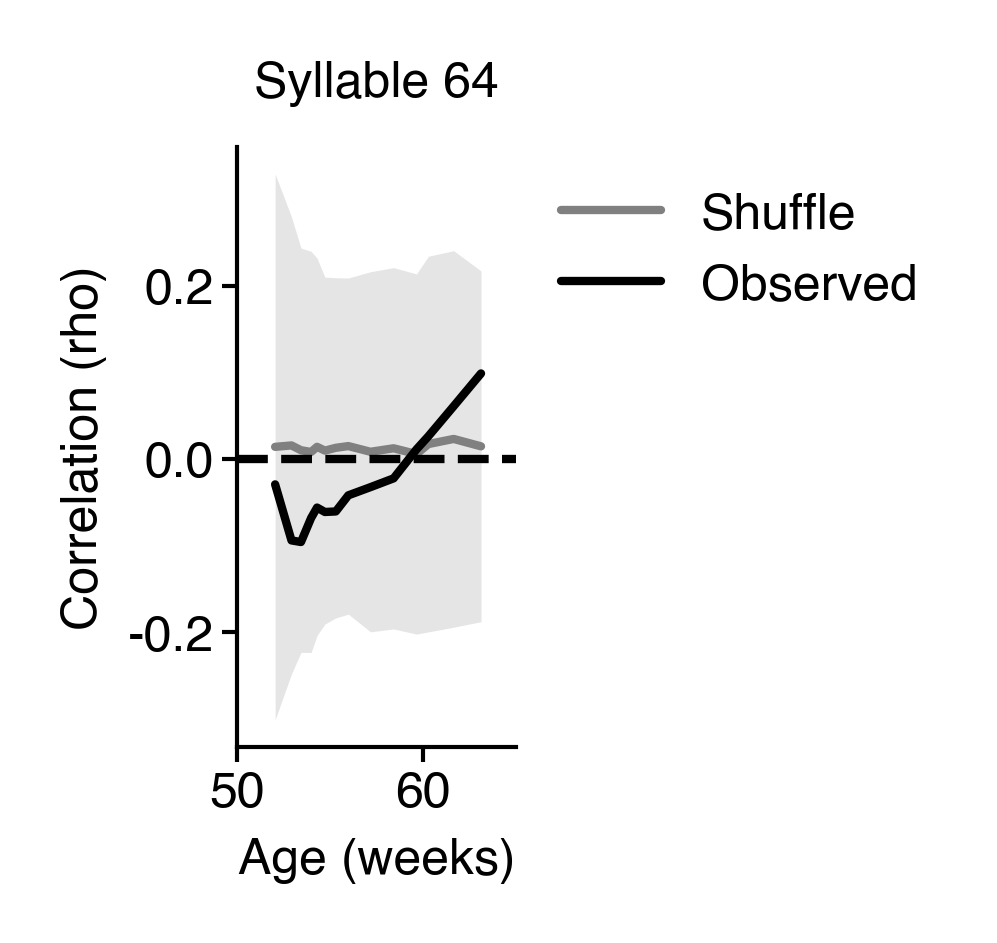

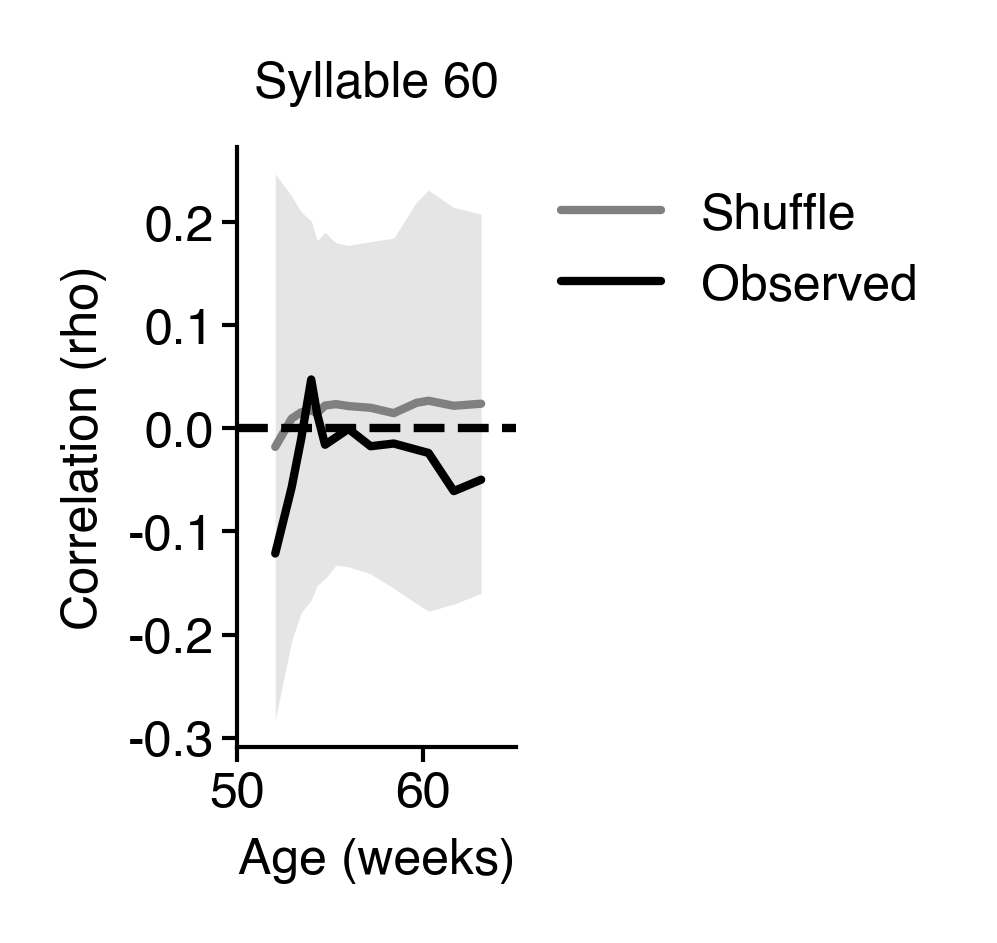

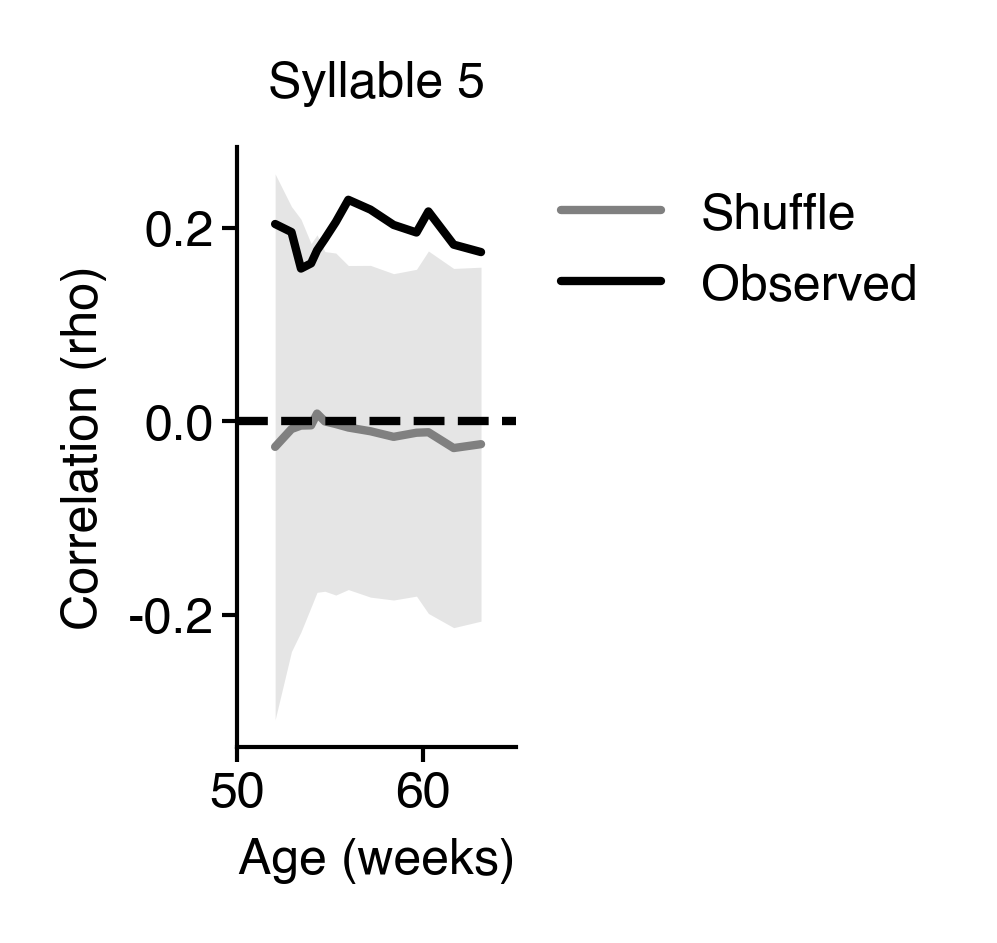

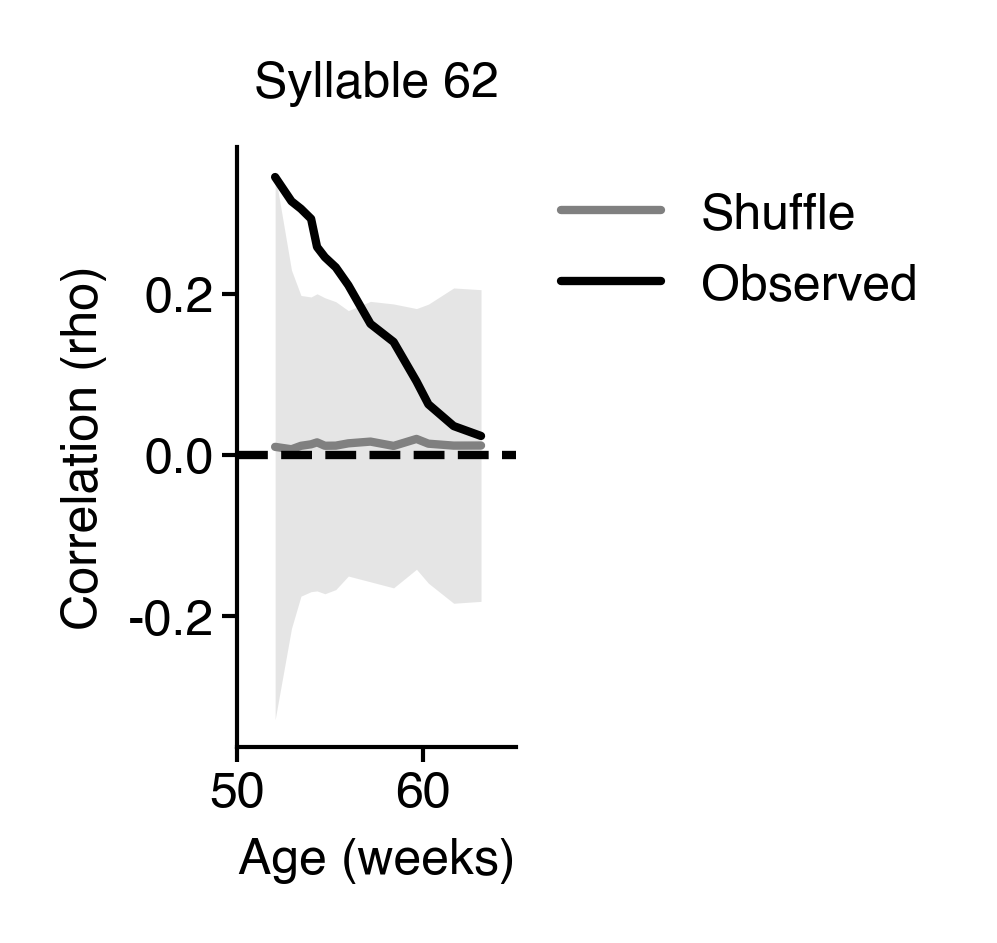

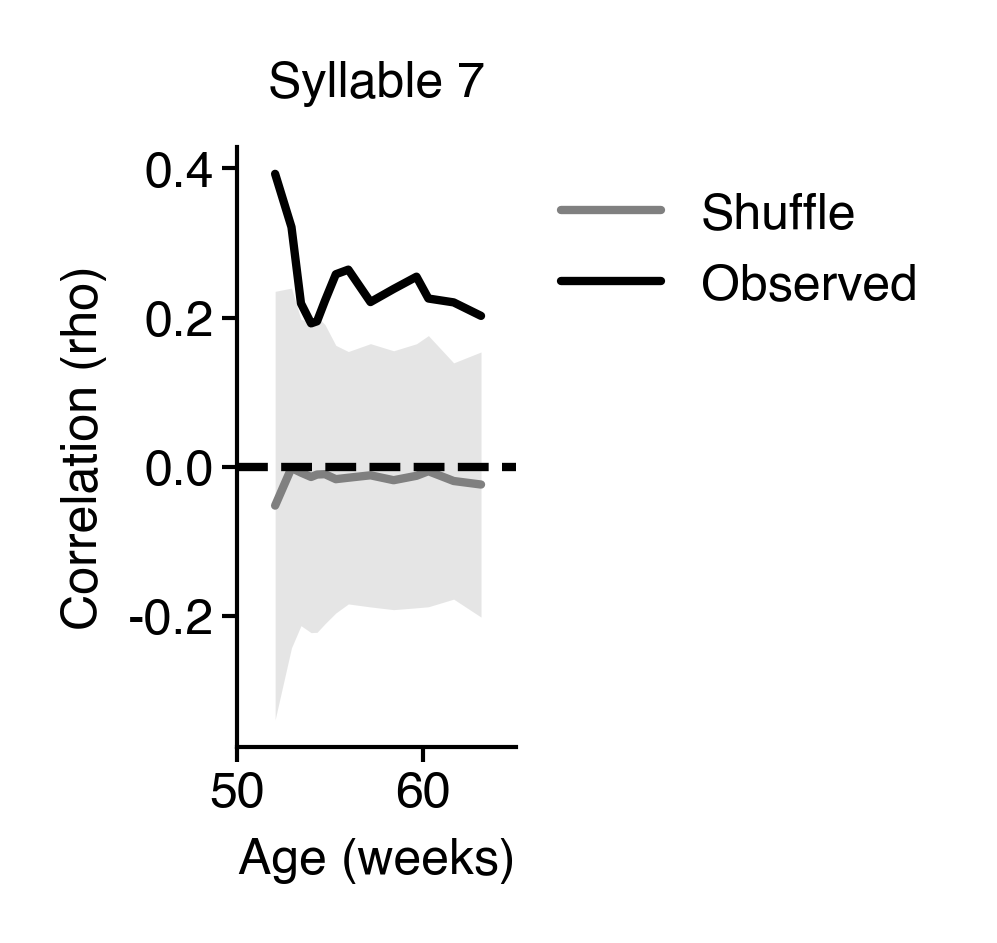

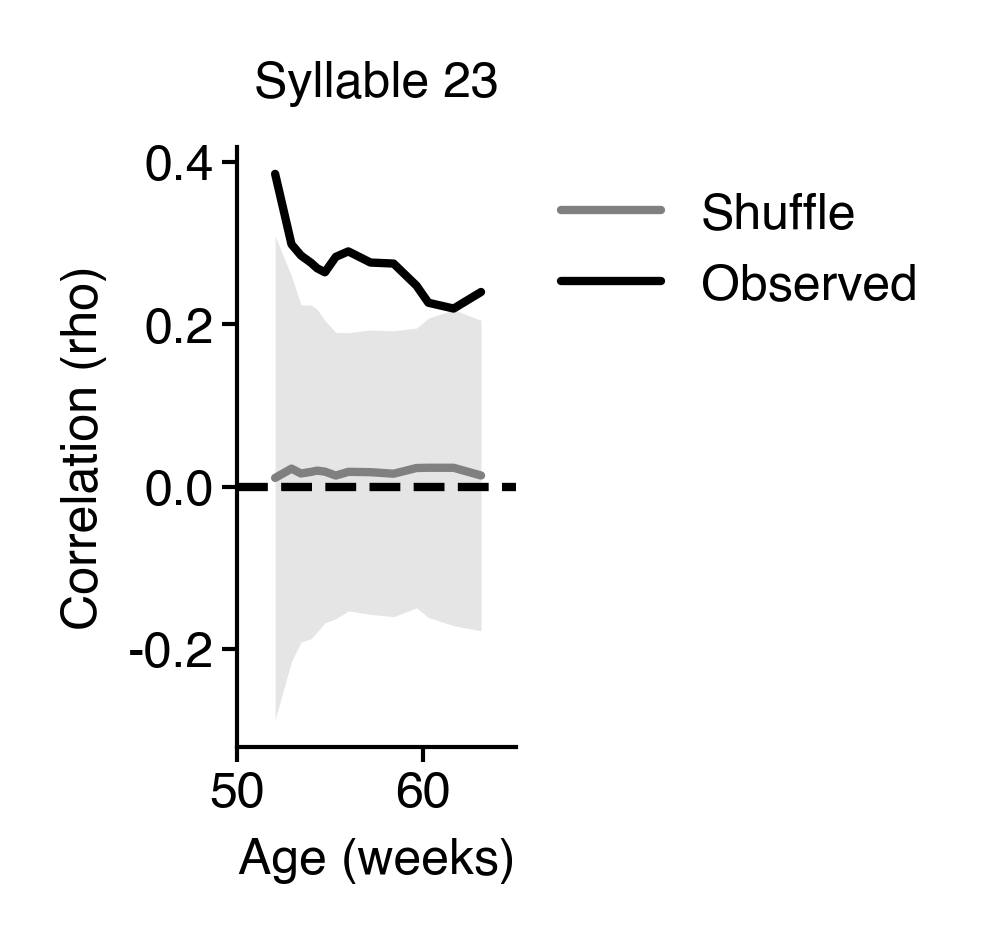

In [63]:
for syll in neg + mid + pos:
    fig = figure(0.6, 1.3)
    ax = sns.lineplot(
        data=shuff_with_age[syll],
        x="age",
        y="value",
        errorbar=("sd", 2),
        color="gray",
        label="Shuffle",
        err_kws=dict(lw=0),
    )
    ax = all_scs[syll].set_index("avg")["corr"].plot(color="k", ax=ax, label="Observed")
    ax.axhline(0, color="k", ls="--")
    ax.set(xlabel="Age (weeks)", ylabel="Correlation (rho)", title=f"Syllable {syll}", xlim=(50, 65))
    legend(ax)
    sns.despine()
    saver(fig, f'{syll}-counts-vs-death-vs-age-correlation');

In [301]:
# extract a scatter plot
reset_df = tmp_df.reset_index()
subset = reset_df[reset_df['age'].between(56, 71)]
subset_join = subset.merge(
    death_map.reset_index(), left_on="mouse", right_on="id"
).dropna(subset=["Death"])


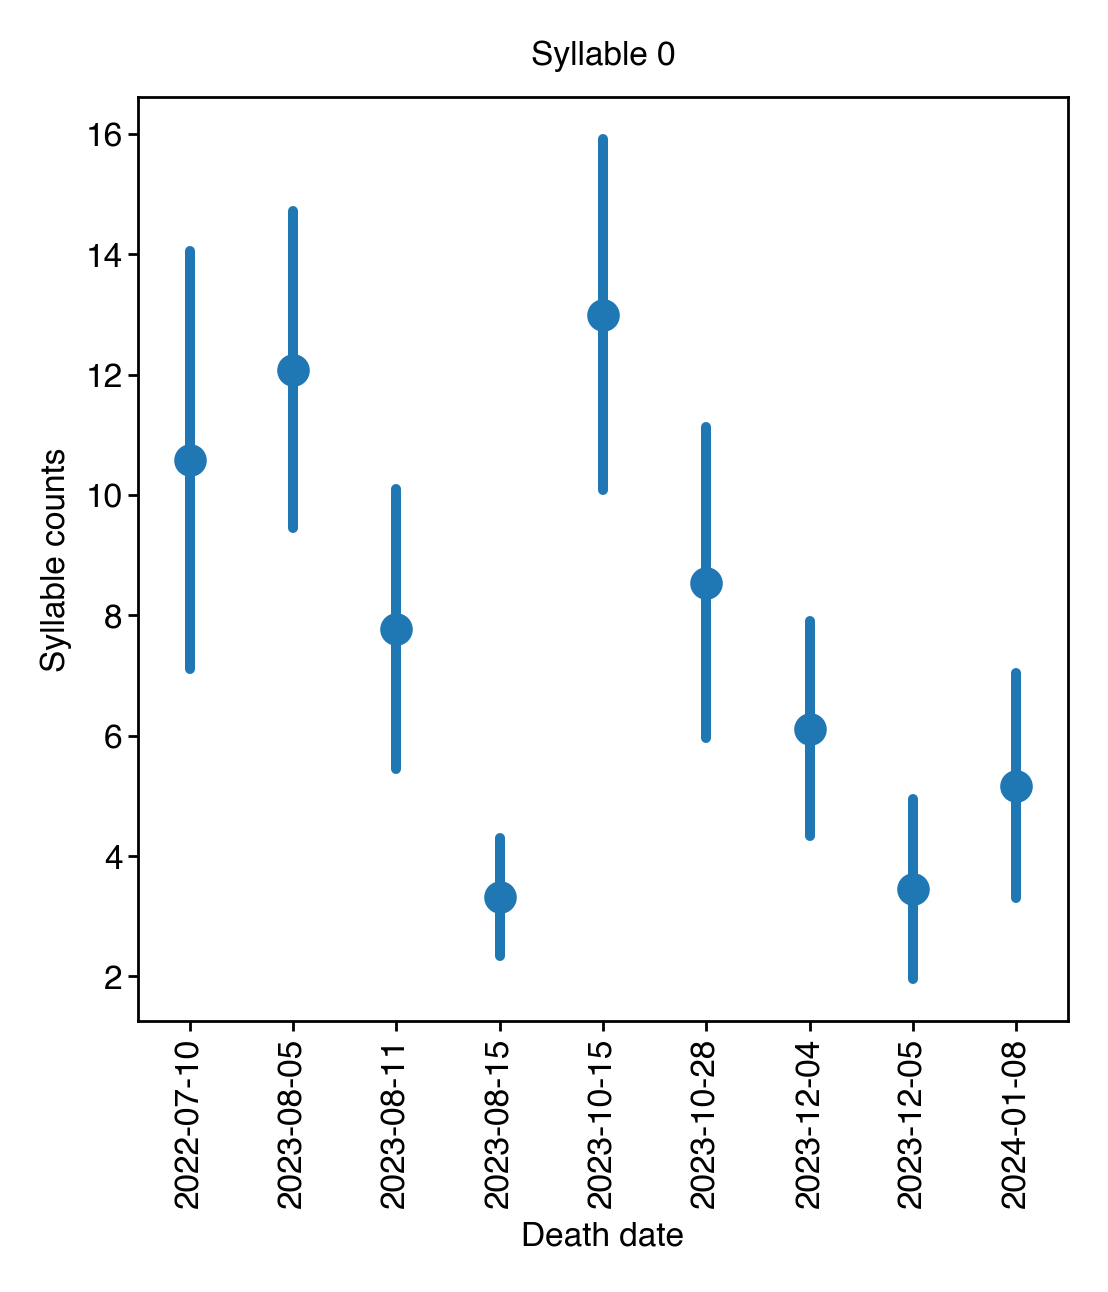

In [266]:
ax = sns.pointplot(data=subset_join.sort_values(by='Death'), x='Death', y=syllable, linestyle='none', errorbar=('se', 2))
ax.set(xlabel="Death date", ylabel="Syllable counts", title=f"Syllable {syllable}")
plt.xticks(rotation=90);

In [267]:
subset_join[['death_rank', f'{syllable}_rank']].corr(method='pearson')

death_rank    0_rank
death_rank    1.000000 -0.339277
0_rank       -0.339277  1.000000

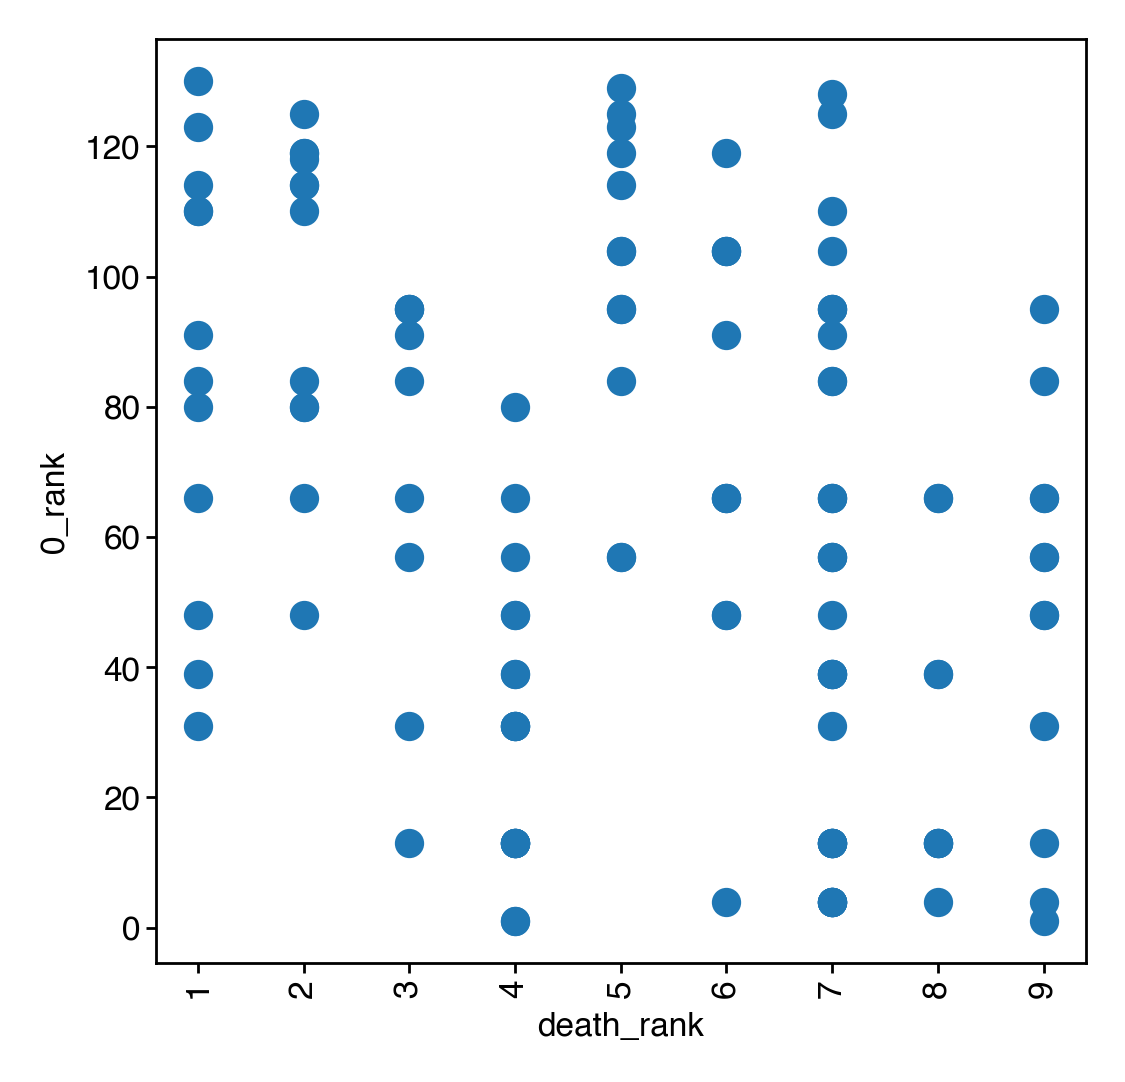

In [268]:
ax = subset_join.plot(kind='scatter', x='death_rank', y=f'{syllable}_rank')
plt.xticks(rotation=90);

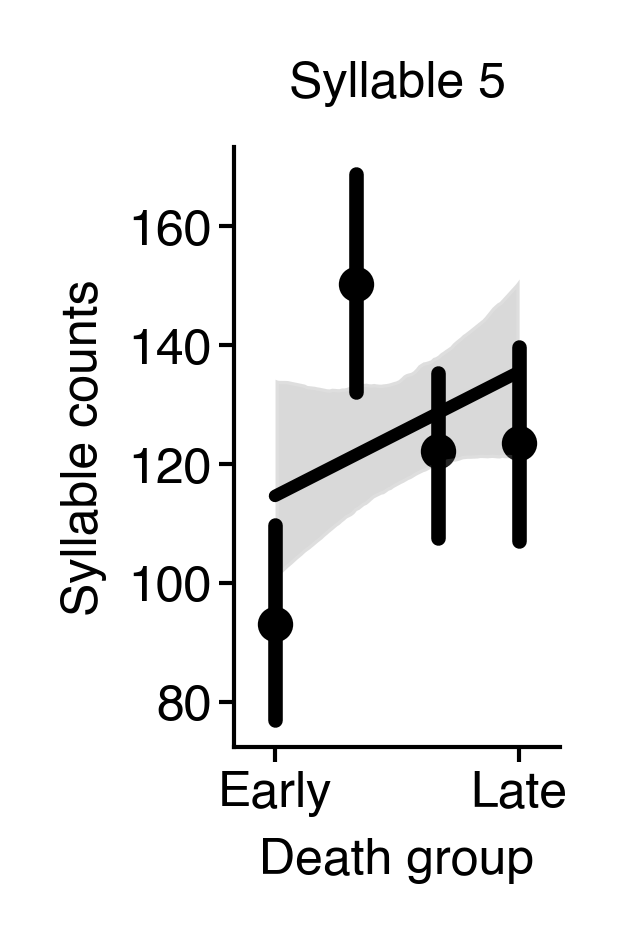

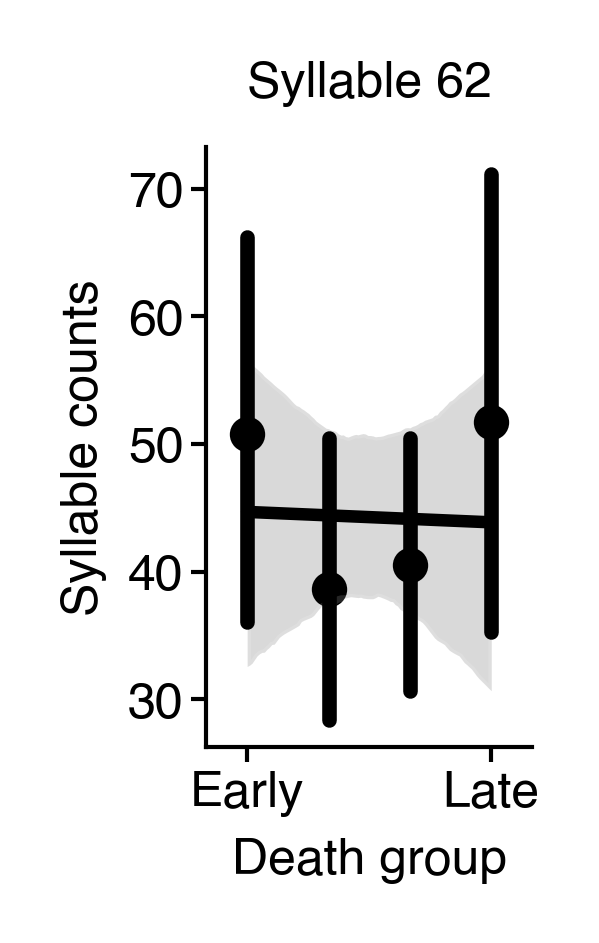

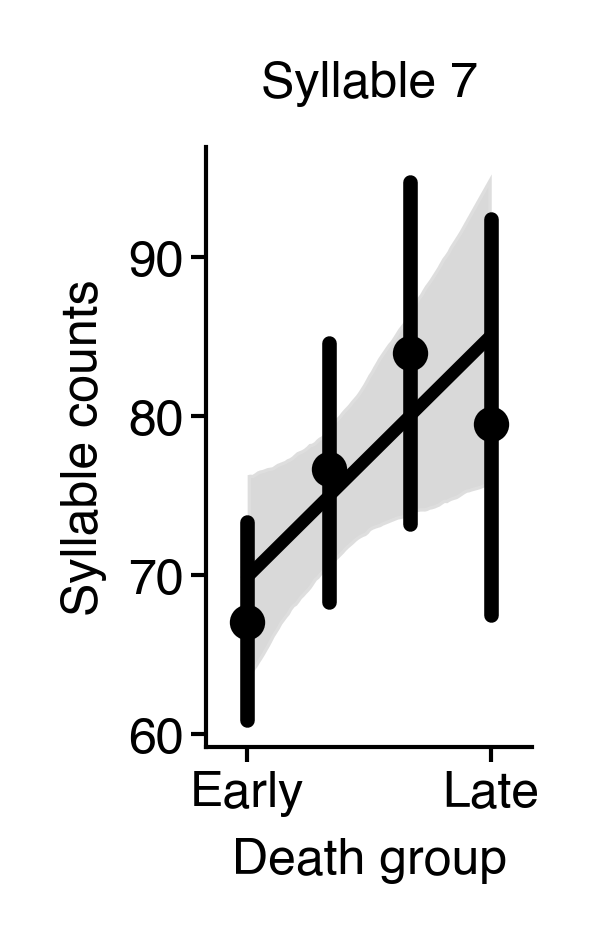

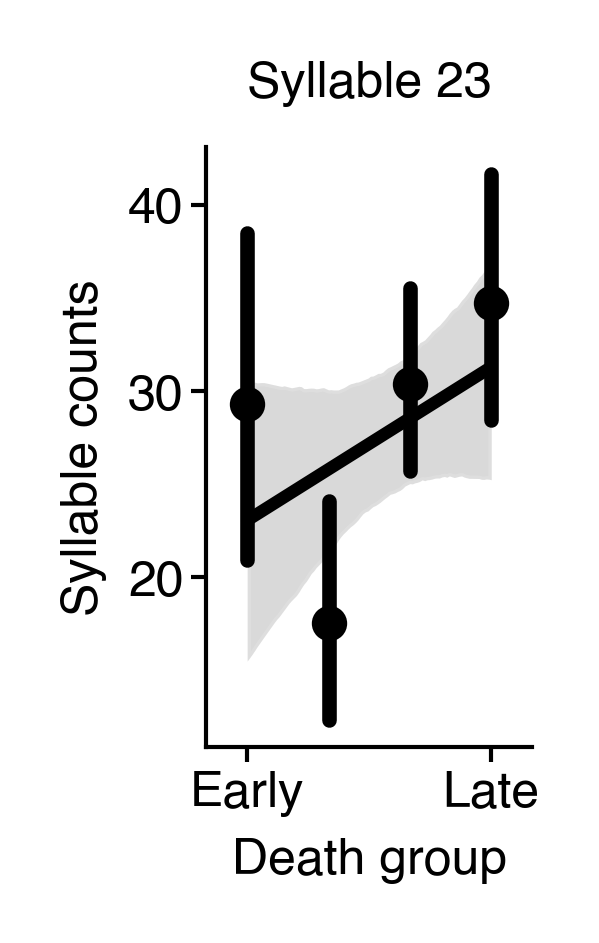

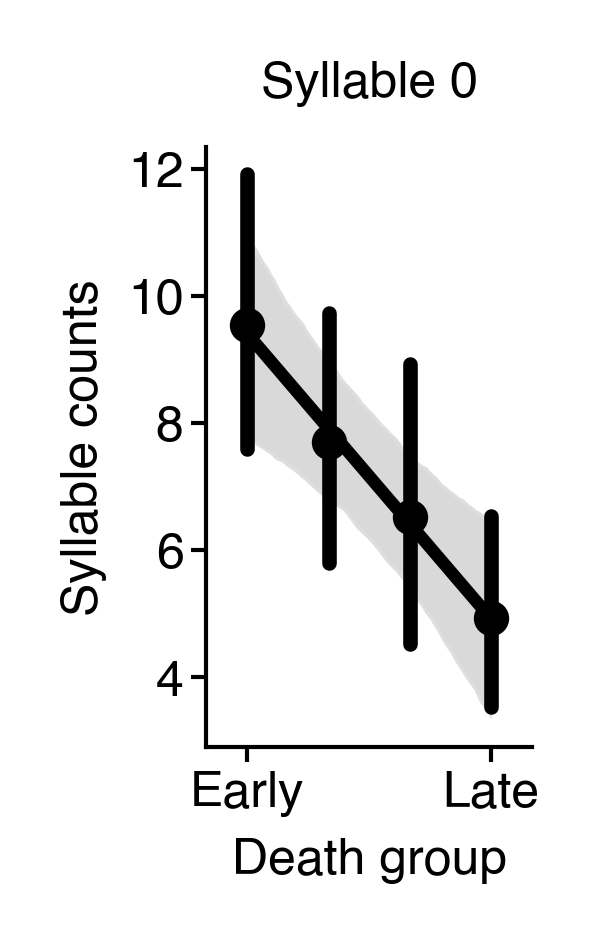

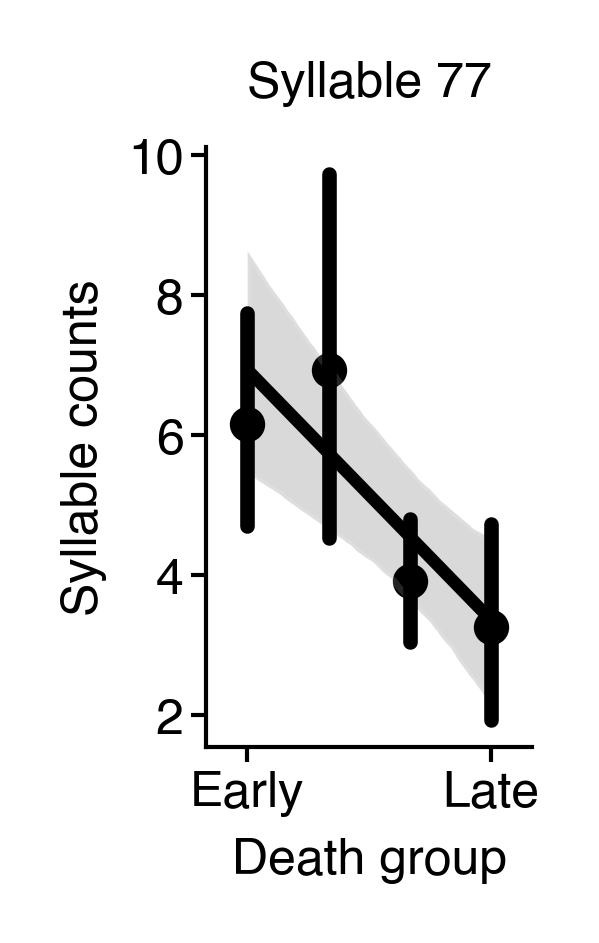

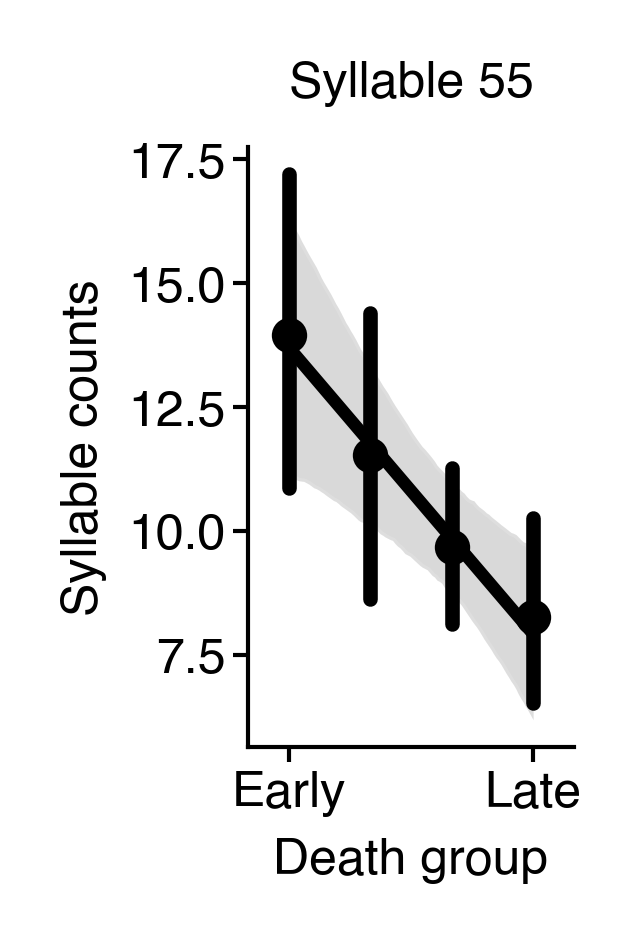

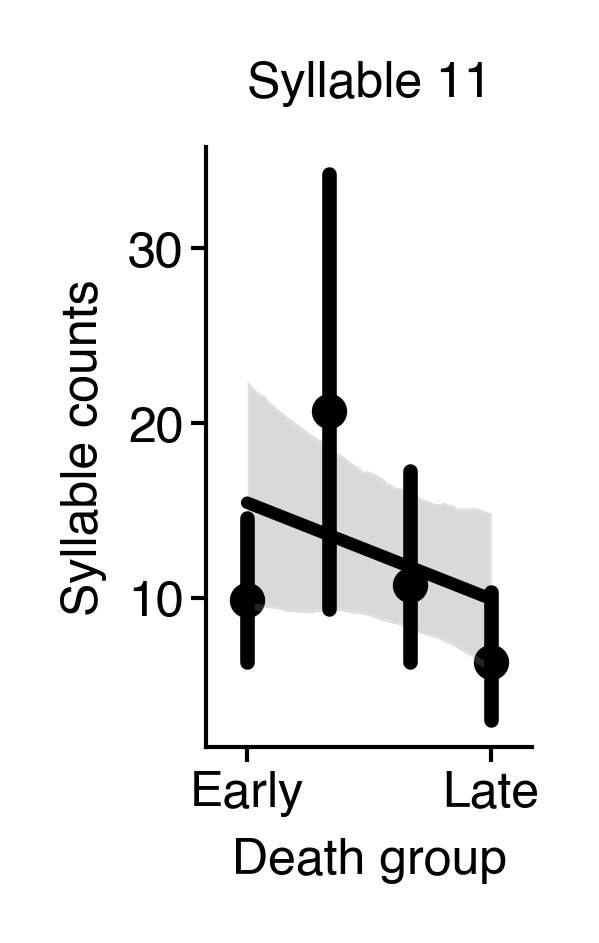

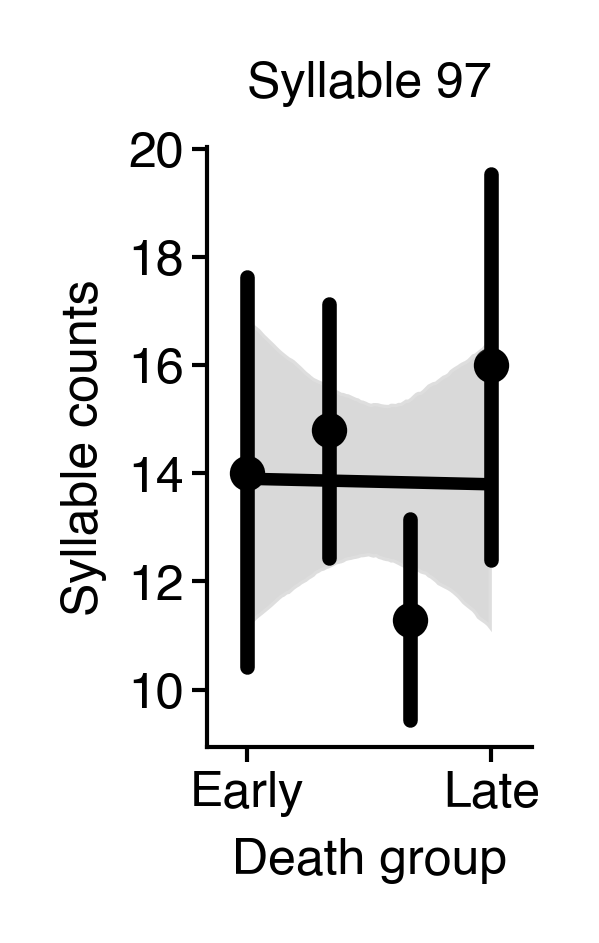

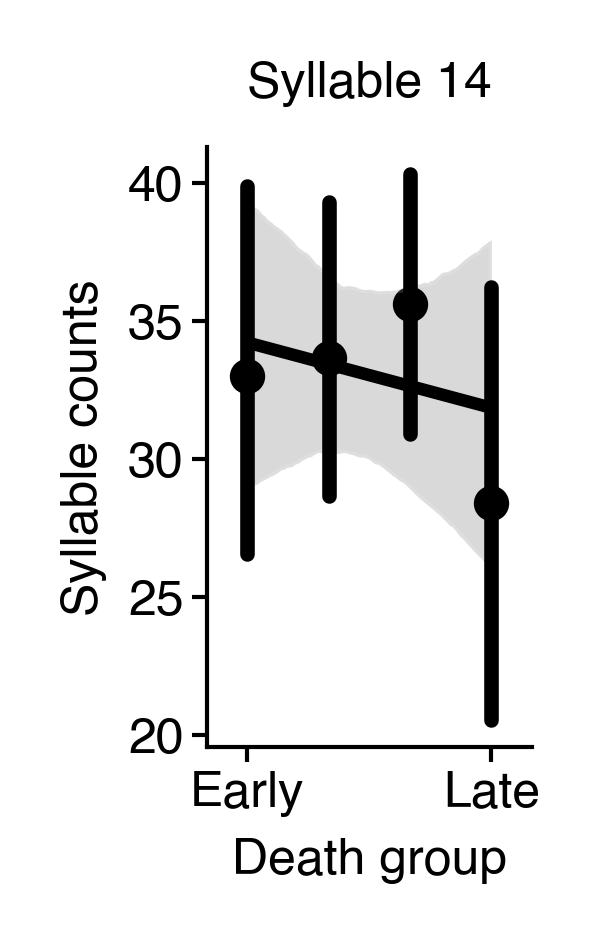

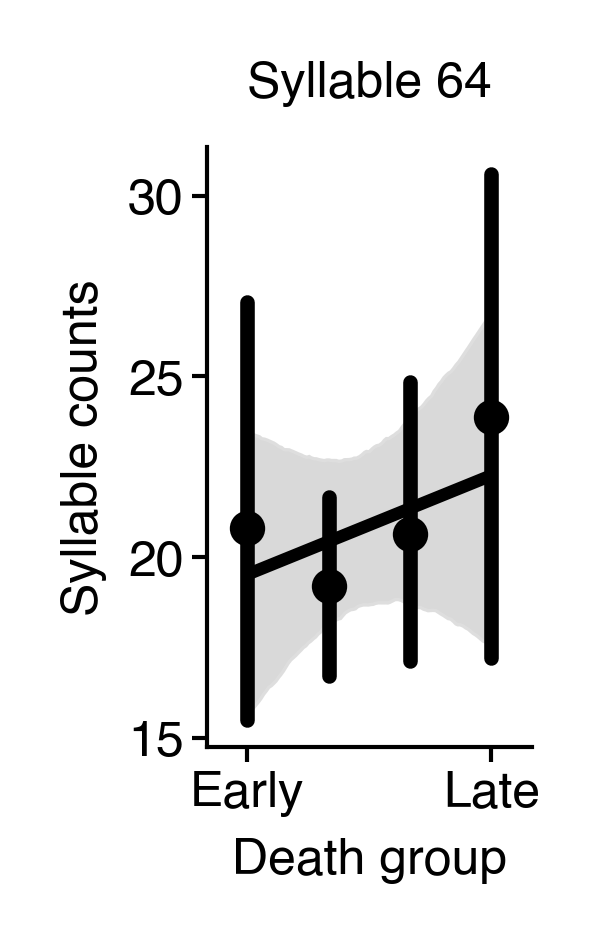

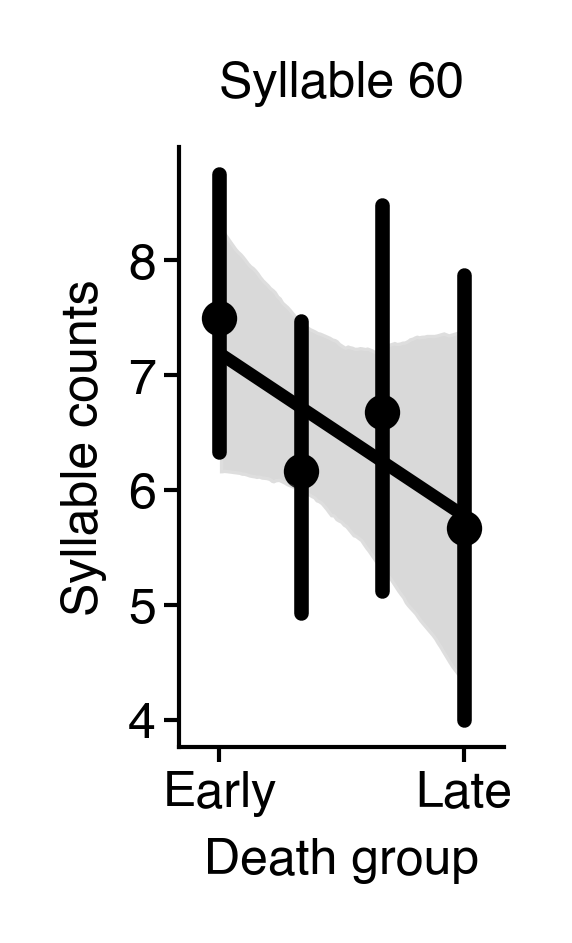

In [54]:
# subset_join["death_rank"] = subset_join["Death"].rank(method="dense")
subset_join["death_rank"] = pd.qcut(subset_join["Death"], n_classes, labels=False)
ss = subset_join.copy()

for syllable in pos + neg + mid:
    fig = figure(0.7, 1.3)
    ss[f"{syllable}"] = ss[syllable]
    ax = sns.regplot(data=ss, x='death_rank', y=f"{syllable}", x_bins=12, scatter_kws=dict(s=18, lw=0), color='k')
    ax.set(ylabel="Syllable counts", xlabel="Death group", title=f"Syllable {syllable}", xlim=(-0.5, 3.5), xticks=[0, 3], xticklabels=['Early', 'Late'])
    # plt.xticks(rotation=90);
    sns.despine()
    saver(fig, f"{syllable}-counts-vs-death-reg")

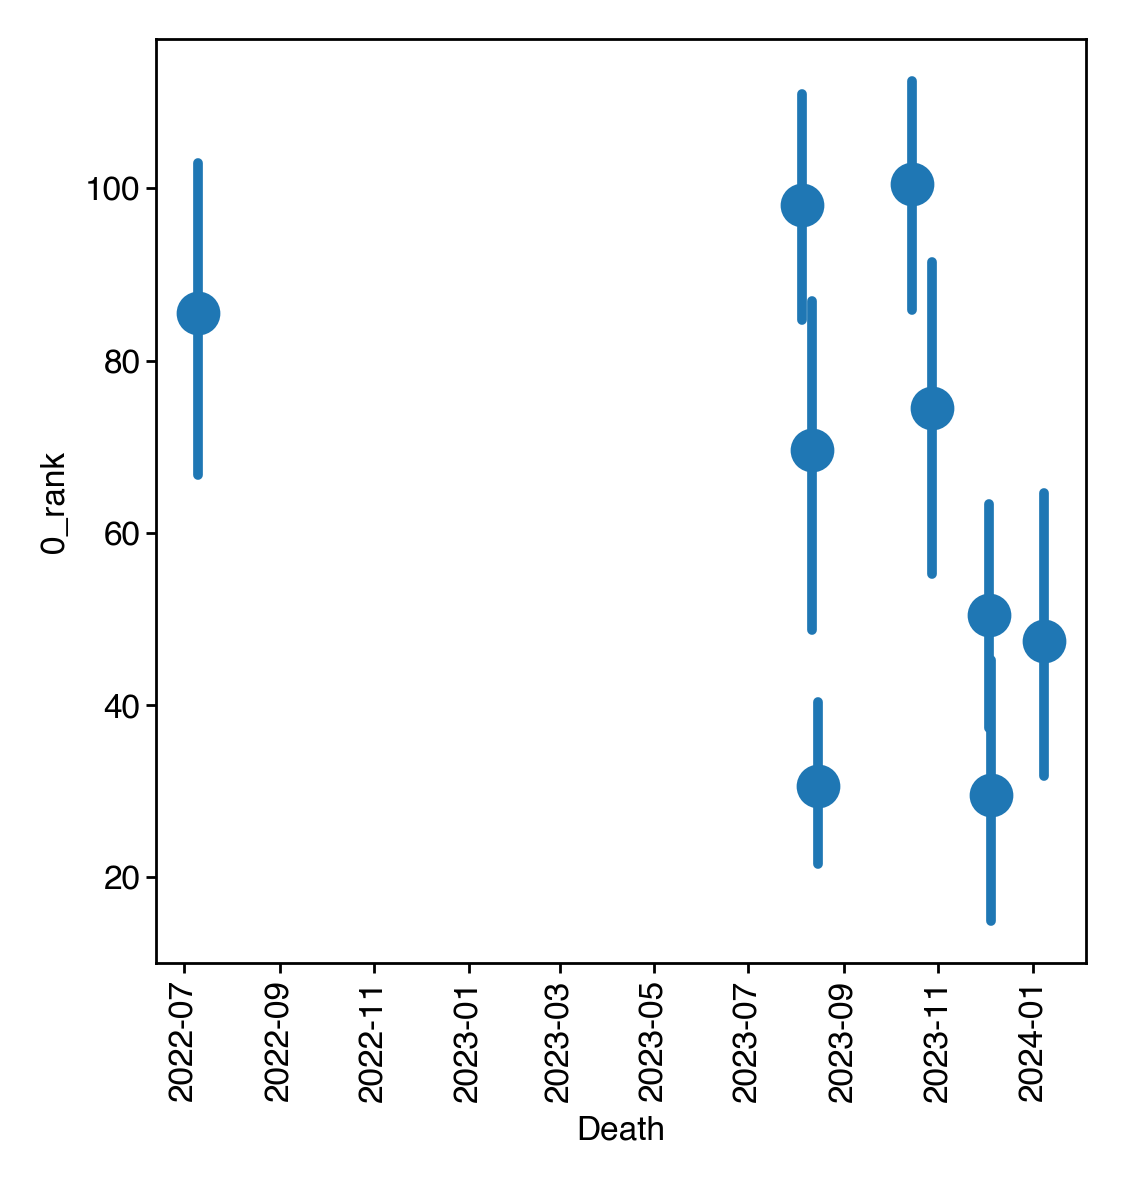

In [271]:
ax = sns.regplot(data=subset_join, x='Death', y=f'{syllable}_rank', x_bins=30, fit_reg=False)
plt.xticks(rotation=90);